In [89]:
# Importing the necessry modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# matplotlib.style.use('ggplot')
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords

#import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from wordcloud import WordCloud ,STOPWORDS

from textblob import TextBlob

#FeatureEngineering and modelling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Importing the dataset
df=pd.read_excel('Womens Clothing Reviews Data.xlsx')

In [3]:
df.head()

Product ID        Category Subcategory1 SubCategory2   Location Channel  \
0         767       Initmates     Intimate    Intimates     Mumbai  Mobile   
1        1080         General      Dresses      Dresses  Bangalore  Mobile   
2        1077         General      Dresses      Dresses    Gurgaon  Mobile   
3        1049  General Petite      Bottoms        Pants    Chennai     Web   
4         847         General         Tops      Blouses  Bangalore     Web   

   Customer Age             Review Title  \
0            33                      NaN   
1            34                      NaN   
2            60  Some major design flaws   
3            50         My favorite buy!   
4            47         Flattering shirt   

                                         Review Text  Rating  Recommend Flag  
0  Absolutely wonderful - silky and sexy and comf...       4               1  
1  Love this dress!  it's sooo pretty.  i happene...       5               1  
2  I had such high hopes for this dress and reall...       3               0  
3  I love, love, love this jumpsuit. it's fun, fl...       5               1  
4  This shirt is very flattering to all due to th...       5               1

In [4]:
df.shape

(23486, 11)

In [5]:
df.isna().sum()

Product ID           0
Category            14
Subcategory1        14
SubCategory2        14
Location             0
Channel              0
Customer Age         0
Review Title      3810
Review Text        845
Rating               0
Recommend Flag       0
dtype: int64

In [6]:
# dropping useless columns
df.drop(columns='Review Title', inplace=True)

In [7]:
#Dropping null values
df.dropna(inplace=True)
df.shape

(22628, 10)

In [8]:
# Renaming columns
df.columns=[ "_".join(i.split(' ')) for i in df.columns]

# EDA

In [9]:
# For other categories

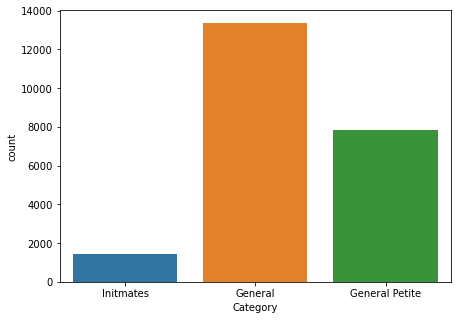

In [10]:
# Total orders per category
plt.figure(figsize=(7,5))
sns.countplot(df['Category'])
plt.show()

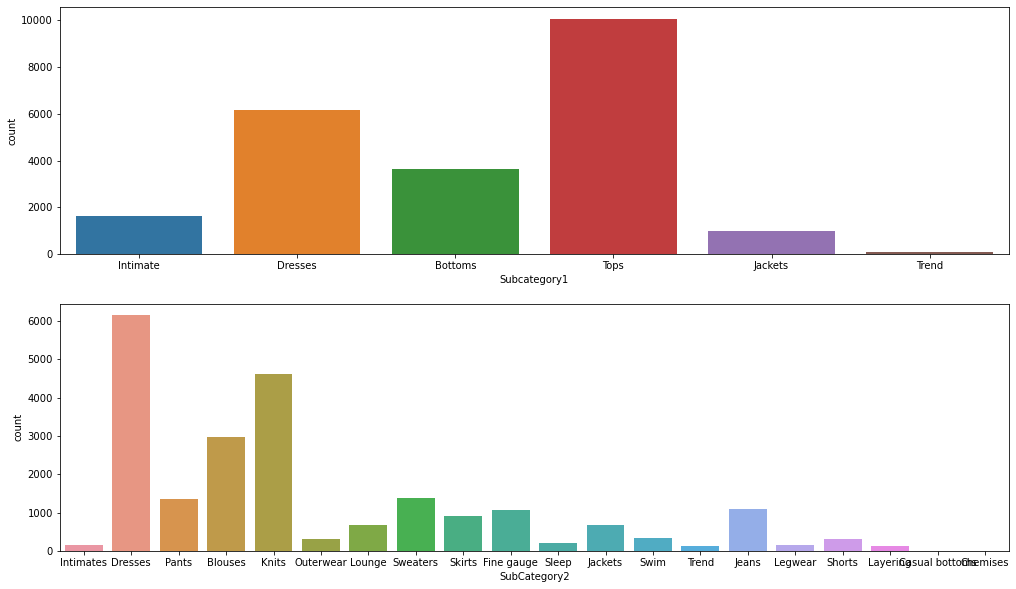

In [11]:
# Total orders per subcategories
fig, axes= plt.subplots(nrows=2, figsize=(17,10))
# plt.figure(figsize=(17,7))
sns.countplot(df['Subcategory1'], ax=axes[0])
# plt.figure(figsize=(17,7))
sns.countplot(df['SubCategory2'], ax=axes[1])
plt.show()

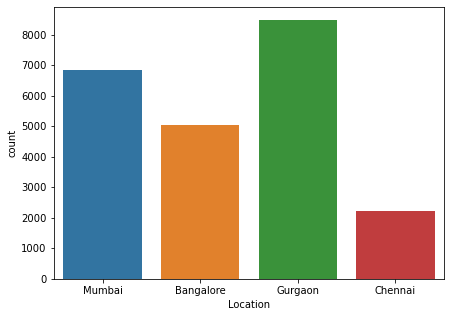

In [12]:
#Total orders per Location
plt.figure(figsize=(7,5))
sns.countplot(df['Location'])
plt.show()

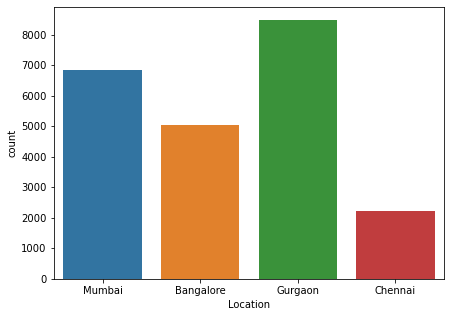

In [13]:
#Total orders per Channel
plt.figure(figsize=(7,5))
sns.countplot(df['Location'])
plt.show()

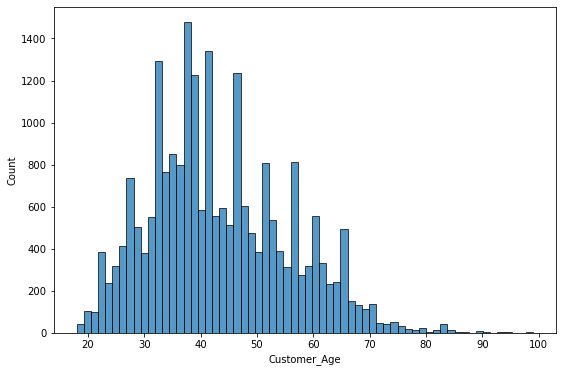

In [14]:
#Distribution of age
plt.figure(figsize=(9,6))
sns.histplot(df['Customer_Age'])

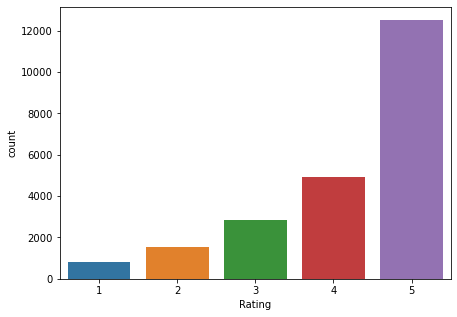

In [15]:
# Distribution of rating
plt.figure(figsize=(7,5))
sns.countplot(df['Rating'])
plt.show()

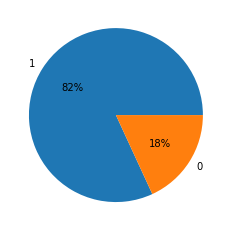

In [16]:
# Distribution of rating
plt.pie(df['Recommend_Flag'].value_counts(), labels=[1,0],autopct='%.0f%%')
plt.show()

In [17]:
# Taking reviews out of the dataframe
reviews= df['Review_Text']

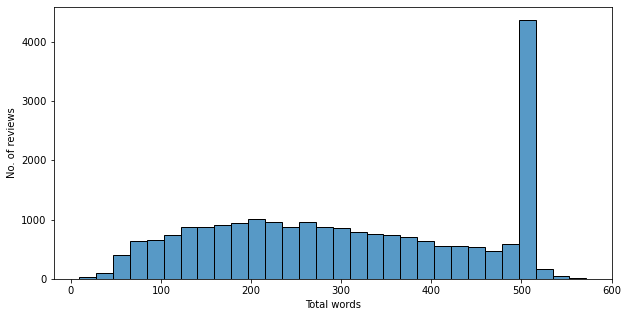

In [18]:
# Distribution of length of reviews
plt.figure(figsize=(10,5))
sns.histplot([len(str(i)) for i in reviews])
plt.ylabel('No. of reviews')
plt.xlabel('Total words')
plt.show()

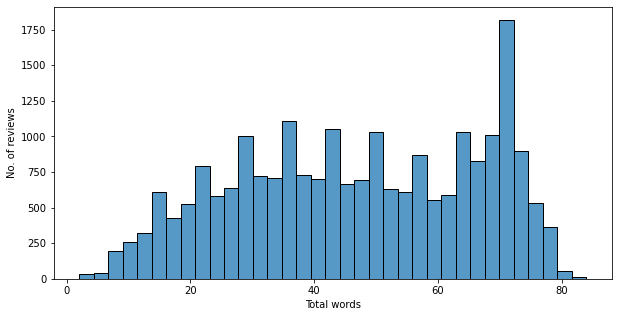

In [19]:
# Distribution of distinct length of reviews
plt.figure(figsize=(10,5))
sns.histplot([len(set(str(i).split(" "))) for i in reviews])
plt.ylabel('No. of reviews')
plt.xlabel('Total words')
plt.show()

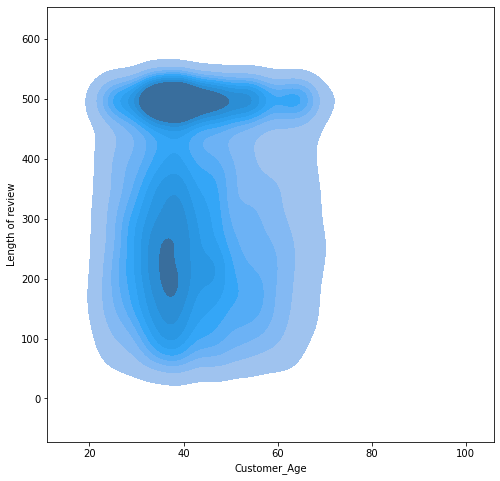

In [20]:
# Is there any relationship between lenght of  review, stars givena and the recommended flag
plt.figure(figsize=(8,8))
sns.kdeplot(y=[len(str(i)) for i in reviews], x=df['Customer_Age'], fill=True)
plt.ylabel('Length of review')
plt.show()

# Polarity analysis

In [21]:
# Copying and cleaning the data
copy= df.copy()
stop = set(nltk.corpus.stopwords.words('english'))

#preprocessing function
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = text.replace('favorites',"favorite").replace('cons','')
    text = re.sub(r"[-()\"#/@;:{}`+=~|.!?,'0-9]", "", text)
    text = ' '.join([i for i in text.split(' ')  if i not in stop])

    return(text)

In [22]:
copy['Review_Text']=df['Review_Text'].apply(lambda x :clean_text(str(x)))

In [23]:
# Preprocessing 
import string
Word=WordNetLemmatizer()
def pre_process(text):
    text = text.apply(lambda x: " ".join(x.translate(str.maketrans('', '', string.punctuation)) for x in x.split() if x.isalpha()))
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stop)) #Removing stop words
#    text = text.apply(lambda x: str(TextBlob(x).correct()))                      #Correct spelling corrections
#    text = text.apply(lambda x: " ".join(PorterStemmer().stem(word) for word in x.split())) #Stemming using porter stemmer
#    text = text.apply(lambda x: " ".join(stemmer_func(word) for word in x.split()))        #Stemming
    text = text.apply(lambda x: " ".join([Word.lemmatize(word ,pos='v') for word in x.split()]))   #lemmatization
    text = text.apply(lambda x: " ".join(word for word, pos in pos_tag(x.split()) if pos not in ['NN','NNS','NNP','NNPS'])) #Removing nouns etc
    return(text)

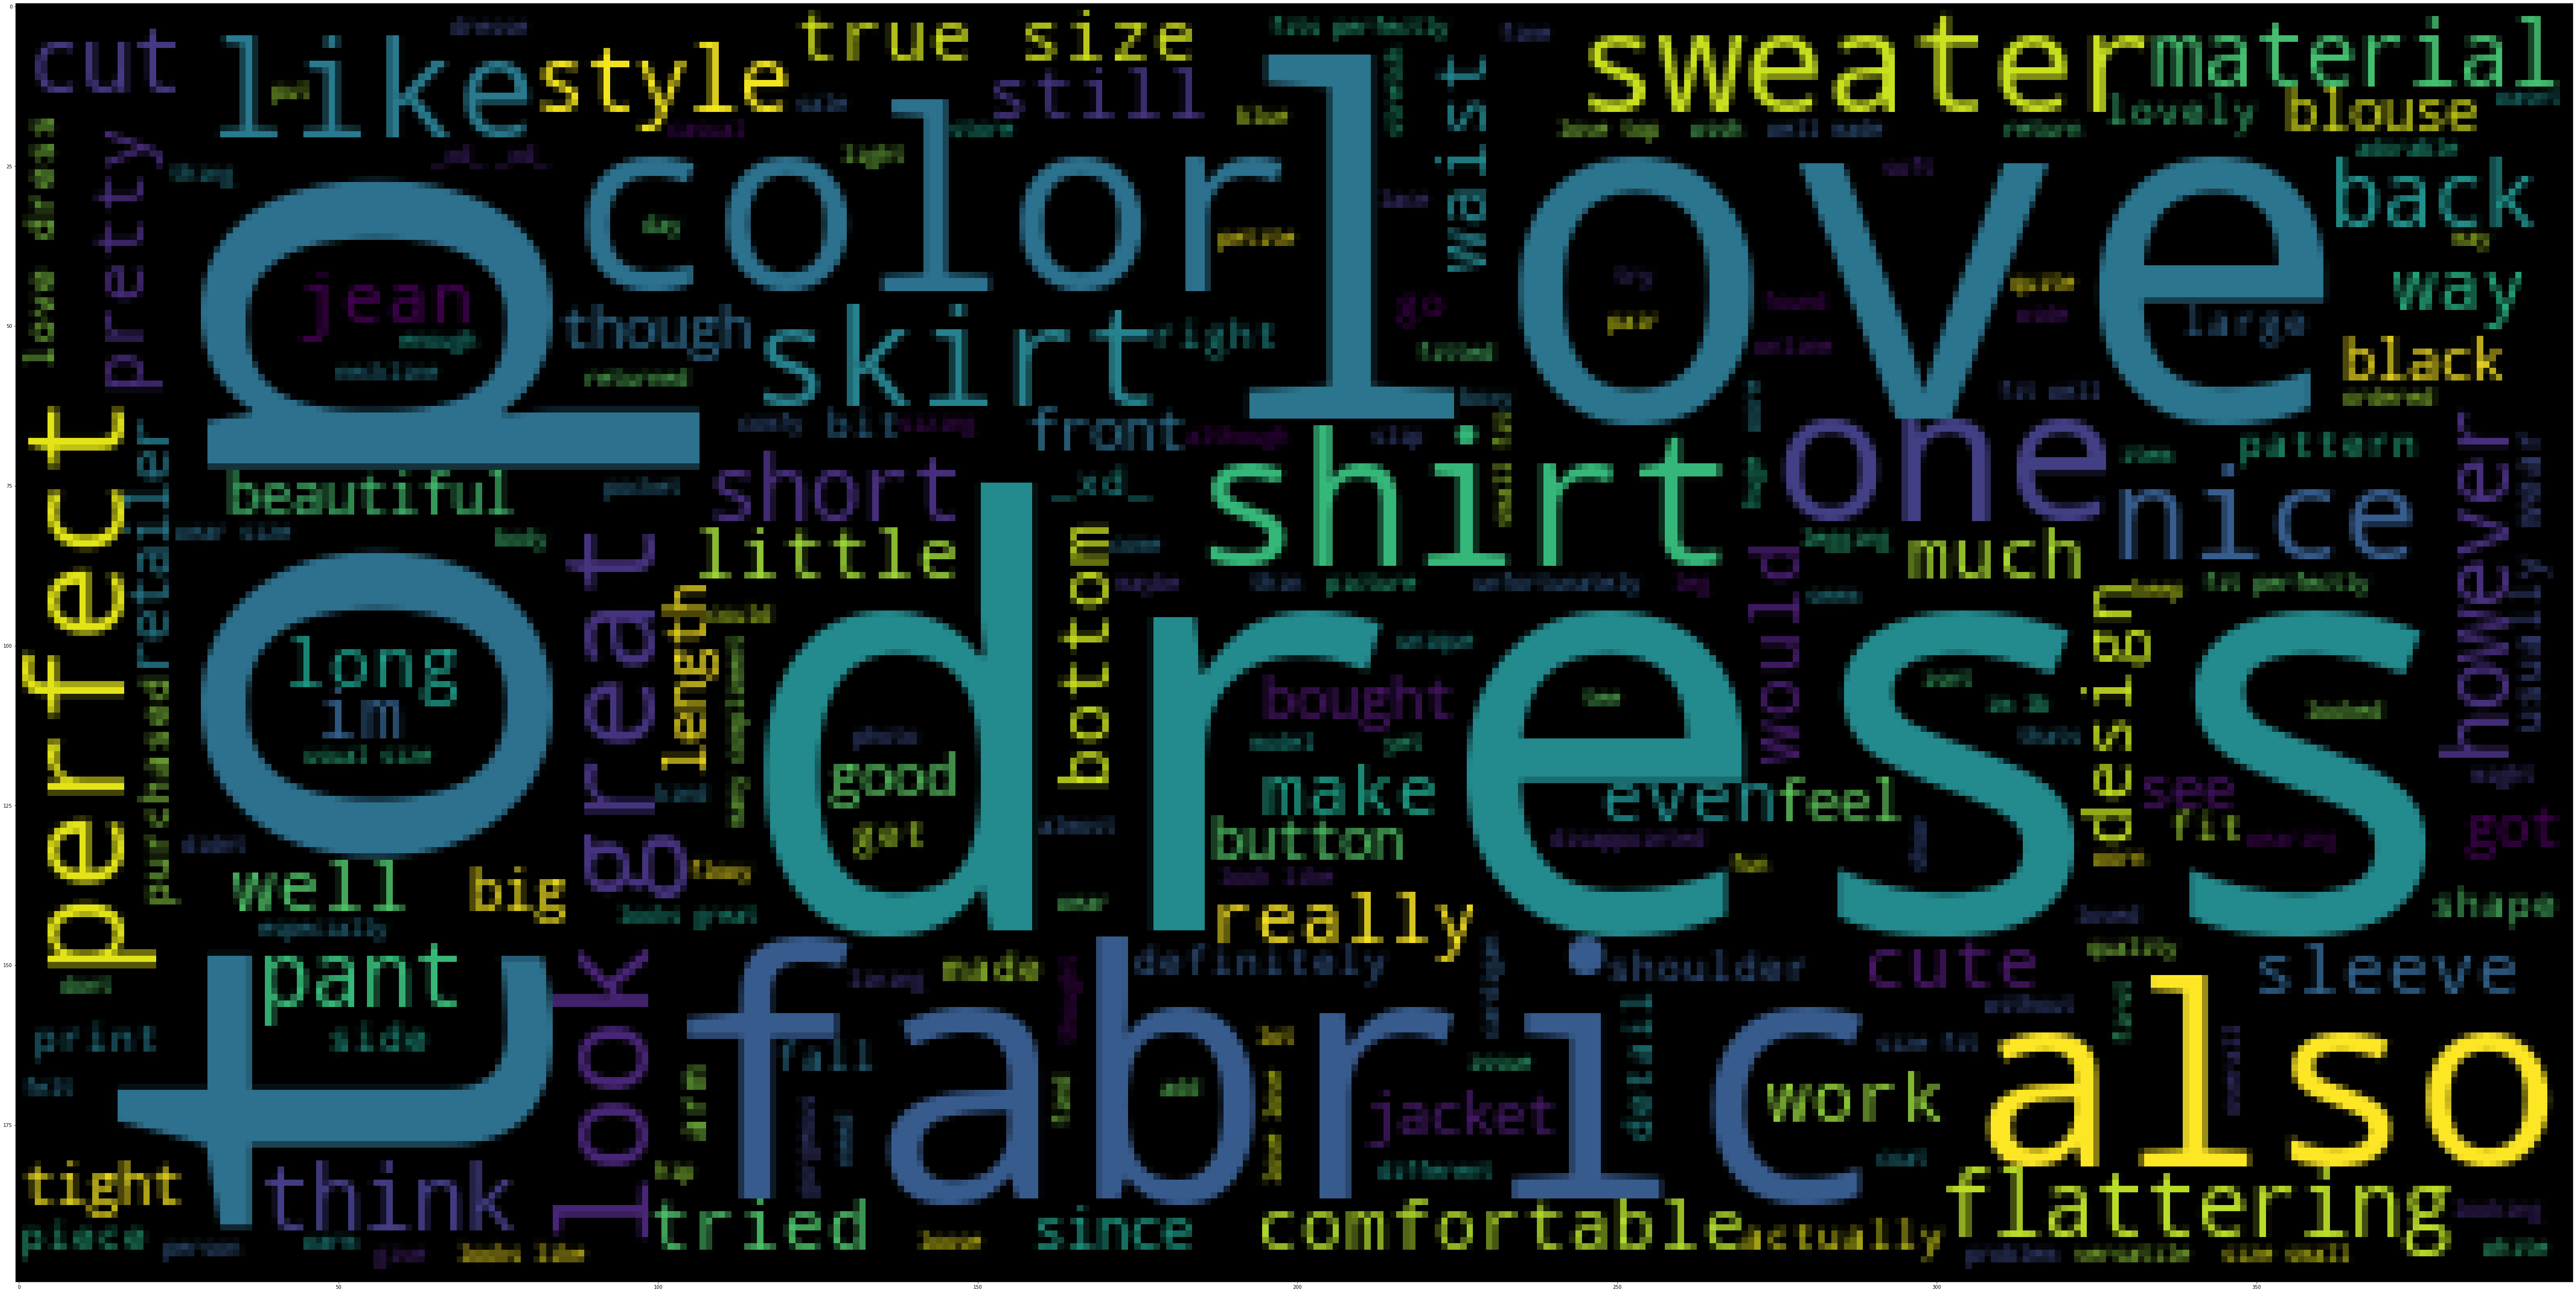

In [24]:
# Most used words in the entire text
wordcloud= WordCloud(stopwords=stop).generate(' '.join(copy['Review_Text'].to_list()))
fig = plt.figure(figsize=(200,50))
plt.imshow(wordcloud)
plt.show()

In [25]:
# Preprocessing th revie
copy['Review_Text']= pre_process(copy['Review_Text'])

In [26]:
# Calculating polarity score
copy['Sentiment_score']=[TextBlob(i).sentiment.polarity for i in copy.Review_Text]

In [27]:
# Seperating the dataset
positive_review= copy['Review_Text'][copy['Rating']>=4]
negative_review = copy['Review_Text'][copy['Rating']<3]

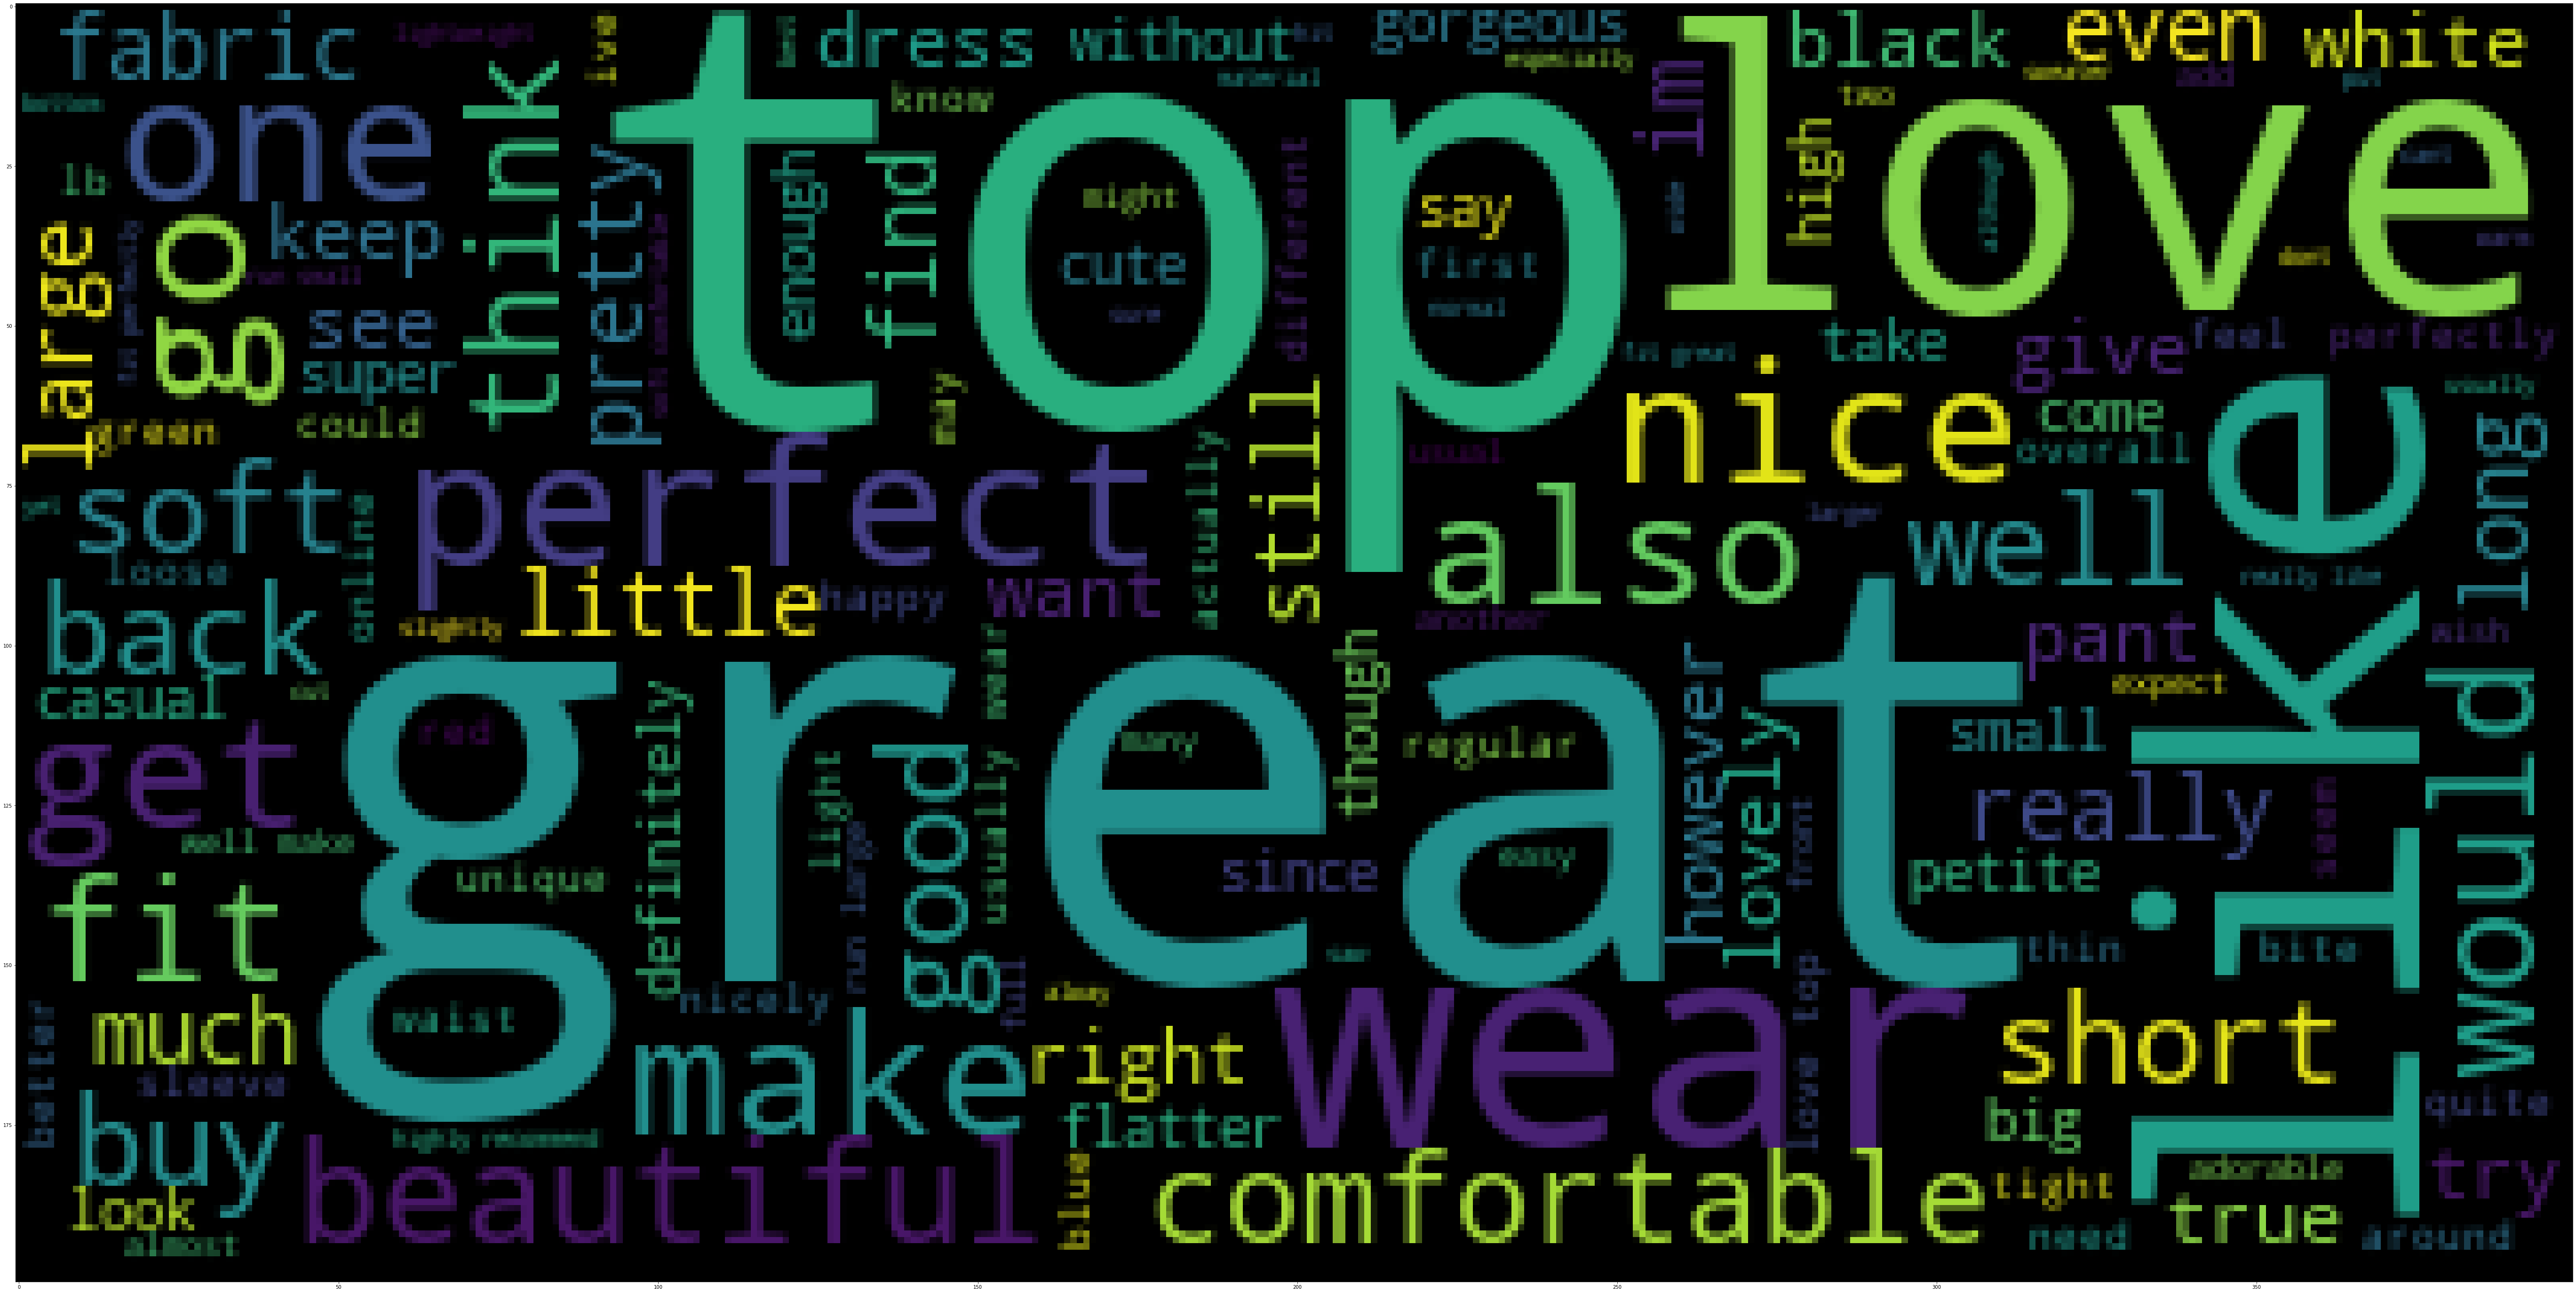

In [28]:
# Checking most used positive word in each category
stop1=set(list(stop)+['really','would','also','make'])
wordcloud= WordCloud(stopwords=stop).generate(' '.join(positive_review.to_list()))
fig = plt.figure(figsize=(200,50))
plt.imshow(wordcloud)
plt.show()

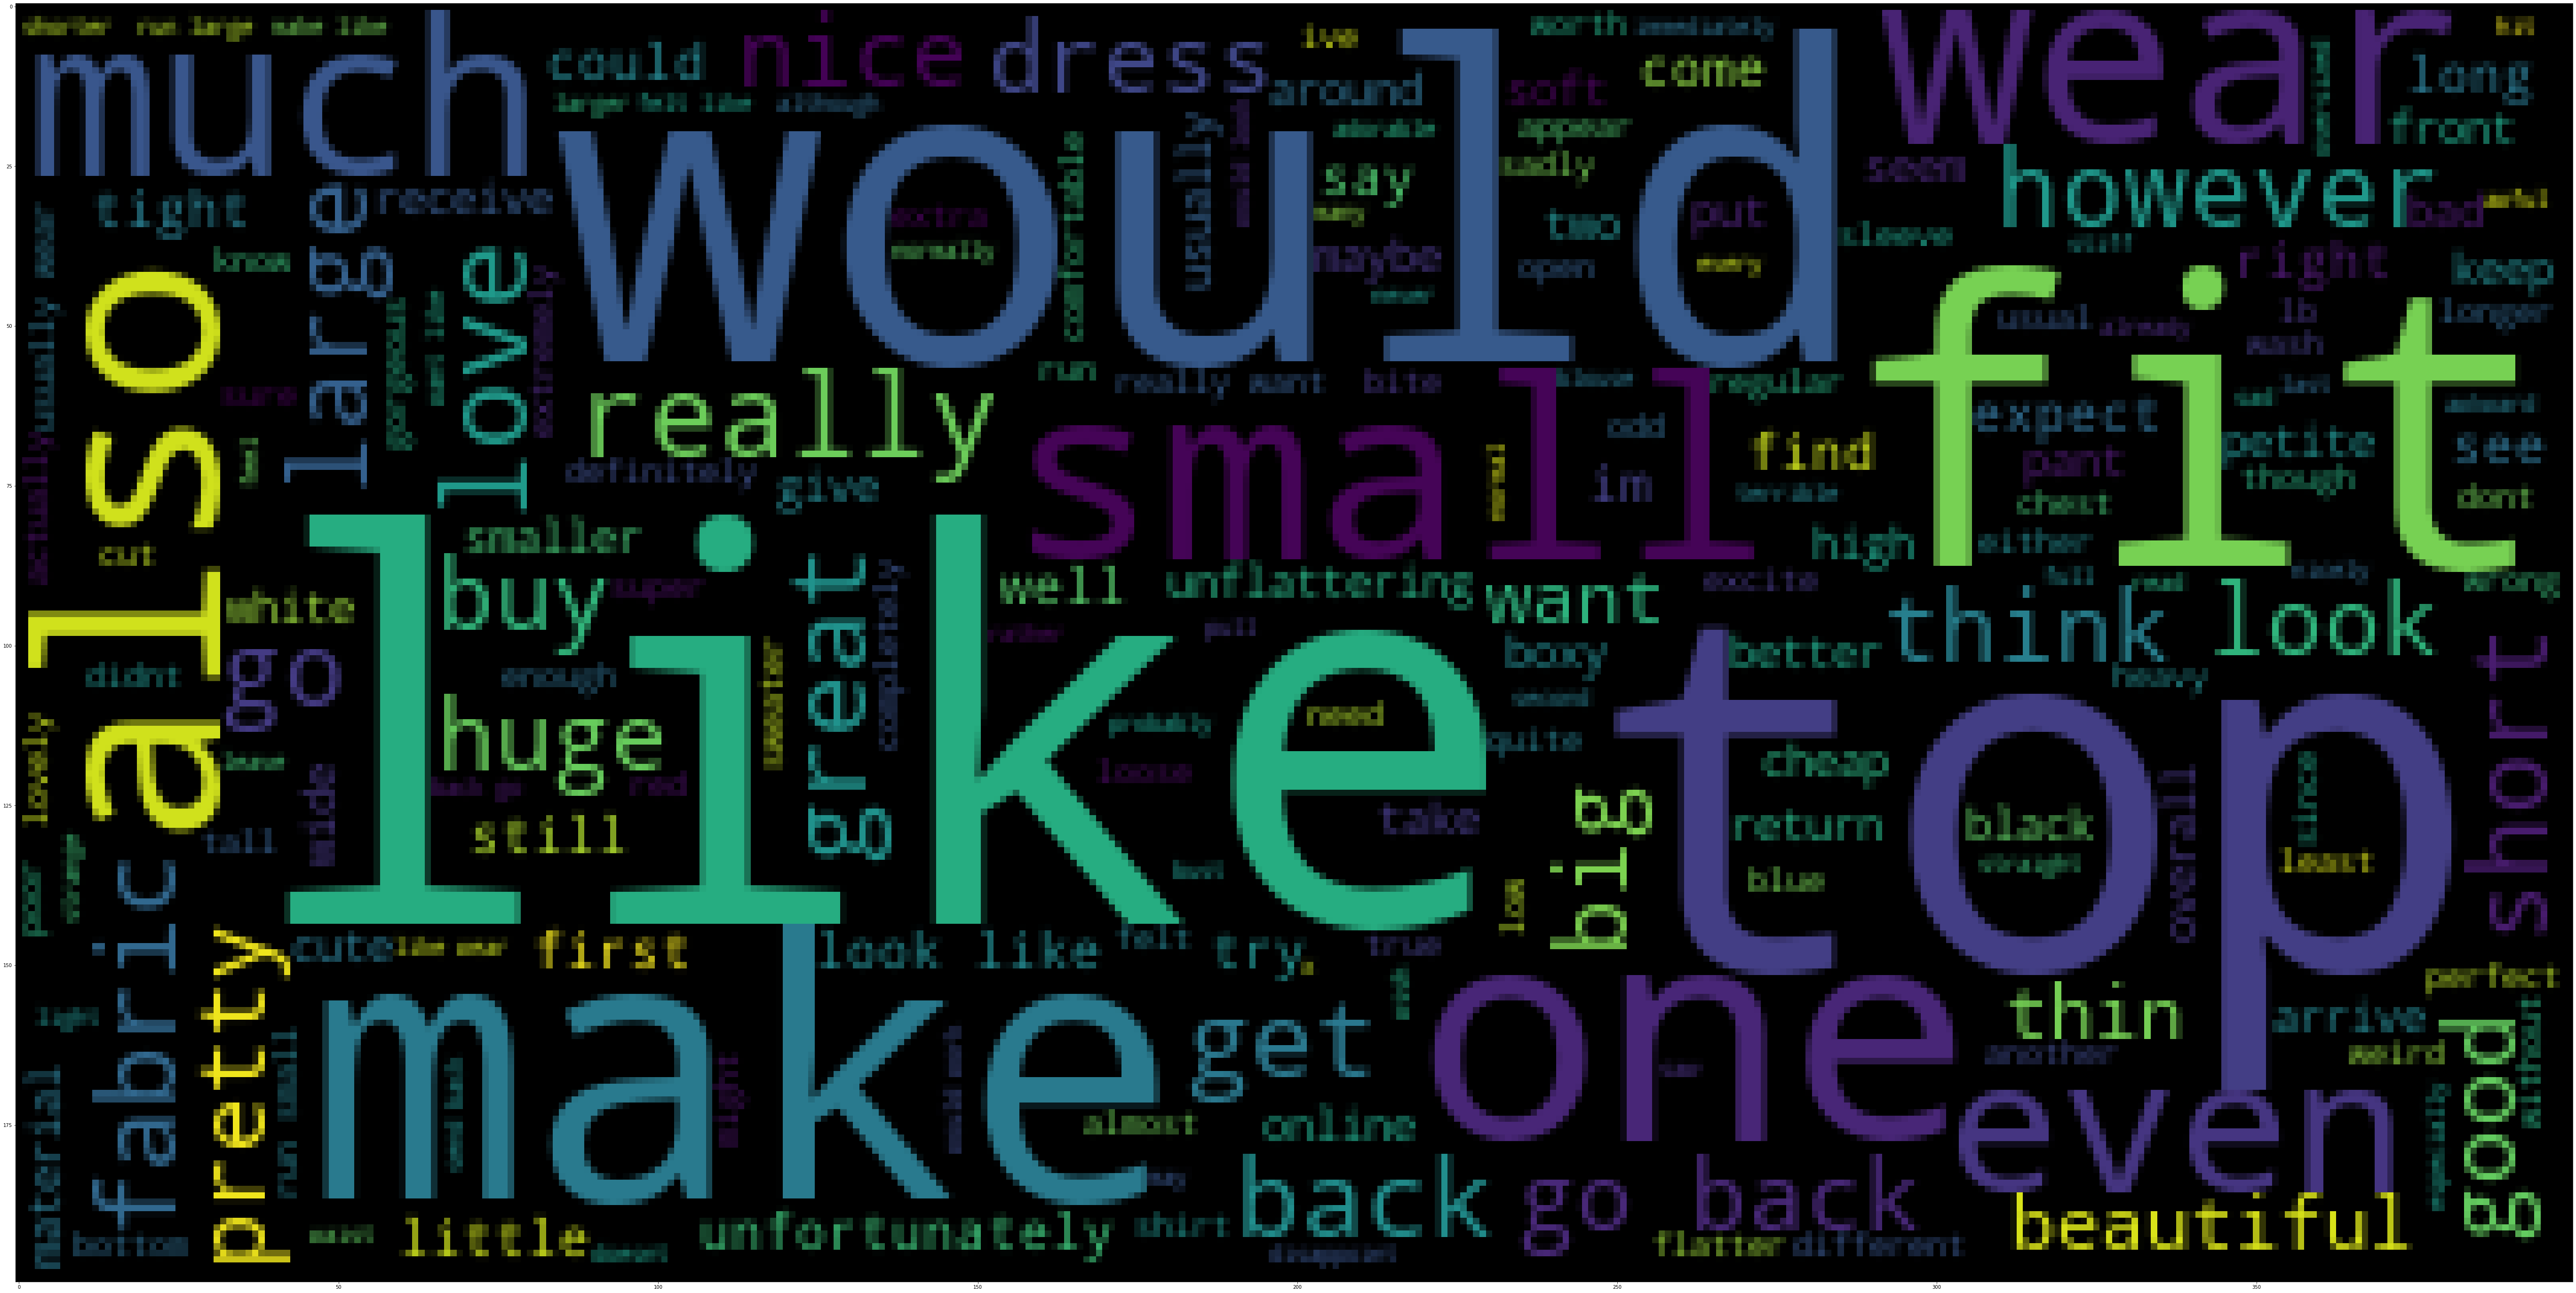

In [29]:
# Checking most used positive word in each category
wordcloud= WordCloud(stopwords=stop).generate(' '.join(negative_review.to_list()))
fig = plt.figure(figsize=(200,50))
plt.imshow(wordcloud)
plt.show()

In [30]:
#c. Understand sentiment among the customers on the different categories, sub categories,
#products by location and age group

EDA for sentiment score

In [99]:
# Categorizing data
copy['Sent_category']= np.where(copy.Sentiment_score>=0.2, 'Positive', np.where(copy.Sentiment_score<=-0.2,'Negative', 'Neutral'))
copy['age_group']= pd.cut(x=copy['Customer_Age'], bins=[0,30,60,100], labels=["young","middle_aged","old"])

In [32]:
copy['Customer_Age']

0        33
1        34
2        60
3        50
4        47
         ..
23481    34
23482    48
23483    31
23484    28
23485    52
Name: Customer_Age, Length: 22628, dtype: int64

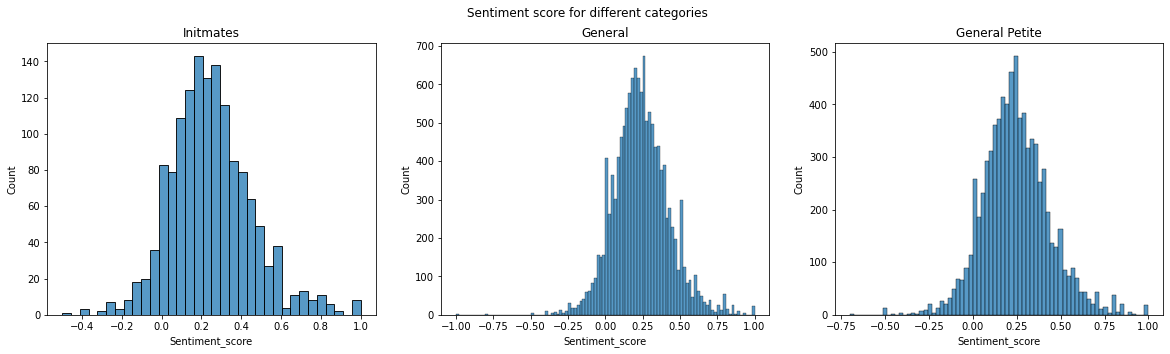

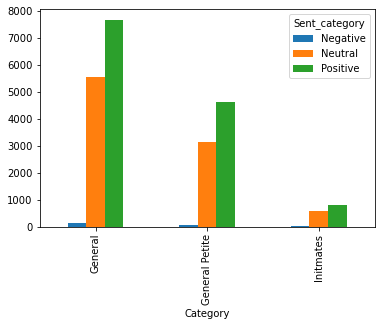

In [33]:
# Distribution of sentiment score per category
fig, axes= plt.subplots(ncols=3, figsize=(20,5))
for j,i in enumerate(copy['Category'].dropna().unique()):
        a=copy[copy['Category']==i]['Sentiment_score']
        sns.histplot(a, ax=axes[j])
        axes[j].set_title(i)
        plt.suptitle('Sentiment score for different categories')

# Total positive and negative reviews per category
pd.pivot_table(data=copy, index='Category',columns='Sent_category', aggfunc='count')['Channel'].plot(kind='bar')


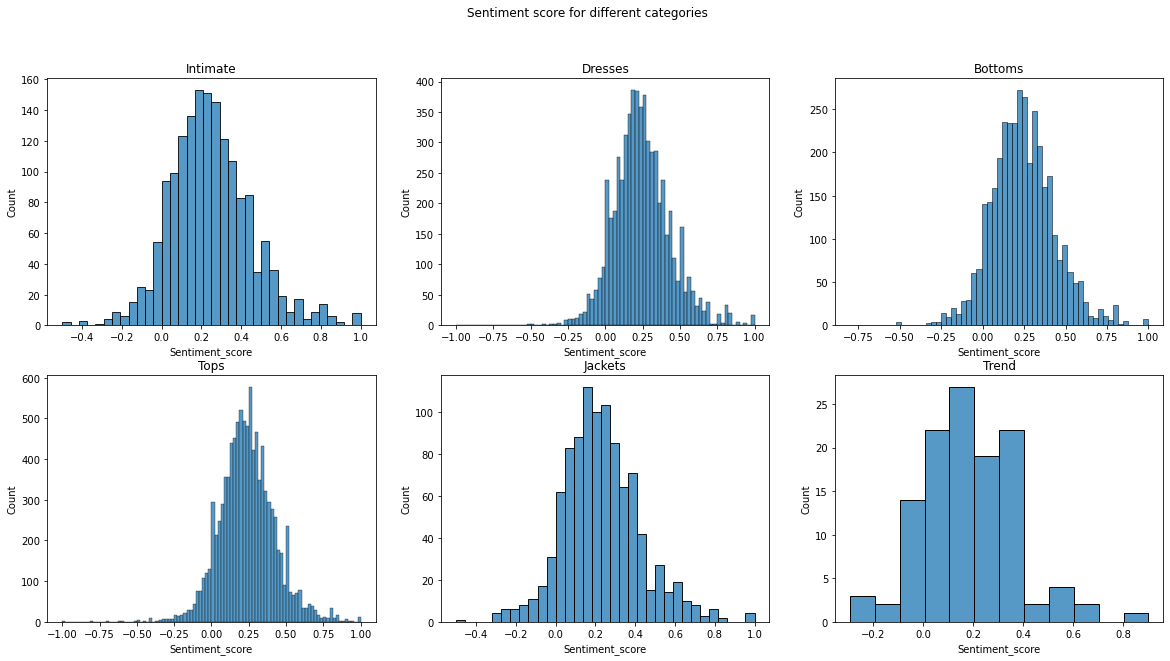

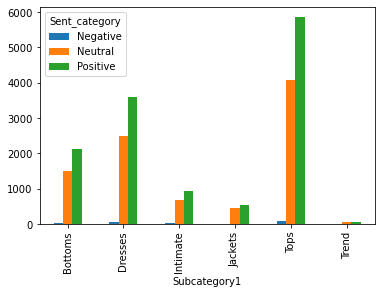

In [34]:
# Distribution of sentiment score per subcategory1
import math
j=0
fig, axes= plt.subplots(ncols=3,nrows=2, figsize=(20,10))
for num,i in enumerate(copy['Subcategory1'].dropna().unique()):
        a=copy[copy['Subcategory1']==i]['Sentiment_score']
        sns.histplot(a, ax= axes[math.floor(num/3),j])
        axes[math.floor(num/3),j].set_title(i)
        j+=1
        if j==3:
            j=0
        plt.suptitle('Sentiment score for different categories')

# Total positive and negative reviews per subcategory1
pd.pivot_table(data=copy, index='Subcategory1',columns='Sent_category', aggfunc='count')['Channel'].plot(kind='bar')


Text(0.5, 0.98, 'Sentiment score for different SubCategory2')

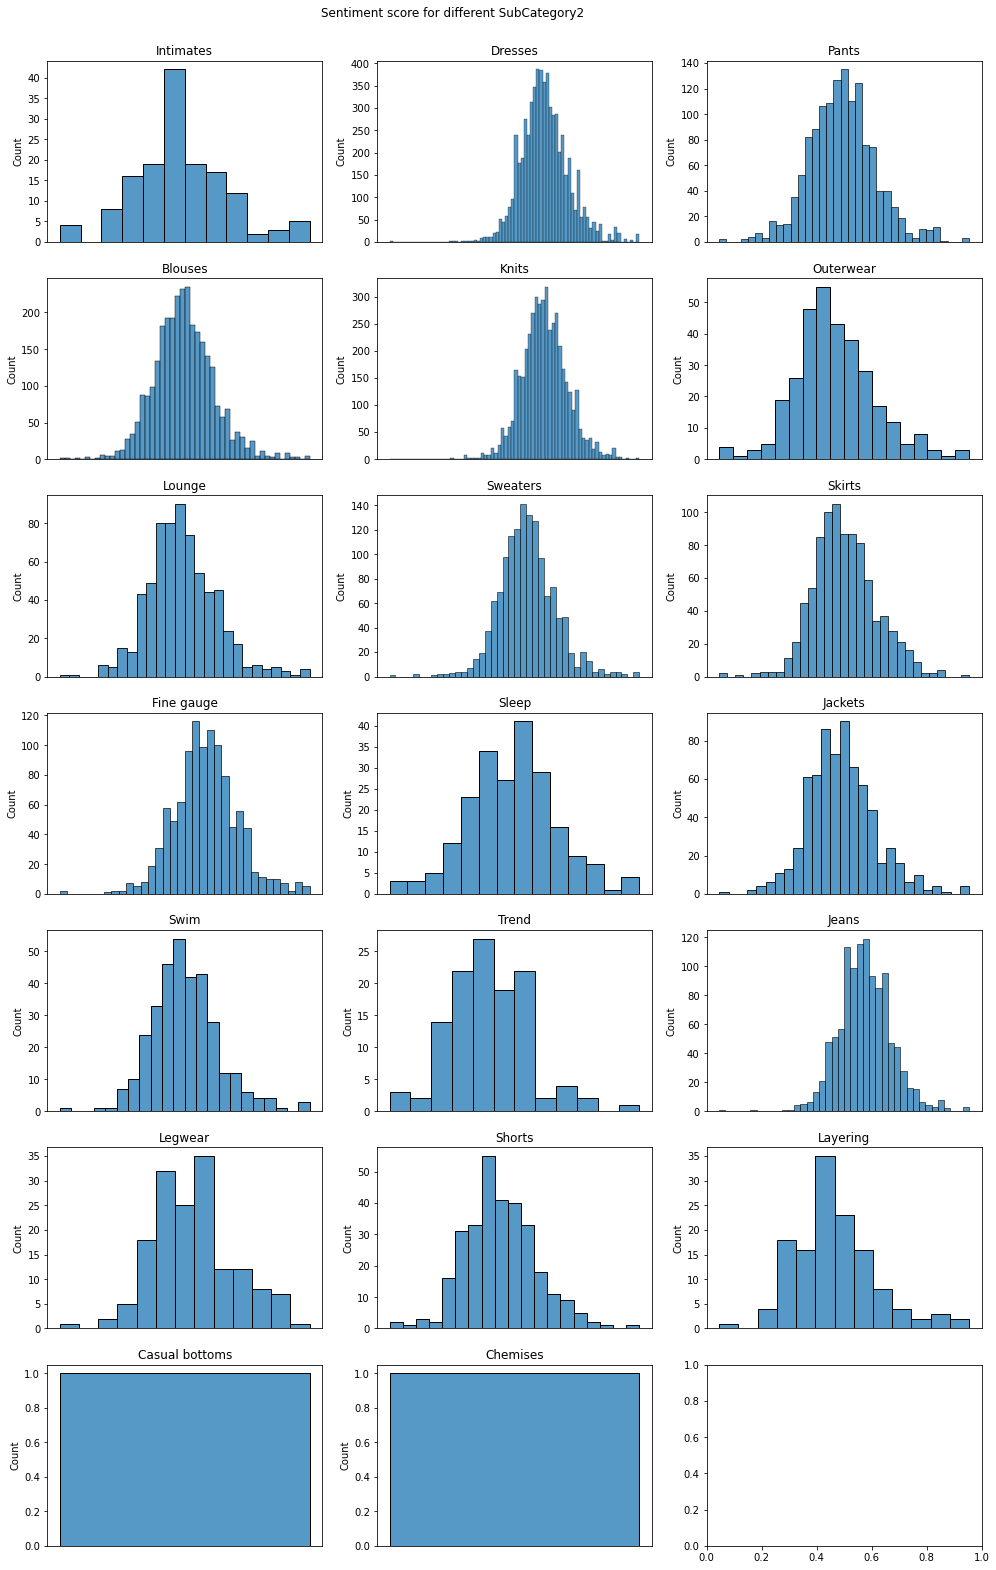

In [36]:
# Distribution of sentiment score per SubCategory2
import math
j=0
fig, axes= plt.subplots(ncols=3,nrows=7, figsize=(15,25))
for num,i in enumerate(copy['SubCategory2'].dropna().unique()):
        a=copy[copy['SubCategory2']==i]['Sentiment_score']
        sns.histplot(a, ax= axes[math.floor(num/3),j])
        axes[math.floor(num/3),j].set_title(i)
        axes[math.floor(num/3),j].get_xaxis().set_visible(False)
        j+=1
        if j==3:
            j=0
plt.subplots_adjust(top=0.95, right=0.99)
plt.suptitle('Sentiment score for different SubCategory2')

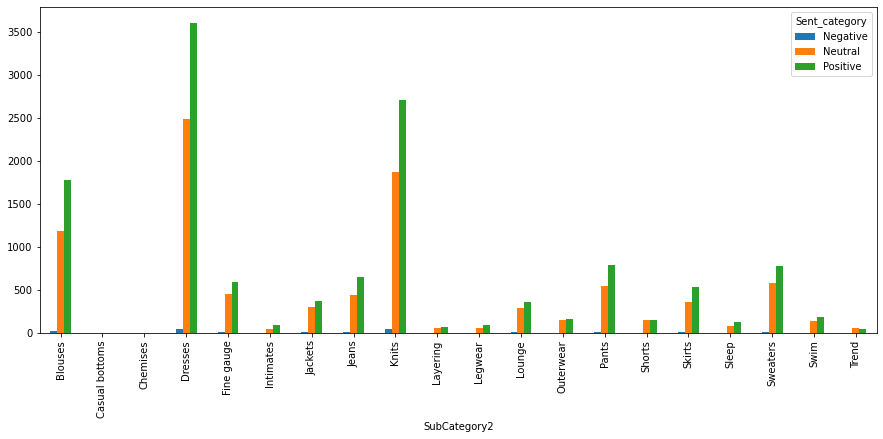

In [37]:
# Total positive and negative reviews per SubCategory2
pd.pivot_table(data=copy, index='SubCategory2',columns='Sent_category', aggfunc='count')['Channel'].plot(kind='bar')
plt.gcf().set_size_inches(15, 6)
plt.show()

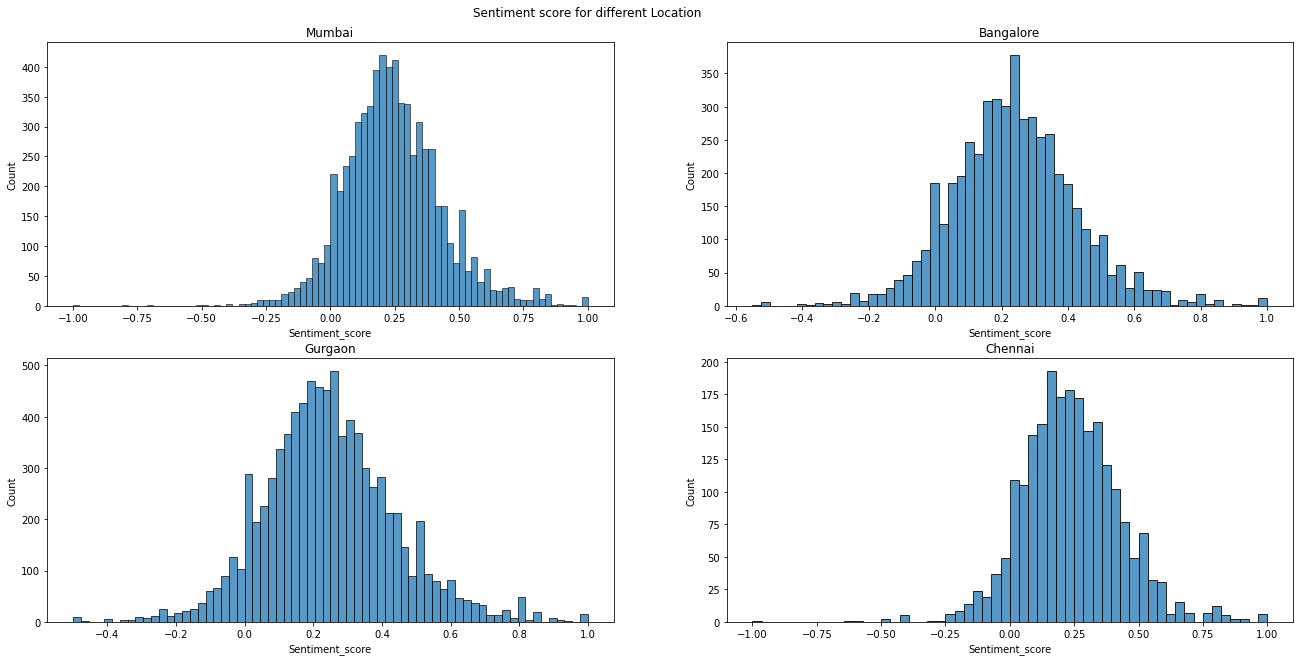

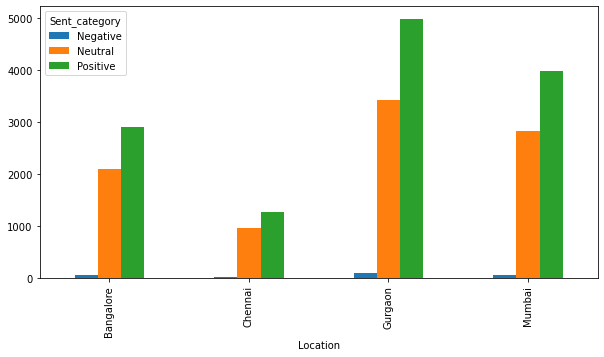

In [38]:
# Distribution of sentiment score per Location
import math
j=0
fig, axes= plt.subplots(ncols=2,nrows=2, figsize=(20,10))
for num,i in enumerate(copy['Location'].dropna().unique()):
        a=copy[copy['Location']==i]['Sentiment_score']
        sns.histplot(a, ax= axes[math.floor(num/2),j])
        axes[math.floor(num/2),j].set_title(i)
        j+=1
        if j==2:
            j=0
plt.subplots_adjust(top=0.93, right=0.99)
plt.suptitle('Sentiment score for different Location')

# Total positive and negative reviews per Location
pd.pivot_table(data=copy, index='Location',columns='Sent_category', aggfunc='count')['Channel'].plot(kind='bar')
plt.gcf().set_size_inches(10, 5)


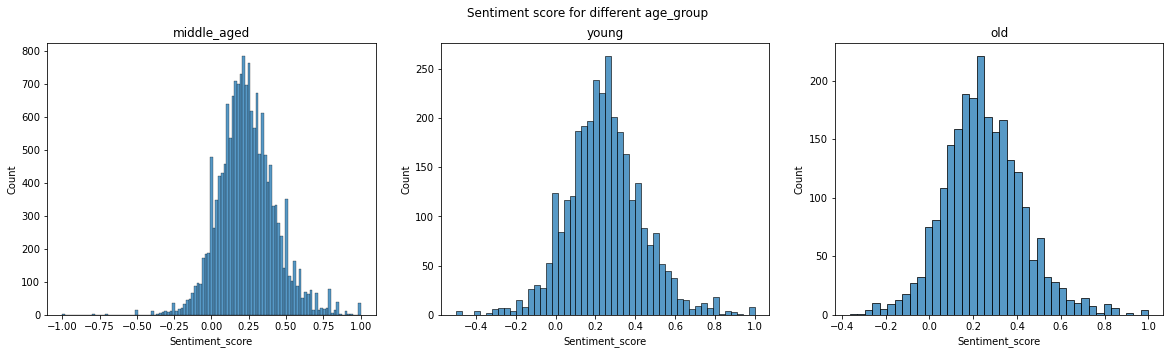

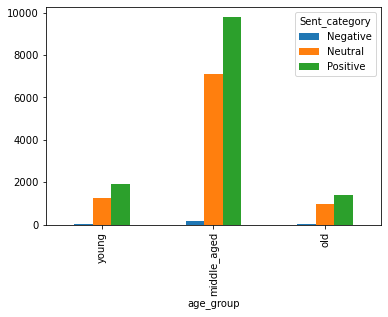

In [39]:
# Distribution of sentiment score per age_group
fig, axes= plt.subplots(ncols=3, figsize=(20,5))
for j,i in enumerate(copy['age_group'].dropna().unique()):
        a=copy[copy['age_group']==i]['Sentiment_score']
        sns.histplot(a, ax=axes[j])
        axes[j].set_title(i)
        plt.suptitle('Sentiment score for different age_group')

# Total positive and negative reviews per age_group
pd.pivot_table(data=copy, index='age_group',columns='Sent_category', aggfunc='count')['Channel'].plot(kind='bar')


d. Perform predictive analytics to understand the drivers of customers who are recommending the products

In [40]:
# Splitting the dataset
Y = copy.Recommend_Flag
X = copy.Review_Text
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.3, random_state=123)

In [41]:
# Vectrorization
tfidf_vect = TfidfVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             encoding='latin-1' , 
                             lowercase = True,
                             max_features=1000)

X_train_tfidf = tfidf_vect.fit_transform(train_X)
X_test_tfidf = tfidf_vect.transform(test_X)

dtm_tfidf_train=pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vect.get_feature_names())
dtm_tfidf_test=pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf_vect.get_feature_names())

In [71]:
# Logistic regression
lg_model1= LogisticRegression().fit(dtm_tfidf_train, train_y)

In [73]:
# Classification report
print(metrics.classification_report(train_y, lg_model1.predict(dtm_tfidf_train)))

print(metrics.classification_report(test_y, lg_model1.predict(dtm_tfidf_test)))

              precision    recall  f1-score   support

           0       0.79      0.47      0.59      2934
           1       0.89      0.97      0.93     12905

    accuracy                           0.88     15839
   macro avg       0.84      0.72      0.76     15839
weighted avg       0.87      0.88      0.87     15839

              precision    recall  f1-score   support

           0       0.73      0.45      0.55      1167
           1       0.89      0.96      0.93      5622

    accuracy                           0.88      6789
   macro avg       0.81      0.71      0.74      6789
weighted avg       0.86      0.88      0.86      6789



In [78]:
# #Model Building using different tuning parameters
# tuned_parameters = [{'n_neighbors': [3,5, 7, 9,11]}]
# knn_grid = GridSearchCV(KNeighborsClassifier(),tuned_parameters,cv=3).fit(dtm_tfidf_train, train_y)
# knn_grid.best_params_

{'n_neighbors': 9}

In [79]:
# Building KNN model
knn_model1= KNeighborsClassifier(n_neighbors=9).fit(dtm_tfidf_train, train_y)

In [80]:
# Classification report
print(metrics.classification_report(train_y, knn_model1.predict(dtm_tfidf_train)))

print(metrics.classification_report(test_y, knn_model1.predict(dtm_tfidf_test)))

              precision    recall  f1-score   support

           0       0.89      0.02      0.03      2934
           1       0.82      1.00      0.90     12905

    accuracy                           0.82     15839
   macro avg       0.85      0.51      0.47     15839
weighted avg       0.83      0.82      0.74     15839

              precision    recall  f1-score   support

           0       0.89      0.01      0.01      1167
           1       0.83      1.00      0.91      5622

    accuracy                           0.83      6789
   macro avg       0.86      0.50      0.46      6789
weighted avg       0.84      0.83      0.75      6789



In [42]:
# SVM models
lsvc_model = LinearSVC(C=1.0).fit(dtm_tfidf_train, train_y)

In [43]:
# Classification report
print(metrics.classification_report(train_y, lsvc_model.predict(dtm_tfidf_train)))

print(metrics.classification_report(test_y, lsvc_model.predict(dtm_tfidf_test)))

              precision    recall  f1-score   support

           0       0.77      0.56      0.65      2934
           1       0.91      0.96      0.93     12905

    accuracy                           0.89     15839
   macro avg       0.84      0.76      0.79     15839
weighted avg       0.88      0.89      0.88     15839

              precision    recall  f1-score   support

           0       0.67      0.50      0.57      1167
           1       0.90      0.95      0.92      5622

    accuracy                           0.87      6789
   macro avg       0.79      0.72      0.75      6789
weighted avg       0.86      0.87      0.86      6789



In [85]:
# # Random forest
from sklearn.ensemble import RandomForestClassifier
# pargrid_ada = {'n_estimators': [50,70,80,100],'max_depth':[5,8,10,12,15]}
# rf_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=pargrid_ada, cv=3,n_jobs=-1).fit(dtm_tfidf_train, train_y)
rf_grid.best_params_

In [87]:
# Building Random forest model 
rf_model1= RandomForestClassifier(n_estimators=80,max_depth=15).fit(dtm_tfidf_train, train_y)

In [88]:
# Classification report
print(metrics.classification_report(train_y, rf_model1.predict(dtm_tfidf_train)))

print(metrics.classification_report(test_y, rf_model1.predict(dtm_tfidf_test)))

              precision    recall  f1-score   support

           0       1.00      0.07      0.13      2934
           1       0.83      1.00      0.90     12905

    accuracy                           0.83     15839
   macro avg       0.91      0.53      0.52     15839
weighted avg       0.86      0.83      0.76     15839

              precision    recall  f1-score   support

           0       0.92      0.03      0.05      1167
           1       0.83      1.00      0.91      5622

    accuracy                           0.83      6789
   macro avg       0.87      0.51      0.48      6789
weighted avg       0.85      0.83      0.76      6789



While considering ohter factors too

In [44]:
# Making a new copy of the dataset
new_copy= copy.drop(columns=['Review_Text','Sent_category', 'age_group'])

In [45]:
#Vectorization
tfidf_vect = TfidfVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             encoding='latin-1' , 
                             lowercase = True,
                             max_features=1000)

X_tfidf = tfidf_vect.fit_transform(X)
X_tfidf=pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vect.get_feature_names())

In [46]:
final_data=pd.concat([pd.get_dummies(new_copy), X_tfidf],axis=1)
final_data.dropna(inplace=True)

In [47]:
# Splitting the data
Y_full = final_data.Recommend_Flag
X_full = final_data.drop(columns='Recommend_Flag')
train_X_full, test_X_full, train_y_full, test_y_full = train_test_split(X_full, Y_full, test_size=0.3, random_state=123)

In [92]:
# Logistic regression
lg_model2= LogisticRegression().fit(train_X_full, train_y_full)

In [93]:
# Classification report
print(metrics.classification_report(train_y_full, lg_model2.predict(train_X_full)))

print(metrics.classification_report(test_y_full, lg_model2.predict(test_X_full)))

              precision    recall  f1-score   support

         0.0       0.80      0.83      0.82      2813
         1.0       0.96      0.95      0.96     12445

    accuracy                           0.93     15258
   macro avg       0.88      0.89      0.89     15258
weighted avg       0.93      0.93      0.93     15258

              precision    recall  f1-score   support

         0.0       0.79      0.80      0.79      1135
         1.0       0.96      0.95      0.96      5405

    accuracy                           0.93      6540
   macro avg       0.87      0.88      0.88      6540
weighted avg       0.93      0.93      0.93      6540



In [94]:
# KNN model
knn_model2= KNeighborsClassifier(n_neighbors=9).fit(train_X_full, train_y_full)

In [95]:
# Classification report
print(sklearn.metrics.classification_report(train_y_full, knn_model2.predict(train_X_full)))

print(sklearn.metrics.classification_report(test_y_full, knn_model2.predict(test_X_full)))

              precision    recall  f1-score   support

         0.0       0.92      0.48      0.63      2813
         1.0       0.89      0.99      0.94     12445

    accuracy                           0.90     15258
   macro avg       0.91      0.74      0.79     15258
weighted avg       0.90      0.90      0.88     15258

              precision    recall  f1-score   support

         0.0       0.88      0.37      0.52      1135
         1.0       0.88      0.99      0.93      5405

    accuracy                           0.88      6540
   macro avg       0.88      0.68      0.73      6540
weighted avg       0.88      0.88      0.86      6540



In [48]:
# SVM model
lsvc_model2 = LinearSVC(C=1.0).fit(train_X_full, train_y_full)

print(sklearn.metrics.classification_report(train_y_full, lsvc_model2.predict(train_X_full)))


print(sklearn.metrics.classification_report(test_y_full, lsvc_model2.predict(test_X_full)))

              precision    recall  f1-score   support

         0.0       0.70      0.95      0.81      2813
         1.0       0.99      0.91      0.95     12445

    accuracy                           0.92     15258
   macro avg       0.85      0.93      0.88     15258
weighted avg       0.94      0.92      0.92     15258

              precision    recall  f1-score   support

         0.0       0.68      0.94      0.79      1135
         1.0       0.99      0.91      0.95      5405

    accuracy                           0.91      6540
   macro avg       0.83      0.93      0.87      6540
weighted avg       0.93      0.91      0.92      6540



In [97]:
# Random forest
rf_model2= RandomForestClassifier(n_estimators=80,max_depth=15).fit(train_X_full, train_y_full)

In [98]:
# Classification report
print(sklearn.metrics.classification_report(train_y_full, rf_model2.predict(train_X_full)))

print(sklearn.metrics.classification_report(test_y_full, rf_model2.predict(test_X_full)))

              precision    recall  f1-score   support

         0.0       1.00      0.01      0.02      2813
         1.0       0.82      1.00      0.90     12445

    accuracy                           0.82     15258
   macro avg       0.91      0.51      0.46     15258
weighted avg       0.85      0.82      0.74     15258

              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00      1135
         1.0       0.83      1.00      0.91      5405

    accuracy                           0.83      6540
   macro avg       0.91      0.50      0.45      6540
weighted avg       0.86      0.83      0.75      6540



Predicting Ratings based on reviews

In [112]:
# Splitting the dataset
Y = copy.Rating
X = copy.Review_Text
train_X1, test_X1, train_y1, test_y1 = train_test_split(X, Y, test_size=0.3, random_state=123)

In [116]:
# Vectrorization
tfidf_vect1 = TfidfVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             encoding='latin-1' , 
                             lowercase = True,
                             max_features=1000)

X_train1_tfidf = tfidf_vect1.fit_transform(train_X1)
X_test1_tfidf = tfidf_vect1.transform(test_X1)

dtm_tfidf_train1=pd.DataFrame(X_train1_tfidf.toarray(), columns=tfidf_vect1.get_feature_names())
dtm_tfidf_test1=pd.DataFrame(X_test1_tfidf.toarray(), columns=tfidf_vect1.get_feature_names())

In [117]:
# Because this is multinomial classification, we have to perform balancing too
from imblearn.over_sampling import SMOTE
balancer= SMOTE()
train_X1,train_y1= balancer.fit_resample(dtm_tfidf_train1,train_y1)

In [ ]:
# Modelling

In [118]:
# Logistic regression
lg_model2= LogisticRegression().fit(train_X1, train_y1)

In [119]:
# Classification report
print(metrics.classification_report(train_y1, lg_model2.predict(train_X1)))

print(metrics.classification_report(test_y1, lg_model2.predict(dtm_tfidf_test1)))

              precision    recall  f1-score   support

           1       0.75      0.78      0.76      8762
           2       0.70      0.72      0.71      8762
           3       0.59      0.50      0.54      8762
           4       0.57      0.60      0.59      8762
           5       0.73      0.75      0.74      8762

    accuracy                           0.67     43810
   macro avg       0.67      0.67      0.67     43810
weighted avg       0.67      0.67      0.67     43810

              precision    recall  f1-score   support

           1       0.17      0.34      0.23       245
           2       0.20      0.38      0.26       434
           3       0.27      0.28      0.28       800
           4       0.36      0.26      0.30      1545
           5       0.78      0.72      0.75      3765

    accuracy                           0.53      6789
   macro avg       0.36      0.40      0.36      6789
weighted avg       0.56      0.53      0.54      6789



In [121]:
# KNN model
knn_model3= KNeighborsClassifier(n_neighbors=9).fit(train_X1, train_y1)

In [122]:
# Classification report
print(metrics.classification_report(train_y1, knn_model3.predict(train_X1)))

print(metrics.classification_report(test_y1, knn_model3.predict(dtm_tfidf_test1)))

              precision    recall  f1-score   support

           1       0.86      0.96      0.91      8762
           2       0.97      1.00      0.98      8762
           3       0.69      0.89      0.78      8762
           4       0.55      0.83      0.66      8762
           5       0.77      0.04      0.08      8762

    accuracy                           0.74     43810
   macro avg       0.77      0.74      0.68     43810
weighted avg       0.77      0.74      0.68     43810

              precision    recall  f1-score   support

           1       0.11      0.34      0.16       245
           2       0.12      0.06      0.08       434
           3       0.17      0.42      0.24       800
           4       0.23      0.54      0.32      1545
           5       0.80      0.03      0.06      3765

    accuracy                           0.21      6789
   macro avg       0.29      0.28      0.17      6789
weighted avg       0.53      0.21      0.15      6789



In [123]:
# SVM model
lsvc_model2 = LinearSVC(C=1.0).fit(train_X1, train_y1)

In [124]:
# Classification report
print(metrics.classification_report(train_y1, lsvc_model2.predict(train_X1)))

print(metrics.classification_report(test_y1, lsvc_model2.predict(dtm_tfidf_test1)))

              precision    recall  f1-score   support

           1       0.75      0.82      0.79      8762
           2       0.70      0.77      0.73      8762
           3       0.63      0.46      0.53      8762
           4       0.58      0.57      0.57      8762
           5       0.71      0.77      0.74      8762

    accuracy                           0.68     43810
   macro avg       0.67      0.68      0.67     43810
weighted avg       0.67      0.68      0.67     43810

              precision    recall  f1-score   support

           1       0.16      0.34      0.22       245
           2       0.18      0.35      0.24       434
           3       0.27      0.27      0.27       800
           4       0.38      0.22      0.28      1545
           5       0.76      0.75      0.76      3765

    accuracy                           0.53      6789
   macro avg       0.35      0.39      0.35      6789
weighted avg       0.56      0.53      0.54      6789



In [125]:
# Random forest
rf_model2= RandomForestClassifier(n_estimators=80,max_depth=15).fit(train_X1, train_y1)

In [126]:
# Classification report
print(metrics.classification_report(train_y1, rf_model2.predict(train_X1)))

print(metrics.classification_report(test_y1, rf_model2.predict(dtm_tfidf_test1)))

              precision    recall  f1-score   support

           1       0.94      0.89      0.91      8762
           2       0.90      0.87      0.89      8762
           3       0.84      0.67      0.74      8762
           4       0.60      0.60      0.60      8762
           5       0.66      0.85      0.74      8762

    accuracy                           0.77     43810
   macro avg       0.79      0.77      0.78     43810
weighted avg       0.79      0.77      0.78     43810

              precision    recall  f1-score   support

           1       0.25      0.25      0.25       245
           2       0.23      0.27      0.25       434
           3       0.28      0.20      0.24       800
           4       0.28      0.20      0.23      1545
           5       0.69      0.80      0.74      3765

    accuracy                           0.54      6789
   macro avg       0.35      0.34      0.34      6789
weighted avg       0.50      0.54      0.52      6789



# Topic mining


In [49]:
# By using clustering

In [50]:
#Finding the best value for K
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
for n in range(5,11):
    cluster = KMeans(n_clusters = n)
    predictions = cluster.fit_predict(X_full)
        
    score = silhouette_score(X_full, predictions)
    print('For {} cluster, silhouette score = {}'.format(n, score))    

For 5 cluster, silhouette score = 0.628357144098173
For 6 cluster, silhouette score = 0.6299467956438803
For 7 cluster, silhouette score = 0.5650572843333317
For 8 cluster, silhouette score = 0.5662181509192018
For 9 cluster, silhouette score = 0.5313665506961549
For 10 cluster, silhouette score = 0.5305374855304654


In [51]:
# Fitting kmeans models
model = KMeans(n_clusters=6, init='k-means++', max_iter=100, n_init=1,random_state=5)
res = model.fit(X_full)

In [52]:
#Getting cluster centres
sse_err = []
cluster_centers = np.array(res.cluster_centers_)

In [53]:
cluster_centers

array([[ 1.08157740e+03,  4.26493586e+01,  4.17422114e+00, ...,
         2.02393671e-04,  1.05963731e-03,  2.17640185e-03],
       [ 8.57289778e+02,  4.40323418e+01,  4.14872521e+00, ...,
         5.48411314e-04,  7.69643361e-04,  1.61460754e-03],
       [ 3.73181818e+02,  4.09438017e+01,  4.31900826e+00, ...,
         1.23642367e-03,  1.92456245e-03,  1.85168100e-03],
       [ 9.71653753e+02,  4.40193705e+01,  4.25302663e+00, ...,
         3.11656691e-04,  7.55894887e-04,  1.58554790e-03],
       [ 6.10338384e+02,  4.15084175e+01,  4.23400673e+00, ...,
         2.15226659e-03,  7.17809047e-04,  2.49066773e-03],
       [ 1.56901254e+02,  4.11645768e+01,  4.27899687e+00, ...,
        -2.16840434e-19,  1.70268875e-03,  8.28206165e-04]])

In [54]:
# Getting all words
sse_err = []
cluster_centers = np.array(res.cluster_centers_)
sorted_vals = [res.cluster_centers_[i].argsort() for i in range(0,np.shape(res.cluster_centers_)[0])]
vocab = np.array(tfidf_vect.get_feature_names())

In [55]:
# Getting only top 20 words for each cluster
words=set()
for i in range(len(res.cluster_centers_)):
    words = words.union(set(vocab[sorted_vals[i][-20:]]))
    print('Impo Words related seg:', i)
    print(vocab[sorted_vals[i][-20:]])
words=list(words)
words

Impo Words related seg: 0
['mention' 'however' 'wouldve' 'aline' 'ankle' 'also' 'ample' 'add'
 'accurate' 'anyway' 'another' 'actual' 'anywhere' 'apart' 'across'
 'additional' 'ago' 'accentuate' 'absolutely' 'able']
Impo Words related seg: 1
['move' 'unique' 'wouldve' 'however' 'ankle' 'agree' 'ample' 'accurate'
 'anyway' 'actual' 'aesthetic' 'another' 'anywhere' 'allow' 'apart'
 'across' 'adorable' 'accentuate' 'absolutely' 'able']
Impo Words related seg: 2
['move' 'ahead' 'ankle' 'actual' 'ample' 'accurate' 'alter' 'across'
 'amaze' 'anyway' 'add' 'along' 'another' 'anywhere' 'apart' 'actually'
 'adjust' 'accentuate' 'absolutely' 'able']
Impo Words related seg: 3
['wouldve' 'ankle' 'aline' 'airy' 'adjustable' 'ample' 'accurate'
 'alternative' 'anyway' 'actual' 'add' 'another' 'always' 'anywhere'
 'adorable' 'apart' 'across' 'accentuate' 'absolutely' 'able']
Impo Words related seg: 4
['adore' 'amazingly' 'amaze' 'ankle' 'alter' 'actual' 'add' 'accurate'
 'across' 'ample' 'anyway' 'ano

['alone',
 'accurate',
 'mention',
 'also',
 'able',
 'wouldve',
 'amazingly',
 'always',
 'across',
 'additional',
 'actually',
 'adore',
 'adjust',
 'apart',
 'absolutely',
 'ample',
 'almost',
 'add',
 'another',
 'accentuate',
 'along',
 'amaze',
 'adorable',
 'anywhere',
 'adjustable',
 'allow',
 'ahead',
 'alternative',
 'although',
 'however',
 'airy',
 'agree',
 'aesthetic',
 'anyway',
 'unique',
 'actual',
 'ankle',
 'aline',
 'ago',
 'alter',
 'move']

 LDA topic mining

In [56]:
# Importing Gensim
import gensim
from gensim import corpora

In [57]:
# Tokenization
X_tokens = [doc.split() for doc in copy.Review_Text] 
X_tokens

[['absolutely', 'wonderful', 'silky', 'comfortable'],
 ['love',
  'pretty',
  'happen',
  'find',
  'never',
  'would',
  'online',
  'petite',
  'petite',
  'hit',
  'little',
  'would',
  'definitely',
  'true',
  'truly',
  'petite'],
 ['high',
  'really',
  'want',
  'initially',
  'petite',
  'small',
  'usual',
  'find',
  'outrageously',
  'small',
  'small',
  'could',
  'zip',
  'reorder',
  'petite',
  'ok',
  'overall',
  'top',
  'comfortable',
  'fit',
  'nicely',
  'bottom',
  'tight',
  'layer',
  'several',
  'somewhat',
  'cheap',
  'net',
  'major',
  'directly',
  'zipper'],
 ['love', 'flirty', 'fabulous', 'every', 'wear', 'great'],
 ['due', 'adjustable', 'perfect', 'wear', 'well', 'cardigan', 'love'],
 ['love',
  'reese',
  'one',
  'petite',
  'tall',
  'usually',
  'wear',
  'p',
  'pretty',
  'long',
  'full',
  'small',
  'shorten',
  'narrow',
  'would',
  'take',
  'away',
  'embellishment'],
 ['aded',
  'last',
  'would',
  'look',
  'like',
  'go',
  'teh',


In [58]:
# Getting distinct tokens using dictionary
dictionary = corpora.Dictionary(X_tokens)

In [59]:
# Creating document term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in X_tokens]

In [60]:
doc_term_matrix

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 3),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 2)],
 [(1, 1),
  (5, 1),
  (12, 2),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 3),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1)],
 [(9, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1)],
 [(9, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1)],
 [(9, 1),
  (12, 1),
  (13, 1),
  (16, 1),
  (34, 1),
  (46, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1)],
 [(8, 1),
  (16, 1),
  (31, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (7

In [61]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

In [62]:
# Running and Trainign LDA model on the document term matrix.
for t in range(10,20):
    ldamodel = Lda(doc_term_matrix, num_topics=t, id2word = dictionary)
    print("Perplexity: ", t, ldamodel.log_perplexity(doc_term_matrix))

Perplexity:  10 -6.805490070520551
Perplexity:  11 -6.904141819165098
Perplexity:  12 -6.999154705464113
Perplexity:  13 -7.05253192066229
Perplexity:  14 -7.10967023779435
Perplexity:  15 -7.154680819775495
Perplexity:  16 -7.205475012546193
Perplexity:  17 -7.256830680322742
Perplexity:  18 -7.304479757830794
Perplexity:  19 -7.351967405395589


In [63]:
# Building LDA model
ldamodel = Lda(doc_term_matrix, num_topics=20, id2word = dictionary)

In [64]:
# Words for each topics
print(ldamodel.print_topics(num_topics=15, num_words=20))

[(19, '0.058*"top" + 0.052*"white" + 0.036*"love" + 0.033*"much" + 0.024*"thin" + 0.019*"better" + 0.019*"cheap" + 0.017*"pink" + 0.017*"look" + 0.017*"great" + 0.015*"get" + 0.014*"though" + 0.014*"material" + 0.014*"tts" + 0.012*"see" + 0.012*"back" + 0.012*"boot" + 0.011*"felt" + 0.011*"like" + 0.011*"awkward"'), (6, '0.038*"nice" + 0.035*"well" + 0.027*"short" + 0.023*"top" + 0.023*"like" + 0.022*"love" + 0.022*"wear" + 0.021*"make" + 0.021*"high" + 0.021*"long" + 0.020*"fit" + 0.020*"good" + 0.018*"would" + 0.016*"really" + 0.016*"great" + 0.013*"pant" + 0.012*"tunic" + 0.012*"look" + 0.012*"fabric" + 0.011*"also"'), (12, '0.054*"back" + 0.025*"go" + 0.023*"could" + 0.020*"one" + 0.017*"short" + 0.016*"wear" + 0.015*"around" + 0.015*"even" + 0.015*"small" + 0.014*"send" + 0.013*"see" + 0.013*"get" + 0.011*"without" + 0.010*"feminine" + 0.010*"little" + 0.010*"find" + 0.009*"really" + 0.009*"leave" + 0.009*"would" + 0.009*"front"'), (5, '0.083*"great" + 0.049*"top" + 0.027*"fit" + 

In [65]:
# Getting top 10 words for each topic
topics = ldamodel.show_topics(formatted=False, num_words=20)
    
for t in range(len(topics)):
    print("\nTopic {}, top {} words:".format(t+1,20))
    print(" ".join([w[0] for w in topics[t][1]]))


Topic 1, top 20 words:
go much red top one back also find like buy long black great appear make higher would short quite uncomfortable

Topic 2, top 20 words:
petite wear regular buy dress think fit love try would one saw get go like great im could usually beautiful

Topic 3, top 20 words:
wear every soft one love incredibly top versatile favorite often sheer yet fall disappoint get look beautifully without must first

Topic 4, top 20 words:
large run big small wear dress would top little usually get fit love normally like bite nice say beautiful however

Topic 5, top 20 words:
like worth look go much would fabric definitely tell say come one right love three wrong local even middle dress

Topic 6, top 20 words:
top white love much thin better cheap pink look great get though material tts see back boot felt like awkward

Topic 7, top 20 words:
like would look make really think also want good top little back go pretty better though even fit seem wear

Topic 8, top 20 words:
black wear 

In [66]:
# printing the topic associaltions with the documents
count = 0
for i in ldamodel[doc_term_matrix]:
    print("doc : ",count,i)
    count += 1

doc :  0 [(0, 0.0100001795), (1, 0.010000178), (2, 0.010000178), (3, 0.010000178), (4, 0.010000178), (5, 0.010000178), (6, 0.010000178), (7, 0.010000178), (8, 0.010000178), (9, 0.010000178), (10, 0.010000178), (11, 0.80999666), (12, 0.010000178), (13, 0.010000178), (14, 0.010000178), (15, 0.010000178), (16, 0.010000178), (17, 0.010000178), (18, 0.010000178), (19, 0.010000178)]
doc :  1 [(2, 0.8318936), (16, 0.11515909)]
doc :  2 [(1, 0.62948304), (3, 0.26062855), (16, 0.048788324), (19, 0.036045548)]
doc :  3 [(0, 0.30861044), (15, 0.21869528), (16, 0.19851185), (18, 0.15987803)]
doc :  4 [(0, 0.27482992), (10, 0.21700956), (11, 0.40190524)]
doc :  5 [(1, 0.07554674), (4, 0.27650857), (6, 0.1612773), (14, 0.13557741), (17, 0.31125358)]
doc :  6 [(4, 0.3540208), (12, 0.19091018), (18, 0.40100285)]
doc :  7 [(2, 0.2195639), (5, 0.17293318), (9, 0.063659646), (10, 0.11099514), (11, 0.10369259), (13, 0.30500922)]
doc :  8 [(3, 0.78805745), (12, 0.1119392)]
doc :  9 [(7, 0.94999534)]
doc : 

doc :  133 [(1, 0.11392783), (7, 0.16375652), (8, 0.18503174), (9, 0.17969622), (18, 0.3263568)]
doc :  134 [(12, 0.9524973)]
doc :  135 [(0, 0.25841025), (4, 0.25651553), (7, 0.42425543)]
doc :  136 [(3, 0.53965217), (13, 0.25200737), (16, 0.14761518)]
doc :  137 [(8, 0.94999874)]
doc :  138 [(5, 0.24337153), (6, 0.47731546), (17, 0.20845161)]
doc :  139 [(1, 0.13882913), (17, 0.7611638)]
doc :  140 [(1, 0.101198345), (3, 0.543059), (9, 0.07024549), (18, 0.20581014), (19, 0.05289731)]
doc :  141 [(13, 0.7346534), (17, 0.2203442)]
doc :  142 [(6, 0.38408816), (12, 0.5033863)]
doc :  143 [(7, 0.41967788), (12, 0.097806364), (16, 0.10833111), (17, 0.3360867)]
doc :  144 [(5, 0.09848361), (6, 0.16225259), (7, 0.4257218), (10, 0.1418021), (11, 0.13131274)]
doc :  145 [(0, 0.126961), (14, 0.6312795), (17, 0.14730543)]
doc :  146 [(3, 0.8642849)]
doc :  147 [(6, 0.1525798), (14, 0.44850108), (18, 0.34579208)]
doc :  148 [(11, 0.19440395), (13, 0.12356783), (16, 0.09370811), (17, 0.16713217),

doc :  292 [(0, 0.012500527), (1, 0.012500527), (2, 0.012500527), (3, 0.012500527), (4, 0.012500527), (5, 0.012500527), (6, 0.012500527), (7, 0.012500527), (8, 0.012500527), (9, 0.012500527), (10, 0.37799993), (11, 0.012500527), (12, 0.012500527), (13, 0.012500527), (14, 0.012500527), (15, 0.39699054), (16, 0.012500527), (17, 0.012500527), (18, 0.012500527), (19, 0.012500527)]
doc :  293 [(0, 0.17215984), (2, 0.19808772), (3, 0.1971394), (11, 0.25211322), (19, 0.1388308)]
doc :  294 [(1, 0.3501881), (2, 0.54049593), (16, 0.07531303)]
doc :  295 [(0, 0.22764622), (6, 0.28705764), (7, 0.0662175), (13, 0.09514485), (19, 0.29615015)]
doc :  296 [(5, 0.50583935), (8, 0.27503878), (13, 0.16598627)]
doc :  297 [(2, 0.31682432), (4, 0.11780765), (6, 0.5153652)]
doc :  298 [(10, 0.16498119), (16, 0.3576879), (19, 0.43259144)]
doc :  299 [(3, 0.22841184), (17, 0.6897679)]
doc :  300 [(15, 0.317062), (17, 0.3026887), (18, 0.23857513)]
doc :  301 [(5, 0.21699119), (6, 0.13823918), (14, 0.120921746

doc :  498 [(8, 0.5371413), (11, 0.37511575), (16, 0.04726207)]
doc :  499 [(0, 0.025000047), (1, 0.025000047), (2, 0.025000047), (3, 0.025000047), (4, 0.025000047), (5, 0.025000047), (6, 0.025000047), (7, 0.025000047), (8, 0.025000047), (9, 0.025000047), (10, 0.025000047), (11, 0.025000047), (12, 0.025000047), (13, 0.025000047), (14, 0.025000047), (15, 0.025000047), (16, 0.025000047), (17, 0.025000047), (18, 0.5249991), (19, 0.025000047)]
doc :  500 [(2, 0.7935939), (13, 0.055511657), (15, 0.112252146)]
doc :  501 [(3, 0.9208298)]
doc :  502 [(3, 0.4144762), (4, 0.32605988), (9, 0.08046852), (15, 0.14565857)]
doc :  503 [(0, 0.68333024), (1, 0.016666828), (2, 0.016666828), (3, 0.016666828), (4, 0.016666828), (5, 0.016666828), (6, 0.016666828), (7, 0.016666828), (8, 0.016666828), (9, 0.016666828), (10, 0.016666828), (11, 0.016666833), (12, 0.016666828), (13, 0.016666828), (14, 0.016666828), (15, 0.016666828), (16, 0.016666828), (17, 0.016666828), (18, 0.016666828), (19, 0.016666828)]
d

doc :  710 [(6, 0.1742722), (13, 0.6575642), (14, 0.10276583)]
doc :  711 [(3, 0.22650969), (5, 0.20124617), (6, 0.5479566)]
doc :  712 [(7, 0.19365875), (10, 0.21508692), (15, 0.5345791)]
doc :  713 [(13, 0.1697734), (18, 0.78736633)]
doc :  714 [(3, 0.3539742), (5, 0.43804902), (12, 0.07319845), (16, 0.084772885)]
doc :  715 [(5, 0.11748047), (15, 0.5856858), (16, 0.1779645), (17, 0.08801869)]
doc :  716 [(0, 0.01250147), (1, 0.01250147), (2, 0.01250147), (3, 0.012501471), (4, 0.01250147), (5, 0.01250147), (6, 0.01250147), (7, 0.01250147), (8, 0.01250147), (9, 0.01250147), (10, 0.01250147), (11, 0.01250147), (12, 0.01250147), (13, 0.01250147), (14, 0.7624721), (15, 0.01250147), (16, 0.01250147), (17, 0.01250147), (18, 0.01250147), (19, 0.01250147)]
doc :  717 [(11, 0.24589911), (12, 0.098381855), (14, 0.47885266), (18, 0.14208174)]
doc :  718 [(1, 0.4142372), (12, 0.45718953)]
doc :  719 [(2, 0.3822667), (8, 0.4051411), (9, 0.075117454), (14, 0.058059122), (16, 0.052627183)]
doc :  7

doc :  942 [(0, 0.2657057), (1, 0.31010187), (6, 0.09199503), (7, 0.25516972), (11, 0.05115755)]
doc :  943 [(0, 0.68333226), (1, 0.016666723), (2, 0.016666723), (3, 0.016666723), (4, 0.016666723), (5, 0.016666723), (6, 0.016666723), (7, 0.016666723), (8, 0.016666723), (9, 0.016666723), (10, 0.016666723), (11, 0.016666723), (12, 0.016666723), (13, 0.016666723), (14, 0.016666723), (15, 0.016666723), (16, 0.016666723), (17, 0.016666723), (18, 0.016666723), (19, 0.016666723)]
doc :  944 [(5, 0.42076212), (7, 0.4421978), (13, 0.08980877)]
doc :  945 [(5, 0.2746006), (7, 0.37612197), (17, 0.22783215)]
doc :  946 [(2, 0.090732135), (11, 0.17570244), (15, 0.10686183), (16, 0.35348797), (17, 0.2391218)]
doc :  947 [(11, 0.7822089), (12, 0.10770198), (19, 0.06960814)]
doc :  948 [(0, 0.195043), (1, 0.42327532), (10, 0.06821228), (14, 0.015253702), (18, 0.25873744)]
doc :  949 [(1, 0.7774627), (19, 0.14071399)]
doc :  950 [(4, 0.07942879), (14, 0.117572516), (18, 0.65924865), (19, 0.111748025)]


doc :  1149 [(1, 0.19562167), (2, 0.2970437), (5, 0.11902102), (15, 0.12930706), (17, 0.16758634), (19, 0.06224804)]
doc :  1150 [(3, 0.14737391), (6, 0.55081743), (12, 0.21675353)]
doc :  1151 [(2, 0.6795339), (3, 0.2704627)]
doc :  1152 [(4, 0.15378763), (7, 0.1611727), (8, 0.5142177), (16, 0.12375588)]
doc :  1153 [(0, 0.2944527), (6, 0.49728715), (13, 0.123075426)]
doc :  1154 [(2, 0.21473616), (3, 0.7378919)]
doc :  1155 [(2, 0.17446397), (5, 0.28520846), (11, 0.1166933), (15, 0.10397999), (17, 0.29186067)]
doc :  1156 [(0, 0.2192394), (1, 0.71152675)]
doc :  1157 [(0, 0.50348204), (5, 0.1807459), (9, 0.18234776), (18, 0.07187031)]
doc :  1158 [(2, 0.40170097), (3, 0.19445282), (9, 0.26587653), (13, 0.105962925)]
doc :  1159 [(4, 0.3430288), (7, 0.09815174), (8, 0.2575091), (18, 0.26130706)]
doc :  1160 [(0, 0.48031852), (2, 0.2590055), (6, 0.15440677)]
doc :  1161 [(6, 0.103166275), (13, 0.06497857), (18, 0.7846263)]
doc :  1162 [(3, 0.52084386), (9, 0.08171693), (11, 0.17403921)

doc :  1361 [(4, 0.13604839), (7, 0.513091), (8, 0.30363613)]
doc :  1362 [(0, 0.010000483), (1, 0.010000483), (2, 0.010000483), (3, 0.010000483), (4, 0.010000483), (5, 0.010000483), (6, 0.010000483), (7, 0.010000483), (8, 0.40219727), (9, 0.010000483), (10, 0.010000483), (11, 0.010000483), (12, 0.010000483), (13, 0.010000483), (14, 0.010000483), (15, 0.010000483), (16, 0.010000483), (17, 0.41779402), (18, 0.010000483), (19, 0.010000483)]
doc :  1363 [(2, 0.2520322), (7, 0.14836715), (13, 0.16392875), (16, 0.23713046), (19, 0.16853958)]
doc :  1364 [(3, 0.17201386), (7, 0.09522867), (18, 0.70442265)]
doc :  1365 [(11, 0.51880866), (15, 0.35261622)]
doc :  1366 [(1, 0.10582436), (2, 0.12668034), (7, 0.25932178), (9, 0.32217586), (11, 0.16013272)]
doc :  1367 [(4, 0.12868725), (5, 0.2388231), (7, 0.34446403), (11, 0.16604348), (17, 0.064282544)]
doc :  1368 [(14, 0.113082126), (18, 0.8477634)]
doc :  1369 [(0, 0.016666997), (1, 0.016666997), (2, 0.016666997), (3, 0.016666997), (4, 0.0166

doc :  1570 [(2, 0.5541862), (11, 0.39844233)]
doc :  1571 [(3, 0.52824146), (6, 0.3691796), (17, 0.0732655)]
doc :  1572 [(3, 0.44392544), (5, 0.19395886), (6, 0.10454296), (19, 0.20422475)]
doc :  1573 [(3, 0.5815483), (6, 0.20697796), (14, 0.10841799), (19, 0.064956814)]
doc :  1574 [(2, 0.20722997), (3, 0.16298205), (9, 0.12051513), (10, 0.10711676), (11, 0.36643454)]
doc :  1575 [(2, 0.15425552), (4, 0.05832528), (8, 0.21001853), (11, 0.104785435), (13, 0.20529212), (15, 0.093589), (18, 0.14772277)]
doc :  1576 [(9, 0.5651802), (10, 0.38187686)]
doc :  1577 [(0, 0.012500361), (1, 0.012500361), (2, 0.012500361), (3, 0.012500361), (4, 0.012500361), (5, 0.26607943), (6, 0.012500361), (7, 0.012500361), (8, 0.50891405), (9, 0.012500361), (10, 0.012500361), (11, 0.012500361), (12, 0.012500361), (13, 0.012500361), (14, 0.012500361), (15, 0.012500361), (16, 0.012500361), (17, 0.012500361), (18, 0.012500361), (19, 0.012500361)]
doc :  1578 [(0, 0.02500015), (1, 0.02500015), (2, 0.02500015)

doc :  1779 [(2, 0.16149981), (4, 0.29296088), (13, 0.121196605), (18, 0.38797715)]
doc :  1780 [(2, 0.08012674), (9, 0.17113951), (17, 0.71472913)]
doc :  1781 [(3, 0.4128309), (7, 0.22651856), (11, 0.25439826)]
doc :  1782 [(7, 0.5392073), (11, 0.360791)]
doc :  1783 [(0, 0.010000107), (1, 0.010000107), (2, 0.010000107), (3, 0.010000107), (4, 0.010000107), (5, 0.010000107), (6, 0.010000107), (7, 0.010000107), (8, 0.010000107), (9, 0.010000107), (10, 0.010000107), (11, 0.010000107), (12, 0.010000107), (13, 0.010000107), (14, 0.80999804), (15, 0.010000107), (16, 0.010000107), (17, 0.010000107), (18, 0.010000107), (19, 0.010000109)]
doc :  1784 [(2, 0.5418836), (19, 0.3456102)]
doc :  1785 [(10, 0.10771951), (11, 0.672614), (15, 0.14238901)]
doc :  1786 [(2, 0.075368725), (3, 0.4999887), (12, 0.28411692), (19, 0.1085139)]
doc :  1787 [(8, 0.290396), (16, 0.5595794)]
doc :  1788 [(5, 0.16807885), (7, 0.09013831), (9, 0.09839857), (12, 0.53729373), (16, 0.080874555)]
doc :  1789 [(6, 0.14

doc :  1986 [(1, 0.15078303), (3, 0.3796157), (18, 0.43811727)]
doc :  1987 [(1, 0.66506195), (2, 0.03486361), (10, 0.18560287), (15, 0.04427714), (19, 0.043134503)]
doc :  1988 [(0, 0.17855799), (6, 0.24996209), (11, 0.14387324), (16, 0.105224), (18, 0.29353133)]
doc :  1989 [(3, 0.49522683), (7, 0.27607915), (16, 0.15127043)]
doc :  1990 [(3, 0.36582527), (4, 0.1834938), (16, 0.35622907)]
doc :  1991 [(1, 0.14356987), (3, 0.24162388), (6, 0.29611567), (11, 0.15034905), (12, 0.14414558)]
doc :  1992 [(1, 0.4789771), (11, 0.39244863)]
doc :  1993 [(4, 0.3758744), (11, 0.12603126), (14, 0.37664846)]
doc :  1994 [(0, 0.09467657), (2, 0.15642093), (3, 0.056231514), (4, 0.24352254), (10, 0.25337884), (12, 0.063154), (16, 0.1042674)]
doc :  1995 [(0, 0.30325028), (13, 0.08550038), (14, 0.25505957), (15, 0.2218313), (17, 0.09488207)]
doc :  1996 [(3, 0.21038297), (9, 0.0468839), (11, 0.12863523), (13, 0.32299647), (15, 0.1085529), (18, 0.15661885)]
doc :  1997 [(3, 0.31784075), (4, 0.2031304

doc :  2195 [(3, 0.3179257), (7, 0.1164657), (12, 0.109740004), (18, 0.16447048), (19, 0.25878748)]
doc :  2196 [(1, 0.15192296), (3, 0.30367413), (9, 0.08895966), (15, 0.10787303), (18, 0.2438848), (19, 0.06250336)]
doc :  2197 [(0, 0.19831079), (10, 0.18359986), (12, 0.26352572), (14, 0.19392742), (19, 0.12491711)]
doc :  2198 [(1, 0.59257364), (14, 0.29491806)]
doc :  2199 [(0, 0.33457217), (1, 0.016667794), (2, 0.016667794), (3, 0.016667794), (4, 0.016667794), (5, 0.016667796), (6, 0.016667794), (7, 0.016667794), (8, 0.016667794), (9, 0.016667794), (10, 0.016667794), (11, 0.016667794), (12, 0.016667794), (13, 0.016667794), (14, 0.016667794), (15, 0.36540756), (16, 0.016667794), (17, 0.016667794), (18, 0.016667794), (19, 0.016667794)]
doc :  2200 [(1, 0.19318119), (7, 0.319809), (12, 0.1872865), (17, 0.23304628)]
doc :  2201 [(5, 0.22505286), (14, 0.4435783), (18, 0.26598188)]
doc :  2202 [(5, 0.42854005), (12, 0.30773115), (17, 0.18644312)]
doc :  2203 [(1, 0.16935593), (10, 0.2573

doc :  2409 [(2, 0.37618577), (3, 0.56755024)]
doc :  2410 [(1, 0.42978266), (16, 0.12453758), (18, 0.35122794)]
doc :  2411 [(0, 0.05262652), (1, 0.14487281), (2, 0.3836837), (13, 0.101851195), (17, 0.28287008)]
doc :  2412 [(9, 0.21780942), (11, 0.30502245), (16, 0.39989007)]
doc :  2413 [(3, 0.48178846), (13, 0.1666092), (18, 0.31617743)]
doc :  2414 [(5, 0.19402596), (6, 0.0949112), (18, 0.6740461)]
doc :  2415 [(1, 0.103121966), (2, 0.080983765), (3, 0.28886232), (6, 0.49224517)]
doc :  2416 [(0, 0.13225996), (6, 0.46068698), (13, 0.33621627)]
doc :  2417 [(3, 0.12514803), (4, 0.14074747), (12, 0.45955837), (16, 0.104816), (18, 0.14386442)]
doc :  2418 [(3, 0.42530915), (8, 0.13284793), (10, 0.39461476)]
doc :  2419 [(0, 0.14306867), (3, 0.06613196), (5, 0.19930302), (6, 0.10605219), (10, 0.24884097), (13, 0.09453903), (14, 0.121745385)]
doc :  2420 [(14, 0.22028421), (16, 0.46305683), (17, 0.19522828)]
doc :  2421 [(15, 0.32672068), (17, 0.57327706)]
doc :  2422 [(0, 0.10122159),

doc :  2626 [(1, 0.24993965), (2, 0.66823596)]
doc :  2627 [(13, 0.13534015), (18, 0.7746561)]
doc :  2628 [(8, 0.3644094), (10, 0.16933055), (14, 0.18283084), (17, 0.21068585)]
doc :  2629 [(2, 0.15748562), (7, 0.26350862), (12, 0.5420472)]
doc :  2630 [(3, 0.32592857), (6, 0.22285526), (8, 0.31481257), (9, 0.09429634)]
doc :  2631 [(0, 0.17356825), (9, 0.46519545), (10, 0.29039997)]
doc :  2632 [(0, 0.07807281), (1, 0.31483364), (12, 0.11913549), (16, 0.42641547)]
doc :  2633 [(10, 0.19718215), (12, 0.15549958), (15, 0.068783715), (16, 0.05540869), (18, 0.49633694)]
doc :  2634 [(3, 0.2695728), (16, 0.20171084), (19, 0.45788014)]
doc :  2635 [(6, 0.904996)]
doc :  2636 [(3, 0.5514007), (4, 0.34859702)]
doc :  2637 [(11, 0.741897), (16, 0.14559938)]
doc :  2638 [(10, 0.7600586), (14, 0.17565358)]
doc :  2639 [(17, 0.9049986)]
doc :  2640 [(8, 0.50257707), (11, 0.4155991)]
doc :  2641 [(7, 0.71465224), (15, 0.15676513)]
doc :  2642 [(0, 0.4481608), (1, 0.24213238), (9, 0.08965482), (15

doc :  2818 [(0, 0.3700436), (6, 0.23640703), (11, 0.34041512)]
doc :  2819 [(1, 0.16208892), (2, 0.34579095), (6, 0.14222997), (12, 0.15744959), (18, 0.15982546)]
doc :  2820 [(1, 0.10573368), (3, 0.12501045), (7, 0.37571162), (16, 0.12698737), (17, 0.14176828), (18, 0.09785693)]
doc :  2821 [(4, 0.29997066), (13, 0.35925657), (14, 0.2841023)]
doc :  2822 [(2, 0.75634754), (17, 0.19070174)]
doc :  2823 [(6, 0.14834772), (9, 0.17893499), (14, 0.054993898), (18, 0.57960653)]
doc :  2824 [(5, 0.20998758), (8, 0.23887591), (18, 0.2639925), (19, 0.22999763)]
doc :  2825 [(6, 0.3027397), (18, 0.64431787)]
doc :  2826 [(0, 0.31917128), (3, 0.4513977), (14, 0.14442883)]
doc :  2827 [(4, 0.18286368), (5, 0.27326053), (10, 0.47303808)]
doc :  2828 [(0, 0.13656645), (10, 0.28239068), (11, 0.31060413), (18, 0.2371018)]
doc :  2829 [(2, 0.15909198), (4, 0.22594208), (10, 0.2110322), (11, 0.16589372), (12, 0.19856389)]
doc :  2830 [(5, 0.4015485), (18, 0.5341609)]
doc :  2831 [(2, 0.3340679), (3, 0

doc :  3024 [(6, 0.66183066), (13, 0.28816718)]
doc :  3025 [(3, 0.2920891), (12, 0.40116388), (14, 0.16507518)]
doc :  3026 [(3, 0.6746381), (6, 0.23535614)]
doc :  3027 [(0, 0.012500377), (1, 0.012500377), (2, 0.012500377), (3, 0.012500377), (4, 0.012500377), (5, 0.012500377), (6, 0.012500377), (7, 0.012500377), (8, 0.012500377), (9, 0.5138222), (10, 0.012500377), (11, 0.26117098), (12, 0.012500377), (13, 0.012500377), (14, 0.012500377), (15, 0.012500377), (16, 0.012500378), (17, 0.012500377), (18, 0.012500377), (19, 0.012500377)]
doc :  3028 [(3, 0.50969636), (10, 0.13886806), (12, 0.25268668), (14, 0.062364142)]
doc :  3029 [(0, 0.010000102), (1, 0.010000101), (2, 0.010000101), (3, 0.010000101), (4, 0.010000101), (5, 0.010000101), (6, 0.010000101), (7, 0.010000101), (8, 0.010000101), (9, 0.010000101), (10, 0.010000101), (11, 0.010000101), (12, 0.010000101), (13, 0.010000101), (14, 0.010000101), (15, 0.8099981), (16, 0.010000101), (17, 0.010000101), (18, 0.010000101), (19, 0.0100001

doc :  3258 [(8, 0.6072754), (13, 0.1417217), (15, 0.11323446), (19, 0.08776277)]
doc :  3259 [(1, 0.21953797), (5, 0.0895061), (17, 0.13189499), (18, 0.514605)]
doc :  3260 [(6, 0.1452371), (7, 0.445718), (10, 0.14289834), (12, 0.050173465), (18, 0.18187794)]
doc :  3261 [(3, 0.54840463), (4, 0.26361072), (6, 0.14076152)]
doc :  3262 [(1, 0.27187216), (4, 0.38844827), (17, 0.29245448)]
doc :  3263 [(1, 0.40843117), (2, 0.10268532), (19, 0.42815182)]
doc :  3264 [(9, 0.19127734), (18, 0.72690004)]
doc :  3265 [(3, 0.33122504), (6, 0.14055358), (17, 0.43375182)]
doc :  3266 [(8, 0.17128119), (12, 0.29075956), (18, 0.23651046), (19, 0.2681137)]
doc :  3267 [(0, 0.27715975), (2, 0.10915002), (7, 0.28008622), (11, 0.29360119)]
doc :  3268 [(4, 0.12955208), (8, 0.722097), (12, 0.11292942)]
doc :  3269 [(8, 0.18397509), (11, 0.68744665)]
doc :  3270 [(2, 0.5254043), (9, 0.16224474), (16, 0.06596573), (17, 0.18923956)]
doc :  3271 [(6, 0.34448284), (7, 0.2265365), (8, 0.30948257), (14, 0.0773

doc :  3428 [(0, 0.31382334), (13, 0.64116776)]
doc :  3429 [(1, 0.07193638), (2, 0.09448372), (5, 0.23424652), (11, 0.22520825), (15, 0.10150458), (16, 0.14957732), (17, 0.076611035)]
doc :  3430 [(10, 0.8642843)]
doc :  3431 [(11, 0.17668983), (16, 0.7633078)]
doc :  3432 [(7, 0.28580472), (15, 0.08021113), (18, 0.51120687), (19, 0.086411275)]
doc :  3433 [(1, 0.25856733), (5, 0.02713128), (8, 0.6576296)]
doc :  3434 [(4, 0.1165345), (6, 0.20162737), (10, 0.08191257), (13, 0.14247343), (14, 0.026919885), (15, 0.16599615), (18, 0.23853168)]
doc :  3435 [(2, 0.09343422), (9, 0.23507734), (11, 0.16572404), (14, 0.041424274), (16, 0.2389199), (17, 0.19741578)]
doc :  3436 [(2, 0.3408821), (14, 0.61174774)]
doc :  3437 [(3, 0.17777887), (10, 0.3546124), (17, 0.4022213)]
doc :  3438 [(2, 0.08161848), (3, 0.09757126), (5, 0.21340568), (11, 0.18068086), (12, 0.13665359), (15, 0.038743015), (16, 0.22891082)]
doc :  3439 [(2, 0.47862625), (9, 0.18269907), (11, 0.28200603)]
doc :  3440 [(3, 0.1

doc :  3629 [(7, 0.14149703), (18, 0.7584866)]
doc :  3630 [(1, 0.12097325), (3, 0.7270265), (17, 0.12268874)]
doc :  3631 [(0, 0.1752482), (4, 0.0707156), (7, 0.12476302), (11, 0.11525951), (17, 0.2098508), (19, 0.2737228)]
doc :  3632 [(1, 0.24167985), (2, 0.32307217), (8, 0.14461835), (12, 0.26099733)]
doc :  3633 [(3, 0.22414687), (4, 0.09416549), (6, 0.3440295), (15, 0.10148222), (16, 0.18616578)]
doc :  3634 [(3, 0.34072465), (7, 0.56927085)]
doc :  3635 [(9, 0.22183779), (14, 0.17065573), (17, 0.56500363)]
doc :  3636 [(0, 0.16992232), (9, 0.401383), (17, 0.37556615)]
doc :  3637 [(0, 0.1411062), (2, 0.2897395), (8, 0.11996495), (16, 0.41440335)]
doc :  3638 [(0, 0.24758554), (7, 0.38812634), (17, 0.31116137)]
doc :  3639 [(0, 0.16950658), (5, 0.32438987), (6, 0.10020955), (9, 0.098041005), (15, 0.28007245)]
doc :  3640 [(12, 0.46508476), (15, 0.117779635), (18, 0.17273843), (19, 0.20629783)]
doc :  3641 [(4, 0.2002539), (6, 0.20469329), (8, 0.12831682), (10, 0.055978272), (11, 

doc :  3853 [(4, 0.14317308), (5, 0.38128978), (10, 0.13723387), (11, 0.19263306), (14, 0.10619012)]
doc :  3854 [(5, 0.25746375), (9, 0.24183947), (13, 0.4440274)]
doc :  3855 [(0, 0.18346345), (8, 0.2640639), (10, 0.080964305), (17, 0.29546592), (19, 0.14826195)]
doc :  3856 [(3, 0.21402103), (7, 0.34868547), (10, 0.12429116), (17, 0.22452442), (19, 0.062614456)]
doc :  3857 [(10, 0.14371468), (12, 0.3115059), (13, 0.12774146), (19, 0.36369658)]
doc :  3858 [(5, 0.3862751), (6, 0.33201143), (9, 0.09855995), (14, 0.06467266), (17, 0.08438397)]
doc :  3859 [(0, 0.23840514), (9, 0.22129795), (10, 0.26671535), (19, 0.22357787)]
doc :  3860 [(2, 0.5154627), (5, 0.19205242), (12, 0.17104116)]
doc :  3861 [(3, 0.13820599), (9, 0.27844137), (18, 0.48888224)]
doc :  3862 [(5, 0.27977747), (14, 0.31568965), (17, 0.36405367)]
doc :  3863 [(10, 0.23409222), (11, 0.27500123), (15, 0.2933662), (18, 0.13084646)]
doc :  3864 [(10, 0.37701648), (17, 0.4729749)]
doc :  3865 [(2, 0.16390081), (4, 0.351

doc :  4068 [(1, 0.19186954), (10, 0.40417185), (15, 0.3567334)]
doc :  4069 [(2, 0.35234553), (14, 0.2920936), (15, 0.074853614), (16, 0.24284026)]
doc :  4070 [(0, 0.3267587), (6, 0.18871653), (9, 0.37826625)]
doc :  4071 [(0, 0.49402234), (1, 0.012500284), (2, 0.012500284), (3, 0.012500284), (4, 0.012500284), (5, 0.012500284), (6, 0.012500284), (7, 0.012500284), (8, 0.012500284), (9, 0.012500284), (10, 0.012500284), (11, 0.012500284), (12, 0.012500284), (13, 0.012500284), (14, 0.012500284), (15, 0.012500284), (16, 0.28097254), (17, 0.012500284), (18, 0.012500284), (19, 0.012500284)]
doc :  4072 [(1, 0.11388009), (3, 0.1694015), (10, 0.6458799)]
doc :  4073 [(2, 0.18322766), (4, 0.3810116), (10, 0.3294935)]
doc :  4074 [(0, 0.73834676), (18, 0.14911282)]
doc :  4075 [(0, 0.20266472), (10, 0.36945337), (17, 0.3064515)]
doc :  4076 [(0, 0.016666757), (1, 0.016666757), (2, 0.016666757), (3, 0.016666757), (4, 0.016666757), (5, 0.6833316), (6, 0.016666757), (7, 0.016666757), (8, 0.0166667

doc :  4292 [(0, 0.21647273), (6, 0.29241753), (7, 0.16166046), (10, 0.078039624), (18, 0.17659715), (19, 0.05293545)]
doc :  4293 [(1, 0.45579383), (8, 0.2844365), (9, 0.10024528), (17, 0.10237289)]
doc :  4294 [(12, 0.22528268), (13, 0.23710716), (15, 0.09219011), (17, 0.3983589)]
doc :  4295 [(1, 0.08883277), (6, 0.10105243), (7, 0.07722744), (13, 0.48963758), (17, 0.115383156), (19, 0.09985944)]
doc :  4296 [(1, 0.08979692), (2, 0.04876165), (8, 0.09307934), (12, 0.056262273), (13, 0.28482705), (18, 0.3030007), (19, 0.10184636)]
doc :  4297 [(17, 0.86428094)]
doc :  4298 [(0, 0.4627089), (18, 0.42478886)]
doc :  4299 [(1, 0.2400625), (6, 0.38814276), (12, 0.1351751), (15, 0.19217053)]
doc :  4300 [(4, 0.056346685), (6, 0.3594287), (7, 0.1978882), (18, 0.34996957)]
doc :  4301 [(15, 0.35003614), (18, 0.5374616)]
doc :  4302 [(2, 0.11906432), (4, 0.50753194), (14, 0.22950894), (16, 0.10178671)]
doc :  4303 [(10, 0.31207278), (11, 0.13280942), (14, 0.16514403), (18, 0.3566382)]
doc : 

doc :  4487 [(1, 0.36269727), (10, 0.32857883), (16, 0.15977201), (19, 0.106843054)]
doc :  4488 [(3, 0.13821961), (4, 0.1092088), (9, 0.07349212), (11, 0.34073), (16, 0.0838985), (18, 0.2252824)]
doc :  4489 [(1, 0.08607132), (4, 0.14895523), (8, 0.34105498), (17, 0.3818108)]
doc :  4490 [(1, 0.3184826), (6, 0.2834415), (8, 0.07857335), (18, 0.2724418)]
doc :  4491 [(5, 0.19848275), (6, 0.21541786), (9, 0.38921383), (17, 0.12413773)]
doc :  4492 [(7, 0.10684094), (8, 0.59829664), (11, 0.23414119)]
doc :  4493 [(0, 0.48512918), (19, 0.42486805)]
doc :  4494 [(7, 0.63264096), (11, 0.23940991), (18, 0.09099082)]
doc :  4495 [(11, 0.71746343), (13, 0.1700227)]
doc :  4496 [(0, 0.097533025), (1, 0.18835351), (9, 0.40332925), (19, 0.27744728)]
doc :  4497 [(3, 0.18330179), (7, 0.15742825), (12, 0.08026162), (13, 0.24706043), (17, 0.30416152)]
doc :  4498 [(5, 0.18221012), (15, 0.35484385), (16, 0.24790104), (17, 0.14837374)]
doc :  4499 [(0, 0.012500112), (1, 0.012500112), (2, 0.012500112),

doc :  4684 [(0, 0.08047222), (3, 0.49268487), (7, 0.38434115)]
doc :  4685 [(0, 0.016667068), (1, 0.016667068), (2, 0.016667068), (3, 0.016667068), (4, 0.016667068), (5, 0.016667068), (6, 0.016667068), (7, 0.016667068), (8, 0.016667068), (9, 0.016667068), (10, 0.3499982), (11, 0.016667068), (12, 0.016667068), (13, 0.016667068), (14, 0.016667068), (15, 0.016667068), (16, 0.34999457), (17, 0.016667068), (18, 0.016667068), (19, 0.016667068)]
doc :  4686 [(9, 0.10955984), (13, 0.23214702), (18, 0.53814375), (19, 0.07012076)]
doc :  4687 [(1, 0.17386809), (3, 0.10197633), (9, 0.17191184), (10, 0.05615194), (17, 0.12382929), (18, 0.2529196), (19, 0.09837175)]
doc :  4688 [(0, 0.34371915), (3, 0.4731131), (16, 0.13594271)]
doc :  4689 [(9, 0.84164906)]
doc :  4690 [(5, 0.31544638), (7, 0.22096923), (18, 0.37103143), (19, 0.064961925)]
doc :  4691 [(2, 0.18190472), (3, 0.43290088), (4, 0.2270365), (10, 0.10481946)]
doc :  4692 [(13, 0.33840424), (14, 0.11895305), (16, 0.22993112), (17, 0.2656

doc :  4875 [(10, 0.19271085), (12, 0.07919991), (13, 0.5759279), (17, 0.11215558)]
doc :  4876 [(1, 0.12322393), (5, 0.23117593), (17, 0.20520991), (18, 0.4107568)]
doc :  4877 [(1, 0.085800365), (8, 0.073218875), (14, 0.055033952), (15, 0.47364014), (16, 0.18753147), (18, 0.091411464)]
doc :  4878 [(1, 0.08991357), (6, 0.114198364), (10, 0.21875603), (15, 0.093347065), (19, 0.43690237)]
doc :  4879 [(1, 0.21893033), (2, 0.22979717), (5, 0.21251327), (17, 0.29665)]
doc :  4880 [(2, 0.1006307), (3, 0.13791928), (5, 0.16419916), (6, 0.17752758), (9, 0.25741586), (15, 0.1363719)]
doc :  4881 [(2, 0.6737901), (7, 0.14379501), (16, 0.1257452)]
doc :  4882 [(2, 0.21557617), (3, 0.20181105), (5, 0.18460816), (17, 0.36600044)]
doc :  4883 [(3, 0.58267874), (4, 0.36731917)]
doc :  4884 [(0, 0.6606722), (15, 0.13491933), (17, 0.11940415)]
doc :  4885 [(1, 0.4191329), (3, 0.1988155), (12, 0.07231301), (16, 0.06669827), (17, 0.21041903)]
doc :  4886 [(2, 0.6327169), (10, 0.23870653)]
doc :  4887 

doc :  5057 [(0, 0.12711464), (1, 0.20002304), (3, 0.19790429), (4, 0.072281025), (7, 0.07176068), (11, 0.076162584), (19, 0.22875075)]
doc :  5058 [(2, 0.284802), (10, 0.3208463), (12, 0.17943658), (19, 0.1863425)]
doc :  5059 [(12, 0.2570223), (17, 0.23213159), (18, 0.4400104)]
doc :  5060 [(0, 0.08898477), (3, 0.28932688), (10, 0.14428738), (15, 0.12555774), (18, 0.3196105)]
doc :  5061 [(1, 0.114618674), (3, 0.3068318), (7, 0.06803321), (9, 0.2148145), (15, 0.10700529), (18, 0.16455358)]
doc :  5062 [(4, 0.1135593), (9, 0.047917098), (15, 0.33667597), (19, 0.46183434)]
doc :  5063 [(5, 0.3336085), (7, 0.33818057), (10, 0.18654065)]
doc :  5064 [(6, 0.28813347), (16, 0.071066536), (17, 0.14281602), (18, 0.37445864), (19, 0.09673674)]
doc :  5065 [(13, 0.4639513), (19, 0.42354622)]
doc :  5066 [(0, 0.1488013), (1, 0.23706543), (6, 0.15138648), (19, 0.40120378)]
doc :  5067 [(0, 0.11238144), (2, 0.23956835), (18, 0.4880177), (19, 0.10288775)]
doc :  5068 [(2, 0.29050633), (10, 0.22521

doc :  5253 [(3, 0.35784882), (5, 0.14598887), (6, 0.060108732), (14, 0.22868374), (16, 0.1815056)]
doc :  5254 [(4, 0.17025281), (10, 0.13905402), (15, 0.44906965), (17, 0.20352685)]
doc :  5255 [(5, 0.19545995), (10, 0.2792972), (18, 0.28848764), (19, 0.21094719)]
doc :  5256 [(6, 0.7480608), (7, 0.1701171)]
doc :  5257 [(0, 0.0125000635), (1, 0.0125000635), (2, 0.0125000635), (3, 0.0125000635), (4, 0.0125000635), (5, 0.0125000635), (6, 0.7624988), (7, 0.0125000635), (8, 0.0125000635), (9, 0.0125000635), (10, 0.012500064), (11, 0.0125000635), (12, 0.0125000635), (13, 0.0125000635), (14, 0.0125000635), (15, 0.0125000635), (16, 0.0125000635), (17, 0.0125000635), (18, 0.0125000635), (19, 0.0125000635)]
doc :  5258 [(5, 0.20286295), (6, 0.065877564), (7, 0.07746747), (8, 0.32169035), (10, 0.06904511), (19, 0.22803997)]
doc :  5259 [(2, 0.17475215), (3, 0.36411434), (16, 0.3548798)]
doc :  5260 [(1, 0.40267262), (17, 0.50732315)]
doc :  5261 [(0, 0.58093756), (5, 0.35477233)]
doc :  5262 

doc :  5458 [(6, 0.8112936), (9, 0.119470775)]
doc :  5459 [(6, 0.26835617), (16, 0.16271308), (18, 0.5418474)]
doc :  5460 [(0, 0.07454656), (4, 0.46046558), (7, 0.094161585), (9, 0.22178042), (14, 0.11154137)]
doc :  5461 [(5, 0.071326666), (8, 0.39389035), (9, 0.11527586), (17, 0.18631813), (18, 0.20057131)]
doc :  5462 [(5, 0.44329727), (11, 0.4566992)]
doc :  5463 [(5, 0.15946758), (10, 0.49504668), (19, 0.25103843)]
doc :  5464 [(10, 0.46962273), (12, 0.35488918), (15, 0.1046491)]
doc :  5465 [(1, 0.2352947), (4, 0.33714202), (12, 0.23853429), (17, 0.15266366)]
doc :  5466 [(0, 0.27275512), (3, 0.34515142), (16, 0.33209172)]
doc :  5467 [(5, 0.22869073), (10, 0.2921207), (17, 0.24013585), (19, 0.20095453)]
doc :  5468 [(0, 0.22892816), (5, 0.25822425), (9, 0.11402532), (14, 0.06983119), (18, 0.29773852)]
doc :  5469 [(3, 0.29841778), (11, 0.5890778)]
doc :  5470 [(0, 0.07066117), (2, 0.13139077), (8, 0.17461357), (14, 0.07223377), (17, 0.3594968), (19, 0.1566007)]
doc :  5471 [(0

doc :  5657 [(12, 0.24718934), (18, 0.32830238), (19, 0.3536714)]
doc :  5658 [(0, 0.17232317), (12, 0.116429016), (16, 0.16924912), (17, 0.43083528), (19, 0.07544816)]
doc :  5659 [(0, 0.08724869), (5, 0.14197531), (6, 0.132535), (11, 0.41186538), (12, 0.08501608), (19, 0.09467136)]
doc :  5660 [(4, 0.21007851), (6, 0.25361004), (9, 0.12253666), (11, 0.06991004), (16, 0.07471538), (17, 0.23581432)]
doc :  5661 [(4, 0.118525304), (6, 0.4581602), (12, 0.06128435), (16, 0.14296488), (19, 0.18334725)]
doc :  5662 [(5, 0.47689825), (10, 0.4668491)]
doc :  5663 [(0, 0.010000173), (1, 0.010000173), (2, 0.010000173), (3, 0.010000173), (4, 0.010000173), (5, 0.010000173), (6, 0.010000174), (7, 0.010000174), (8, 0.39267936), (9, 0.010000173), (10, 0.42731756), (11, 0.010000173), (12, 0.010000173), (13, 0.010000173), (14, 0.010000173), (15, 0.010000173), (16, 0.010000173), (17, 0.010000173), (18, 0.010000173), (19, 0.010000173)]
doc :  5664 [(1, 0.11851371), (2, 0.1849269), (6, 0.20980282), (7, 0

doc :  5854 [(0, 0.107788876), (2, 0.09342394), (7, 0.20746194), (14, 0.54425675)]
doc :  5855 [(4, 0.15242307), (6, 0.08117595), (8, 0.3356745), (14, 0.209528), (16, 0.18710001)]
doc :  5856 [(2, 0.68876594), (7, 0.16513056), (11, 0.09887024)]
doc :  5857 [(5, 0.14387913), (10, 0.72754836)]
doc :  5858 [(0, 0.24210955), (10, 0.25944033), (11, 0.44178197)]
doc :  5859 [(0, 0.012500111), (1, 0.012500109), (2, 0.012500109), (3, 0.012500109), (4, 0.012500109), (5, 0.012500109), (6, 0.012500109), (7, 0.012500109), (8, 0.012500109), (9, 0.012500109), (10, 0.012500109), (11, 0.7624979), (12, 0.012500109), (13, 0.012500109), (14, 0.012500109), (15, 0.012500109), (16, 0.012500109), (17, 0.012500109), (18, 0.012500109), (19, 0.012500109)]
doc :  5860 [(2, 0.12446722), (5, 0.29340106), (6, 0.11308154), (17, 0.22724938), (18, 0.2105457)]
doc :  5861 [(0, 0.21153271), (14, 0.15093371), (16, 0.5525319)]
doc :  5862 [(0, 0.48634836), (17, 0.42364776)]
doc :  5863 [(2, 0.4042647), (18, 0.54279333)]
d

doc :  6050 [(0, 0.5734658), (2, 0.23765604), (16, 0.11159808)]
doc :  6051 [(1, 0.067357555), (3, 0.32147068), (4, 0.05308653), (16, 0.055974312), (18, 0.48183873)]
doc :  6052 [(5, 0.5042172), (10, 0.25582486), (18, 0.08175597), (19, 0.12486418)]
doc :  6053 [(1, 0.32493728), (2, 0.17893569), (10, 0.26868147), (19, 0.15471171)]
doc :  6054 [(0, 0.42281488), (6, 0.18826754), (19, 0.3039143)]
doc :  6055 [(1, 0.34015387), (11, 0.53127265)]
doc :  6056 [(5, 0.2318515), (6, 0.08512522), (10, 0.23583075), (11, 0.050788272), (12, 0.18441173), (14, 0.18016775)]
doc :  6057 [(2, 0.052436657), (14, 0.39783636), (15, 0.17266619), (18, 0.12293027), (19, 0.22412594)]
doc :  6058 [(8, 0.590046), (10, 0.13470493), (17, 0.23273584)]
doc :  6059 [(0, 0.25242418), (8, 0.20681152), (10, 0.1016214), (12, 0.29634565), (16, 0.09279182)]
doc :  6060 [(2, 0.1556871), (3, 0.31439412), (9, 0.40844092)]
doc :  6061 [(7, 0.48396704), (10, 0.45174506)]
doc :  6062 [(2, 0.82580954), (5, 0.062439807), (12, 0.0834

doc :  6250 [(0, 0.010000121), (1, 0.01000012), (2, 0.01000012), (3, 0.01000012), (4, 0.01000012), (5, 0.010000121), (6, 0.01000012), (7, 0.01000012), (8, 0.01000012), (9, 0.01000012), (10, 0.01000012), (11, 0.010000121), (12, 0.01000012), (13, 0.01000012), (14, 0.01000012), (15, 0.01000012), (16, 0.80999774), (17, 0.01000012), (18, 0.01000012), (19, 0.01000012)]
doc :  6251 [(0, 0.010001417), (1, 0.010001417), (2, 0.010001417), (3, 0.3961779), (4, 0.010001417), (5, 0.010001417), (6, 0.010001417), (7, 0.010001417), (8, 0.010001417), (9, 0.010001417), (10, 0.010001417), (11, 0.010001417), (12, 0.010001417), (13, 0.010001417), (14, 0.010001417), (15, 0.010001417), (16, 0.010001418), (17, 0.010001417), (18, 0.010001417), (19, 0.4237966)]
doc :  6252 [(3, 0.14351247), (16, 0.5131252), (19, 0.24891202)]
doc :  6253 [(0, 0.0100001125), (1, 0.0100001125), (2, 0.0100001125), (3, 0.0100001125), (4, 0.0100001125), (5, 0.25095892), (6, 0.0100001125), (7, 0.0100001125), (8, 0.0100001125), (9, 0.01

doc :  6420 [(0, 0.010000098), (1, 0.010000098), (2, 0.010000098), (3, 0.010000098), (4, 0.010000098), (5, 0.010000098), (6, 0.010000098), (7, 0.010000098), (8, 0.010000098), (9, 0.010000098), (10, 0.010000098), (11, 0.0100000985), (12, 0.010000098), (13, 0.010000098), (14, 0.010000098), (15, 0.010000098), (16, 0.010000098), (17, 0.010000098), (18, 0.54111314), (19, 0.2788851)]
doc :  6421 [(0, 0.36723292), (4, 0.34756353), (16, 0.20019971)]
doc :  6422 [(1, 0.19590823), (2, 0.7290848)]
doc :  6423 [(7, 0.7253026), (14, 0.16219327)]
doc :  6424 [(7, 0.41245136), (12, 0.53129476)]
doc :  6425 [(3, 0.9269214)]
doc :  6426 [(6, 0.648345), (8, 0.2031555), (14, 0.0831107)]
doc :  6427 [(2, 0.36312145), (3, 0.48687118)]
doc :  6428 [(0, 0.10344902), (2, 0.030095045), (3, 0.056789532), (7, 0.2704377), (11, 0.08799004), (15, 0.07895072), (16, 0.048551958), (18, 0.29973257)]
doc :  6429 [(3, 0.43286377), (4, 0.14430892), (17, 0.387407)]
doc :  6430 [(1, 0.28485855), (10, 0.2984927), (17, 0.0932

doc :  6614 [(0, 0.21942303), (5, 0.18546154), (6, 0.3302161), (18, 0.21782945)]
doc :  6615 [(2, 0.2841424), (10, 0.5872841)]
doc :  6616 [(0, 0.025000306), (1, 0.025000306), (2, 0.025000306), (3, 0.025000308), (4, 0.025000306), (5, 0.025000306), (6, 0.025000306), (7, 0.025000306), (8, 0.5249942), (9, 0.025000306), (10, 0.025000306), (11, 0.025000306), (12, 0.025000306), (13, 0.025000306), (14, 0.025000306), (15, 0.025000306), (16, 0.025000306), (17, 0.025000306), (18, 0.025000306), (19, 0.025000306)]
doc :  6617 [(17, 0.90499747)]
doc :  6618 [(4, 0.083446436), (5, 0.16762103), (8, 0.119873896), (12, 0.215886), (18, 0.23075102), (19, 0.15441206)]
doc :  6619 [(0, 0.19533034), (4, 0.19575647), (19, 0.5380769)]
doc :  6620 [(0, 0.08325574), (3, 0.23635253), (4, 0.088951804), (8, 0.20528464), (12, 0.23076017), (16, 0.123543434)]
doc :  6621 [(2, 0.34050214), (3, 0.15261495), (8, 0.33186314), (16, 0.14835072)]
doc :  6622 [(10, 0.3822486), (15, 0.48917574)]
doc :  6623 [(6, 0.42794922), 

doc :  6840 [(0, 0.2564847), (4, 0.38421854), (9, 0.15979336), (11, 0.1614059)]
doc :  6841 [(0, 0.32749924), (12, 0.2846243), (14, 0.32715827)]
doc :  6842 [(3, 0.28148183), (7, 0.3986396), (11, 0.17077559), (15, 0.109100126)]
doc :  6843 [(0, 0.2026421), (1, 0.09354542), (6, 0.16628471), (10, 0.22434948), (11, 0.21259335), (19, 0.079995215)]
doc :  6844 [(1, 0.2120375), (4, 0.46844035), (5, 0.24868321)]
doc :  6845 [(13, 0.48468402), (14, 0.16575527), (16, 0.31555772)]
doc :  6846 [(0, 0.1259363), (4, 0.20356855), (7, 0.16352901), (12, 0.033888485), (18, 0.44046432)]
doc :  6847 [(3, 0.27885848), (9, 0.16212213), (13, 0.16427775), (14, 0.31561196), (16, 0.050281107)]
doc :  6848 [(1, 0.13117853), (3, 0.561535), (4, 0.05398061), (10, 0.22193742)]
doc :  6849 [(17, 0.86428434)]
doc :  6850 [(0, 0.14902781), (3, 0.37065154), (11, 0.21603034), (16, 0.047467276), (18, 0.19003409)]
doc :  6851 [(3, 0.083570704), (6, 0.28579667), (9, 0.3419088), (12, 0.24427412)]
doc :  6852 [(0, 0.5638372)

doc :  7060 [(0, 0.10374453), (8, 0.21423158), (9, 0.4389388), (13, 0.20974918)]
doc :  7061 [(4, 0.2232709), (12, 0.32704225), (19, 0.3965574)]
doc :  7062 [(0, 0.016666714), (1, 0.016666714), (2, 0.016666714), (3, 0.016666714), (4, 0.016666714), (5, 0.016666714), (6, 0.016666714), (7, 0.016666714), (8, 0.016666714), (9, 0.016666714), (10, 0.016666714), (11, 0.016666714), (12, 0.016666714), (13, 0.016666714), (14, 0.016666714), (15, 0.016666714), (16, 0.016666714), (17, 0.016666714), (18, 0.016666714), (19, 0.6833324)]
doc :  7063 [(0, 0.30520195), (5, 0.13757452), (6, 0.47994766)]
doc :  7064 [(7, 0.67826617), (13, 0.19315396)]
doc :  7065 [(4, 0.67526895), (6, 0.28559753)]
doc :  7066 [(6, 0.3924981), (10, 0.14137734), (15, 0.122180216), (19, 0.26393083)]
doc :  7067 [(11, 0.20609887), (18, 0.72466546)]
doc :  7068 [(0, 0.40115702), (7, 0.16802089), (10, 0.19151397), (17, 0.18216391)]
doc :  7069 [(0, 0.010002459), (1, 0.010002459), (2, 0.010002459), (3, 0.010002459), (4, 0.01000245

doc :  7256 [(1, 0.19775708), (7, 0.35820284), (10, 0.19650827), (13, 0.08329949), (15, 0.06022094), (16, 0.0780818)]
doc :  7257 [(3, 0.8153689), (11, 0.120336294)]
doc :  7258 [(9, 0.0827396), (15, 0.08666383), (17, 0.79195875)]
doc :  7259 [(2, 0.21681254), (4, 0.09625166), (9, 0.10273937), (12, 0.16686203), (17, 0.23556985), (19, 0.14842926)]
doc :  7260 [(2, 0.3750584), (7, 0.38928625), (10, 0.20529583)]
doc :  7261 [(3, 0.17476062), (4, 0.06433286), (5, 0.14244898), (9, 0.06403174), (12, 0.10837128), (13, 0.20190099), (15, 0.22007596)]
doc :  7262 [(0, 0.025000092), (1, 0.025000092), (2, 0.025000092), (3, 0.025000092), (4, 0.025000092), (5, 0.025000092), (6, 0.025000092), (7, 0.025000092), (8, 0.025000092), (9, 0.025000092), (10, 0.52499825), (11, 0.025000092), (12, 0.025000092), (13, 0.025000092), (14, 0.025000092), (15, 0.025000092), (16, 0.025000092), (17, 0.025000092), (18, 0.025000092), (19, 0.025000092)]
doc :  7263 [(3, 0.664618), (11, 0.24537906)]
doc :  7264 [(8, 0.52100

doc :  7457 [(4, 0.57795566), (19, 0.36910164)]
doc :  7458 [(1, 0.24127081), (11, 0.15561038), (17, 0.4053155), (19, 0.117796585)]
doc :  7459 [(0, 0.13246746), (1, 0.17110772), (11, 0.08413288), (16, 0.2474199), (18, 0.32539505)]
doc :  7460 [(0, 0.010000169), (1, 0.010000169), (2, 0.010000169), (3, 0.010000169), (4, 0.010000169), (5, 0.2277627), (6, 0.010000169), (7, 0.010000169), (8, 0.010000169), (9, 0.010000169), (10, 0.010000169), (11, 0.010000169), (12, 0.5922342), (13, 0.010000169), (14, 0.010000169), (15, 0.010000169), (16, 0.010000169), (17, 0.010000169), (18, 0.010000169), (19, 0.010000169)]
doc :  7461 [(7, 0.27592105), (17, 0.6640776)]
doc :  7462 [(6, 0.6002329), (9, 0.082851045), (12, 0.17022817), (17, 0.10223761)]
doc :  7463 [(7, 0.75339293), (13, 0.14659724)]
doc :  7464 [(8, 0.29781234), (10, 0.39879078), (15, 0.23800513)]
doc :  7465 [(1, 0.074961826), (2, 0.45512855), (6, 0.19541737), (12, 0.15630993), (17, 0.08692308)]
doc :  7466 [(2, 0.16151208), (8, 0.2664839)

doc :  7662 [(1, 0.2602359), (4, 0.05095801), (5, 0.15395898), (18, 0.5028268)]
doc :  7663 [(3, 0.64415324), (9, 0.2866124)]
doc :  7664 [(2, 0.5919154), (5, 0.071024865), (14, 0.05373465), (17, 0.094747804), (19, 0.1643806)]
doc :  7665 [(3, 0.49758604), (10, 0.21387652), (12, 0.22314942)]
doc :  7666 [(13, 0.740321), (16, 0.20967427)]
doc :  7667 [(0, 0.42345843), (7, 0.4765386)]
doc :  7668 [(14, 0.8416634)]
doc :  7669 [(3, 0.1547682), (10, 0.19569837), (15, 0.19268051), (16, 0.08908559), (18, 0.34097898)]
doc :  7670 [(0, 0.012500225), (1, 0.012500225), (2, 0.012500225), (3, 0.012500225), (4, 0.012500225), (5, 0.012500225), (6, 0.25592977), (7, 0.012500225), (8, 0.012500225), (9, 0.012500225), (10, 0.012500225), (11, 0.51906615), (12, 0.012500225), (13, 0.012500225), (14, 0.012500225), (15, 0.012500225), (16, 0.012500225), (17, 0.012500225), (18, 0.012500225), (19, 0.012500225)]
doc :  7671 [(1, 0.31206423), (12, 0.30242422), (17, 0.11065473), (18, 0.24522518)]
doc :  7672 [(1, 0

doc :  7868 [(12, 0.8416622)]
doc :  7869 [(5, 0.564951), (14, 0.07885651), (16, 0.15067933), (19, 0.1584509)]
doc :  7870 [(4, 0.5608333), (8, 0.14181471), (12, 0.062898986), (13, 0.112516835), (14, 0.08441662)]
doc :  7871 [(4, 0.46203247), (6, 0.18916969), (12, 0.07757518), (15, 0.14225309), (16, 0.087295175)]
doc :  7872 [(1, 0.16147546), (7, 0.5840379), (16, 0.1772104)]
doc :  7873 [(3, 0.57430995), (12, 0.3438684)]
doc :  7874 [(1, 0.4553665), (7, 0.04547071), (13, 0.27649692), (18, 0.19507751)]
doc :  7875 [(3, 0.38716933), (4, 0.28541118), (14, 0.20598434)]
doc :  7876 [(5, 0.075406015), (7, 0.12675631), (13, 0.13499464), (15, 0.30020082), (18, 0.33379164)]
doc :  7877 [(5, 0.2453602), (7, 0.1556523), (10, 0.32963645), (11, 0.21601415)]
doc :  7878 [(2, 0.725183), (8, 0.088099875), (11, 0.14197639)]
doc :  7879 [(5, 0.1921341), (11, 0.17571606), (16, 0.4754031), (19, 0.09007365)]
doc :  7880 [(9, 0.23717842), (10, 0.25807843), (16, 0.13793924), (18, 0.3223567)]
doc :  7881 [(3,

doc :  8068 [(7, 0.51332974), (12, 0.28815392), (16, 0.1367339), (19, 0.032148883)]
doc :  8069 [(8, 0.30204442), (9, 0.2690337), (11, 0.26544982), (19, 0.12710254)]
doc :  8070 [(5, 0.0734731), (6, 0.07080819), (11, 0.4967707), (15, 0.14420255), (19, 0.16786307)]
doc :  8071 [(0, 0.2705007), (3, 0.16941419), (5, 0.17132178), (6, 0.092171334), (11, 0.19291735), (19, 0.066828094)]
doc :  8072 [(17, 0.48860314), (19, 0.39889327)]
doc :  8073 [(5, 0.6837644), (8, 0.24700063)]
doc :  8074 [(0, 0.32347593), (12, 0.10026294), (17, 0.52313316)]
doc :  8075 [(11, 0.09254912), (12, 0.740189), (15, 0.09642511)]
doc :  8076 [(1, 0.48664495), (2, 0.4659837)]
doc :  8077 [(2, 0.44078234), (16, 0.45920864)]
doc :  8078 [(6, 0.1350216), (8, 0.59253997), (10, 0.066594), (15, 0.062351573), (17, 0.109395295)]
doc :  8079 [(4, 0.07146995), (6, 0.16482233), (10, 0.17480937), (14, 0.10002488), (18, 0.45315465)]
doc :  8080 [(0, 0.0166667), (1, 0.0166667), (2, 0.0166667), (3, 0.0166667), (4, 0.0166667), (5,

doc :  8242 [(0, 0.4788815), (7, 0.11001379), (12, 0.17278351), (19, 0.19387287)]
doc :  8243 [(1, 0.21406358), (4, 0.060574993), (5, 0.15058681), (6, 0.05138719), (8, 0.08503724), (19, 0.41202837)]
doc :  8244 [(0, 0.809993), (1, 0.01000037), (2, 0.01000037), (3, 0.01000037), (4, 0.01000037), (5, 0.01000037), (6, 0.01000037), (7, 0.01000037), (8, 0.01000037), (9, 0.01000037), (10, 0.01000037), (11, 0.010000371), (12, 0.01000037), (13, 0.01000037), (14, 0.01000037), (15, 0.01000037), (16, 0.01000037), (17, 0.01000037), (18, 0.01000037), (19, 0.01000037)]
doc :  8245 [(2, 0.27863407), (8, 0.38074204), (10, 0.3001464)]
doc :  8246 [(4, 0.4828382), (11, 0.2339384), (19, 0.20594461)]
doc :  8247 [(5, 0.831929), (19, 0.13473615)]
doc :  8248 [(3, 0.26453778), (6, 0.28715965), (8, 0.09980307), (18, 0.17522144), (19, 0.1464891)]
doc :  8249 [(3, 0.64437485), (4, 0.16728282), (14, 0.10451197), (17, 0.057162732)]
doc :  8250 [(8, 0.1294172), (10, 0.28971237), (11, 0.15634249), (12, 0.1669624), 

doc :  8435 [(1, 0.19428977), (3, 0.5184127), (7, 0.05349979), (14, 0.2004605)]
doc :  8436 [(2, 0.38616732), (15, 0.46382234)]
doc :  8437 [(0, 0.02500015), (1, 0.02500015), (2, 0.02500015), (3, 0.02500015), (4, 0.02500015), (5, 0.02500015), (6, 0.02500015), (7, 0.02500015), (8, 0.02500015), (9, 0.02500015), (10, 0.02500015), (11, 0.02500015), (12, 0.02500015), (13, 0.02500015), (14, 0.5249971), (15, 0.02500015), (16, 0.02500015), (17, 0.02500015), (18, 0.02500015), (19, 0.02500015)]
doc :  8438 [(5, 0.081937954), (7, 0.48442397), (11, 0.06706143), (16, 0.0638819), (18, 0.26697484)]
doc :  8439 [(0, 0.025000054), (1, 0.025000054), (2, 0.025000054), (3, 0.025000054), (4, 0.025000054), (5, 0.025000054), (6, 0.025000054), (7, 0.025000054), (8, 0.025000054), (9, 0.025000054), (10, 0.025000054), (11, 0.52499896), (12, 0.025000054), (13, 0.025000054), (14, 0.025000054), (15, 0.025000054), (16, 0.025000054), (17, 0.025000054), (18, 0.025000054), (19, 0.025000054)]
doc :  8440 [(2, 0.4425435)

doc :  8636 [(4, 0.14300255), (5, 0.32020125), (10, 0.083083175), (13, 0.2348767), (18, 0.18622337)]
doc :  8637 [(3, 0.48085216), (4, 0.06754491), (13, 0.18319328), (14, 0.10033946), (17, 0.13056576)]
doc :  8638 [(9, 0.115744896), (11, 0.50446266), (17, 0.32312274)]
doc :  8639 [(6, 0.15786633), (13, 0.1443065), (18, 0.6371055)]
doc :  8640 [(6, 0.40516302), (7, 0.21200085), (17, 0.28838775)]
doc :  8641 [(0, 0.010000404), (1, 0.010000404), (2, 0.010000404), (3, 0.8099924), (4, 0.010000404), (5, 0.010000404), (6, 0.010000404), (7, 0.010000404), (8, 0.010000404), (9, 0.010000404), (10, 0.010000404), (11, 0.010000404), (12, 0.010000404), (13, 0.010000404), (14, 0.010000404), (15, 0.010000404), (16, 0.010000404), (17, 0.010000404), (18, 0.010000404), (19, 0.010000404)]
doc :  8642 [(0, 0.012500382), (1, 0.012500382), (2, 0.012500382), (3, 0.012500382), (4, 0.012500382), (5, 0.012500382), (6, 0.012500382), (7, 0.49500644), (8, 0.012500382), (9, 0.012500382), (10, 0.012500382), (11, 0.279

doc :  8820 [(5, 0.14824268), (7, 0.18246397), (8, 0.12730278), (9, 0.14045952), (10, 0.12686624), (17, 0.24665883)]
doc :  8821 [(2, 0.20922752), (4, 0.38126326), (6, 0.07047626), (11, 0.23490267), (14, 0.06840722)]
doc :  8822 [(0, 0.285965), (3, 0.23683691), (9, 0.08894341), (10, 0.16899027), (18, 0.16568583)]
doc :  8823 [(4, 0.08158737), (6, 0.106688745), (9, 0.07569162), (16, 0.069067426), (18, 0.49241033), (19, 0.14121552)]
doc :  8824 [(5, 0.07088121), (8, 0.33330292), (13, 0.3959493), (16, 0.1577519)]
doc :  8825 [(6, 0.5473675), (9, 0.081310704), (11, 0.12036025), (14, 0.14042202), (19, 0.06885958)]
doc :  8826 [(1, 0.28148958), (6, 0.23202898), (8, 0.2536676), (11, 0.1312), (18, 0.0689992)]
doc :  8827 [(1, 0.2496778), (3, 0.08430235), (10, 0.6187953)]
doc :  8828 [(3, 0.6811478), (5, 0.21885034)]
doc :  8829 [(0, 0.13814056), (1, 0.16889916), (11, 0.079418324), (13, 0.57353806)]
doc :  8830 [(0, 0.30426183), (3, 0.37839857), (10, 0.13009404), (16, 0.14018463)]
doc :  8831 [

doc :  8976 [(1, 0.106908806), (18, 0.8238546)]
doc :  8977 [(12, 0.47564253), (17, 0.4243555)]
doc :  8978 [(0, 0.012500063), (1, 0.012500063), (2, 0.012500063), (3, 0.012500063), (4, 0.012500063), (5, 0.012500063), (6, 0.012500063), (7, 0.012500063), (8, 0.012500063), (9, 0.012500063), (10, 0.012500063), (11, 0.7624988), (12, 0.012500063), (13, 0.012500063), (14, 0.012500063), (15, 0.012500063), (16, 0.012500063), (17, 0.012500063), (18, 0.012500063), (19, 0.0125000635)]
doc :  8979 [(1, 0.13315183), (4, 0.07263303), (10, 0.18554896), (11, 0.13263862), (13, 0.07388887), (15, 0.37413624)]
doc :  8980 [(6, 0.19422644), (10, 0.22636402), (13, 0.15149648), (15, 0.20762676), (19, 0.15210097)]
doc :  8981 [(5, 0.22339812), (7, 0.0933132), (8, 0.23427503), (10, 0.16024745), (12, 0.22626193)]
doc :  8982 [(6, 0.84166336)]
doc :  8983 [(5, 0.38471147), (7, 0.18683112), (19, 0.286764)]
doc :  8984 [(2, 0.094903134), (17, 0.34287202), (18, 0.5307401)]
doc :  8985 [(0, 0.29754618), (2, 0.1880257

doc :  9151 [(3, 0.75842273), (7, 0.13128096), (14, 0.07881146)]
doc :  9152 [(0, 0.2794099), (3, 0.45894375), (6, 0.14879645), (11, 0.07282954)]
doc :  9153 [(5, 0.37591603), (19, 0.49551016)]
doc :  9154 [(1, 0.059740826), (2, 0.38171795), (9, 0.07904701), (12, 0.09231033), (13, 0.24912511), (19, 0.10888536)]
doc :  9155 [(0, 0.010000102), (1, 0.010000102), (2, 0.010000102), (3, 0.010000102), (4, 0.010000102), (5, 0.010000102), (6, 0.010000102), (7, 0.010000102), (8, 0.010000102), (9, 0.010000102), (10, 0.010000102), (11, 0.8099981), (12, 0.010000102), (13, 0.010000102), (14, 0.010000102), (15, 0.010000102), (16, 0.010000102), (17, 0.010000102), (18, 0.010000102), (19, 0.010000106)]
doc :  9156 [(0, 0.12341913), (3, 0.08874712), (4, 0.14521989), (5, 0.14310296), (17, 0.024778407), (19, 0.44672596)]
doc :  9157 [(0, 0.12849776), (3, 0.31732532), (6, 0.061360944), (10, 0.15517227), (11, 0.09427432), (16, 0.22391981)]
doc :  9158 [(12, 0.84166324)]
doc :  9159 [(8, 0.32683548), (10, 0.1

doc :  9307 [(4, 0.2635142), (6, 0.22152467), (7, 0.20851745), (9, 0.27566937)]
doc :  9308 [(0, 0.43570554), (10, 0.43572116)]
doc :  9309 [(1, 0.046621878), (2, 0.04760544), (8, 0.07550681), (9, 0.0680735), (12, 0.30656996), (15, 0.051241454), (16, 0.042639613), (18, 0.340056)]
doc :  9310 [(19, 0.8416617)]
doc :  9311 [(0, 0.18773393), (4, 0.17258556), (11, 0.5182467)]
doc :  9312 [(0, 0.29662845), (2, 0.13484927), (11, 0.14699718), (13, 0.23388615), (17, 0.15985954)]
doc :  9313 [(0, 0.19280767), (1, 0.12465433), (9, 0.3663561), (11, 0.26284444)]
doc :  9314 [(4, 0.1763126), (10, 0.25251102), (11, 0.28409174), (12, 0.114296384), (13, 0.11508641)]
doc :  9315 [(0, 0.1272662), (2, 0.1489905), (4, 0.068376474), (5, 0.082428254), (8, 0.15534814), (13, 0.05081423), (14, 0.054256603), (18, 0.29376224)]
doc :  9316 [(11, 0.5165321), (14, 0.1207981), (15, 0.23560794), (16, 0.092277)]
doc :  9317 [(2, 0.14625672), (6, 0.18359667), (8, 0.30490494), (10, 0.33045608)]
doc :  9318 [(6, 0.302064

doc :  9473 [(0, 0.10555662), (1, 0.18881352), (7, 0.38299793), (11, 0.1136715), (17, 0.17635007)]
doc :  9474 [(0, 0.34368086), (7, 0.55631787)]
doc :  9475 [(0, 0.14301053), (1, 0.07359198), (7, 0.1223053), (16, 0.08051195), (17, 0.4080863), (18, 0.14067324)]
doc :  9476 [(11, 0.38171244), (14, 0.5057797)]
doc :  9477 [(15, 0.14499757), (17, 0.4167121), (19, 0.36745012)]
doc :  9478 [(14, 0.122623764), (18, 0.60831463), (19, 0.16280729)]
doc :  9479 [(6, 0.22237937), (15, 0.64904183)]
doc :  9480 [(6, 0.13759285), (14, 0.26100415), (15, 0.5305605)]
doc :  9481 [(7, 0.16019616), (10, 0.4372168), (19, 0.3175797)]
doc :  9482 [(0, 0.45773688), (3, 0.2065229), (5, 0.22946693)]
doc :  9483 [(7, 0.8944415)]
doc :  9484 [(2, 0.73082703), (12, 0.212921)]
doc :  9485 [(0, 0.08175433), (3, 0.6712358), (6, 0.1970024)]
doc :  9486 [(6, 0.35050896), (7, 0.118844405), (14, 0.25648367), (18, 0.029281577), (19, 0.21710135)]
doc :  9487 [(2, 0.30709553), (4, 0.24720672), (12, 0.38497305)]
doc :  9488

doc :  9624 [(2, 0.15090187), (3, 0.43569738), (8, 0.3747603)]
doc :  9625 [(0, 0.2728963), (3, 0.071557604), (6, 0.09871663), (14, 0.28331482), (16, 0.15237921), (19, 0.08613339)]
doc :  9626 [(1, 0.5523624), (5, 0.18912868), (17, 0.2112838)]
doc :  9627 [(2, 0.6810719), (6, 0.13071091), (12, 0.12749712)]
doc :  9628 [(0, 0.016666995), (1, 0.016666995), (2, 0.016666995), (3, 0.016666995), (4, 0.016666995), (5, 0.016666995), (6, 0.016666995), (7, 0.016666997), (8, 0.016666995), (9, 0.016666995), (10, 0.016666995), (11, 0.016666995), (12, 0.016666995), (13, 0.016666995), (14, 0.016666995), (15, 0.016666995), (16, 0.6833271), (17, 0.016666995), (18, 0.016666995), (19, 0.016666995)]
doc :  9629 [(2, 0.22573136), (4, 0.12085561), (5, 0.582569)]
doc :  9630 [(0, 0.45256972), (1, 0.0125004845), (2, 0.0125004845), (3, 0.0125004845), (4, 0.0125004845), (5, 0.0125004845), (6, 0.0125004845), (7, 0.0125004845), (8, 0.0125004845), (9, 0.0125004845), (10, 0.0125004845), (11, 0.0125004845), (12, 0.0

doc :  9770 [(12, 0.18080601), (14, 0.061381623), (16, 0.06608352), (18, 0.5811466), (19, 0.08379325)]
doc :  9771 [(0, 0.6234317), (6, 0.3165674)]
doc :  9772 [(1, 0.46869457), (14, 0.13477783), (16, 0.3595698)]
doc :  9773 [(0, 0.064260036), (2, 0.13514414), (7, 0.17599736), (11, 0.3807316), (14, 0.10823843), (19, 0.102290705)]
doc :  9774 [(0, 0.25648963), (6, 0.18998887), (7, 0.07331516), (9, 0.1596111), (10, 0.13816492), (15, 0.15325761)]
doc :  9775 [(0, 0.18721344), (10, 0.114436775), (16, 0.1887375), (17, 0.095636964), (18, 0.3764709)]
doc :  9776 [(13, 0.7104978), (18, 0.18949708)]
doc :  9777 [(1, 0.27989653), (5, 0.26940292), (6, 0.09642166), (12, 0.30427563)]
doc :  9778 [(5, 0.24407989), (19, 0.67410034)]
doc :  9779 [(6, 0.34610564), (10, 0.13461818), (13, 0.24928205), (14, 0.091938086), (17, 0.15126805)]
doc :  9780 [(7, 0.21428664), (8, 0.103078105), (9, 0.10000155), (13, 0.054132998), (15, 0.09394593), (16, 0.277216), (19, 0.12121902)]
doc :  9781 [(2, 0.12855756), (8,

doc :  9920 [(1, 0.08737544), (6, 0.28283456), (7, 0.16613172), (14, 0.08739916), (18, 0.34364638)]
doc :  9921 [(2, 0.20430899), (3, 0.6268673), (11, 0.059071794), (17, 0.071650274)]
doc :  9922 [(6, 0.88124853)]
doc :  9923 [(1, 0.2469714), (6, 0.4280012), (14, 0.09785874), (19, 0.19383284)]
doc :  9924 [(11, 0.9049978)]
doc :  9925 [(6, 0.108412735), (12, 0.2875979), (13, 0.08544412), (14, 0.06114872), (15, 0.35802266), (17, 0.06603579)]
doc :  9926 [(12, 0.14937438), (15, 0.23463543), (16, 0.22480607), (18, 0.3296437)]
doc :  9927 [(5, 0.8416657)]
doc :  9928 [(0, 0.3478946), (8, 0.2123704), (11, 0.21376681), (15, 0.13707551)]
doc :  9929 [(1, 0.34185383), (5, 0.31242892), (9, 0.2394643)]
doc :  9930 [(10, 0.6889067), (13, 0.22108676)]
doc :  9931 [(0, 0.2392288), (8, 0.14360815), (10, 0.41649947), (18, 0.12793124)]
doc :  9932 [(0, 0.016666813), (1, 0.016666813), (2, 0.016666813), (3, 0.016666813), (4, 0.016666813), (5, 0.016666813), (6, 0.016666813), (7, 0.016666813), (8, 0.01666

doc :  10067 [(1, 0.14626807), (4, 0.25164902), (6, 0.11394442), (8, 0.13992451), (12, 0.23386803), (18, 0.08741926)]
doc :  10068 [(6, 0.5664138), (19, 0.35176396)]
doc :  10069 [(0, 0.10331591), (6, 0.21984515), (14, 0.07859949), (15, 0.08367448), (17, 0.47706234)]
doc :  10070 [(11, 0.64388674), (14, 0.24360918)]
doc :  10071 [(3, 0.4068643), (11, 0.12896581), (12, 0.17261913), (14, 0.24710283)]
doc :  10072 [(3, 0.6330811), (11, 0.31691682)]
doc :  10073 [(6, 0.75042075), (7, 0.1495136)]
doc :  10074 [(8, 0.46384537), (9, 0.42363626)]
doc :  10075 [(0, 0.18114932), (4, 0.43603745), (18, 0.34880936)]
doc :  10076 [(7, 0.35214937), (11, 0.54784256)]
doc :  10077 [(15, 0.59733826), (17, 0.27407792)]
doc :  10078 [(0, 0.22468473), (1, 0.24565035), (4, 0.09163539), (12, 0.11902613), (14, 0.16116318), (17, 0.114086464)]
doc :  10079 [(3, 0.21157296), (8, 0.25340372), (11, 0.24731421), (12, 0.13905948), (14, 0.11114297)]
doc :  10080 [(1, 0.1998808), (18, 0.68761253)]
doc :  10081 [(0, 0.

doc :  10212 [(4, 0.07950928), (7, 0.18493196), (11, 0.12092147), (12, 0.24925224), (13, 0.2462475), (14, 0.08719699)]
doc :  10213 [(3, 0.15343912), (6, 0.52952856), (15, 0.09384295), (16, 0.15651983)]
doc :  10214 [(0, 0.19223393), (6, 0.3294062), (12, 0.21130167), (14, 0.20038381)]
doc :  10215 [(2, 0.44452405), (11, 0.108618066), (16, 0.23122889), (19, 0.1428957)]
doc :  10216 [(0, 0.22556795), (5, 0.2328344), (6, 0.34743863), (9, 0.075384825), (14, 0.08992508)]
doc :  10217 [(0, 0.3173226), (3, 0.16980258), (10, 0.46287352)]
doc :  10218 [(5, 0.11054633), (6, 0.068413034), (9, 0.1622128), (10, 0.09697065), (12, 0.19618669), (13, 0.069890484), (15, 0.1062567), (18, 0.16343051)]
doc :  10219 [(10, 0.24576493), (12, 0.3494663), (13, 0.26308212)]
doc :  10220 [(5, 0.49884012), (17, 0.40115106)]
doc :  10221 [(3, 0.59322697), (9, 0.103657186), (11, 0.249987)]
doc :  10222 [(0, 0.32165194), (15, 0.39359328), (18, 0.22808321)]
doc :  10223 [(0, 0.20268807), (8, 0.36349866), (9, 0.0930226

doc :  10367 [(2, 0.77965426), (16, 0.10784037)]
doc :  10368 [(6, 0.4660976), (9, 0.45890006)]
doc :  10369 [(4, 0.14580081), (5, 0.18424995), (6, 0.2799017), (16, 0.23868887), (19, 0.11874671)]
doc :  10370 [(5, 0.13518208), (6, 0.32256535), (10, 0.49751413)]
doc :  10371 [(3, 0.19560236), (10, 0.38837528), (15, 0.24085227), (16, 0.10849158)]
doc :  10372 [(6, 0.3413721), (9, 0.33638924), (11, 0.26152283)]
doc :  10373 [(0, 0.025000047), (1, 0.025000047), (2, 0.025000047), (3, 0.025000047), (4, 0.025000047), (5, 0.5249991), (6, 0.025000047), (7, 0.025000047), (8, 0.025000047), (9, 0.025000047), (10, 0.025000047), (11, 0.025000047), (12, 0.025000047), (13, 0.025000047), (14, 0.025000047), (15, 0.025000047), (16, 0.025000047), (17, 0.025000047), (18, 0.025000047), (19, 0.025000047)]
doc :  10374 [(0, 0.08918133), (15, 0.3196174), (16, 0.25275317), (18, 0.27177998)]
doc :  10375 [(0, 0.5973495), (10, 0.32083055)]
doc :  10376 [(9, 0.14255302), (12, 0.33089173), (17, 0.46583906)]
doc :  

doc :  10507 [(0, 0.36560348), (10, 0.22517411), (14, 0.21015301), (19, 0.13752155)]
doc :  10508 [(0, 0.6156629), (11, 0.2343308)]
doc :  10509 [(2, 0.08704499), (12, 0.2961206), (15, 0.19701368), (16, 0.25746444), (17, 0.12974474)]
doc :  10510 [(5, 0.35128307), (6, 0.13405901), (9, 0.08487371), (10, 0.23580289), (17, 0.15988716)]
doc :  10511 [(10, 0.6795628), (16, 0.20793097)]
doc :  10512 [(12, 0.19229764), (15, 0.21726586), (18, 0.44876096)]
doc :  10513 [(4, 0.31492242), (8, 0.22794496), (13, 0.33567548)]
doc :  10514 [(1, 0.40134856), (2, 0.33307067), (7, 0.11956019), (15, 0.088875115)]
doc :  10515 [(0, 0.28505906), (10, 0.36532375), (13, 0.29649064)]
doc :  10516 [(9, 0.567781), (19, 0.30363482)]
doc :  10517 [(2, 0.18588121), (8, 0.13732436), (11, 0.31496793), (15, 0.3002831)]
doc :  10518 [(2, 0.22738428), (8, 0.4715282), (11, 0.054135673), (19, 0.2121634)]
doc :  10519 [(4, 0.27642176), (6, 0.3785129), (15, 0.107854314), (17, 0.20084582)]
doc :  10520 [(1, 0.25304446), (6,

doc :  10631 [(6, 0.47848558), (7, 0.20596384), (16, 0.25887945)]
doc :  10632 [(2, 0.12591064), (10, 0.19331469), (13, 0.18831003), (18, 0.4576784)]
doc :  10633 [(1, 0.06424303), (3, 0.09178922), (8, 0.17906211), (12, 0.11301015), (13, 0.28644624), (15, 0.23850803)]
doc :  10634 [(1, 0.33520952), (4, 0.16831288), (17, 0.16004945), (18, 0.30006358)]
doc :  10635 [(3, 0.68156767), (12, 0.059910785), (16, 0.115220435), (18, 0.11472517)]
doc :  10636 [(0, 0.010000447), (1, 0.010000447), (2, 0.010000447), (3, 0.5708079), (4, 0.010000447), (5, 0.010000447), (6, 0.24918404), (7, 0.010000447), (8, 0.010000447), (9, 0.010000447), (10, 0.010000447), (11, 0.010000447), (12, 0.010000447), (13, 0.010000447), (14, 0.010000447), (15, 0.010000447), (16, 0.010000447), (17, 0.010000447), (18, 0.010000447), (19, 0.010000447)]
doc :  10637 [(3, 0.5537933), (5, 0.20033976), (12, 0.14137779), (16, 0.068119615)]
doc :  10638 [(4, 0.05937495), (8, 0.27427205), (10, 0.06393639), (15, 0.03907647), (17, 0.1390

doc :  10770 [(14, 0.18790284), (16, 0.12090384), (18, 0.6542334)]
doc :  10771 [(0, 0.096788175), (1, 0.20121904), (5, 0.18128514), (9, 0.21749921), (15, 0.1843462), (16, 0.077675335)]
doc :  10772 [(0, 0.46470997), (2, 0.167179), (4, 0.13440526), (9, 0.14475162)]
doc :  10773 [(4, 0.13198909), (7, 0.29062366), (11, 0.3735414), (19, 0.1423014)]
doc :  10774 [(2, 0.69185454), (8, 0.25814378)]
doc :  10775 [(2, 0.4127568), (6, 0.24019133), (9, 0.0705101), (14, 0.24319506)]
doc :  10776 [(6, 0.15279505), (8, 0.3354512), (9, 0.24851674), (15, 0.19050355)]
doc :  10777 [(1, 0.060010366), (3, 0.819136), (12, 0.05008018), (16, 0.044103548)]
doc :  10778 [(11, 0.88124907)]
doc :  10779 [(0, 0.21705997), (1, 0.20364009), (11, 0.28076553), (14, 0.1219933), (19, 0.13242021)]
doc :  10780 [(4, 0.2746044), (8, 0.22048314), (13, 0.16213058), (15, 0.12489232), (18, 0.18663496)]
doc :  10781 [(8, 0.35719508), (9, 0.16528106), (13, 0.22750036), (18, 0.20556518)]
doc :  10782 [(2, 0.26638934), (4, 0.06

doc :  10920 [(0, 0.5448457), (14, 0.35515216)]
doc :  10921 [(4, 0.16138193), (5, 0.23696694), (6, 0.21744734), (10, 0.16843286), (11, 0.061478592), (14, 0.11928072)]
doc :  10922 [(1, 0.23993158), (7, 0.14077705), (14, 0.3068383), (17, 0.25530675)]
doc :  10923 [(5, 0.09423434), (8, 0.28194788), (9, 0.19136983), (11, 0.038903482), (17, 0.1858819), (19, 0.18644811)]
doc :  10924 [(5, 0.37121695), (17, 0.5387813)]
doc :  10925 [(0, 0.27529138), (11, 0.24856836), (15, 0.17088313), (16, 0.23252776)]
doc :  10926 [(8, 0.42765015), (18, 0.5160961)]
doc :  10927 [(3, 0.84896976), (4, 0.09102666)]
doc :  10928 [(4, 0.052917458), (6, 0.18555853), (17, 0.516912), (18, 0.21260908)]
doc :  10929 [(3, 0.45323297), (4, 0.1498962), (7, 0.216009), (8, 0.14085424)]
doc :  10930 [(4, 0.11018068), (7, 0.20659548), (10, 0.08031631), (14, 0.08173571), (17, 0.48855484)]
doc :  10931 [(2, 0.58396745), (7, 0.20851263), (11, 0.1721006)]
doc :  10932 [(1, 0.5439521), (15, 0.12858154), (17, 0.2905067)]
doc :  

doc :  11047 [(2, 0.51031446), (6, 0.20018704), (8, 0.21221587)]
doc :  11048 [(0, 0.13184838), (5, 0.19025254), (12, 0.15651551), (15, 0.08704893), (18, 0.2369191), (19, 0.16559497)]
doc :  11049 [(9, 0.20575272), (10, 0.24083535), (15, 0.29682165), (18, 0.18385896)]
doc :  11050 [(1, 0.078227095), (10, 0.8842666)]
doc :  11051 [(0, 0.47788706), (3, 0.3721094)]
doc :  11052 [(0, 0.102236815), (2, 0.5968818), (13, 0.20696011), (16, 0.060586065)]
doc :  11053 [(5, 0.37631372), (19, 0.49511364)]
doc :  11054 [(4, 0.08828441), (5, 0.13007925), (10, 0.12059784), (11, 0.17518322), (15, 0.09481975), (18, 0.35769954)]
doc :  11055 [(5, 0.47549585), (10, 0.27984306), (12, 0.17382441)]
doc :  11056 [(0, 0.1323528), (4, 0.41087124), (9, 0.28488126), (11, 0.13710833)]
doc :  11057 [(0, 0.537838), (7, 0.15329462), (19, 0.2238553)]
doc :  11058 [(11, 0.315481), (12, 0.26843572), (18, 0.30981988)]
doc :  11059 [(4, 0.10390674), (5, 0.29461762), (7, 0.3037219), (9, 0.14008334), (15, 0.113541394)]
doc

doc :  11159 [(5, 0.08305012), (8, 0.6472408), (17, 0.22720608)]
doc :  11160 [(0, 0.16770944), (3, 0.42568305), (17, 0.35660532)]
doc :  11161 [(0, 0.3474771), (2, 0.1947517), (8, 0.21129218), (15, 0.09844855), (18, 0.09791634)]
doc :  11162 [(0, 0.012500312), (1, 0.012500312), (2, 0.012500312), (3, 0.012500312), (4, 0.012500312), (5, 0.012500312), (6, 0.012500312), (7, 0.012500312), (8, 0.012500312), (9, 0.012500312), (10, 0.1906376), (11, 0.012500312), (12, 0.012500312), (13, 0.32345244), (14, 0.012500312), (15, 0.012500312), (16, 0.012500312), (17, 0.012500312), (18, 0.012500312), (19, 0.27340463)]
doc :  11163 [(1, 0.5833254), (8, 0.28850526), (11, 0.09547542)]
doc :  11164 [(3, 0.29206142), (7, 0.39260292), (10, 0.2586604)]
doc :  11165 [(2, 0.31831938), (11, 0.36548144), (12, 0.24536161)]
doc :  11166 [(0, 0.09912148), (15, 0.19070983), (17, 0.55120915), (19, 0.13038607)]
doc :  11167 [(1, 0.28927657), (10, 0.28100744), (14, 0.18282144), (15, 0.18535414)]
doc :  11168 [(0, 0.012

doc :  11305 [(2, 0.32134417), (5, 0.100729674), (8, 0.1949997), (12, 0.2735586), (14, 0.07364606)]
doc :  11306 [(2, 0.056953035), (9, 0.11083734), (10, 0.12941732), (11, 0.04766746), (16, 0.10959521), (18, 0.36868867), (19, 0.15440543)]
doc :  11307 [(3, 0.2062693), (7, 0.046573773), (8, 0.31290767), (9, 0.09642207), (13, 0.16742252), (17, 0.1477198)]
doc :  11308 [(1, 0.120028645), (9, 0.38022637), (14, 0.11930111), (15, 0.23804635), (19, 0.11114309)]
doc :  11309 [(17, 0.31854942), (18, 0.6439491)]
doc :  11310 [(2, 0.28318414), (5, 0.15663421), (10, 0.3444199), (11, 0.14301653)]
doc :  11311 [(1, 0.08648233), (2, 0.38510087), (6, 0.33474597), (10, 0.15888374)]
doc :  11312 [(1, 0.14962296), (7, 0.23702818), (10, 0.07507214), (15, 0.1801951), (17, 0.07034941), (18, 0.25439507)]
doc :  11313 [(0, 0.14142446), (3, 0.65537274), (8, 0.08924084), (12, 0.06395687)]
doc :  11314 [(3, 0.38924804), (12, 0.2601074), (17, 0.2733678)]
doc :  11315 [(8, 0.5664013), (11, 0.058200564), (16, 0.112

doc :  11456 [(2, 0.09066569), (3, 0.6480888), (14, 0.17180409), (15, 0.0574346)]
doc :  11457 [(5, 0.14707568), (13, 0.22501744), (15, 0.29501954), (16, 0.089307606), (17, 0.20607579)]
doc :  11458 [(3, 0.0654933), (18, 0.736871), (19, 0.15513138)]
doc :  11459 [(0, 0.21136639), (4, 0.086927965), (17, 0.64857554)]
doc :  11460 [(10, 0.65510964), (16, 0.19488762)]
doc :  11461 [(10, 0.39544493), (12, 0.28856108), (14, 0.12085632), (15, 0.12846759)]
doc :  11462 [(3, 0.4853125), (5, 0.3346096), (11, 0.13007268)]
doc :  11463 [(0, 0.012500124), (1, 0.012500124), (2, 0.012500124), (3, 0.012500124), (4, 0.012500124), (5, 0.012500124), (6, 0.012500124), (7, 0.012500124), (8, 0.012500124), (9, 0.012500124), (10, 0.012500124), (11, 0.012500124), (12, 0.012500124), (13, 0.012500124), (14, 0.012500124), (15, 0.012500124), (16, 0.012500124), (17, 0.76249766), (18, 0.012500124), (19, 0.012500124)]
doc :  11464 [(1, 0.49026704), (3, 0.2933134), (9, 0.08729222), (15, 0.087015495)]
doc :  11465 [(3,

doc :  11599 [(0, 0.20461142), (2, 0.14259823), (5, 0.082220316), (9, 0.06524388), (12, 0.47531784)]
doc :  11600 [(0, 0.46264035), (8, 0.38734093)]
doc :  11601 [(2, 0.6242405), (8, 0.27575567)]
doc :  11602 [(5, 0.63504755), (8, 0.25244987)]
doc :  11603 [(3, 0.31887436), (7, 0.45631123), (16, 0.14753726)]
doc :  11604 [(1, 0.35289305), (10, 0.54710305)]
doc :  11605 [(0, 0.32967412), (1, 0.01250016), (2, 0.01250016), (3, 0.012500161), (4, 0.01250016), (5, 0.012500161), (6, 0.012500161), (7, 0.01250016), (8, 0.012500161), (9, 0.01250016), (10, 0.44532296), (11, 0.01250016), (12, 0.01250016), (13, 0.01250016), (14, 0.01250016), (15, 0.01250016), (16, 0.01250016), (17, 0.01250016), (18, 0.01250016), (19, 0.012500161)]
doc :  11606 [(1, 0.38573676), (11, 0.1141473), (12, 0.078940496), (14, 0.14493334), (17, 0.24214986)]
doc :  11607 [(4, 0.08968118), (5, 0.19670834), (8, 0.14836265), (14, 0.12184014), (16, 0.08920242), (18, 0.32376423)]
doc :  11608 [(2, 0.15997073), (6, 0.2776994), (9,

doc :  11695 [(0, 0.010000039), (1, 0.010000039), (2, 0.010000039), (3, 0.010000039), (4, 0.010000039), (5, 0.010000039), (6, 0.010000039), (7, 0.010000039), (8, 0.010000039), (9, 0.010000039), (10, 0.010000039), (11, 0.010000039), (12, 0.010000039), (13, 0.010000039), (14, 0.010000039), (15, 0.010000039), (16, 0.010000039), (17, 0.010000039), (18, 0.010000039), (19, 0.8099993)]
doc :  11696 [(5, 0.35150188), (9, 0.055726815), (13, 0.12112647), (16, 0.14678118), (18, 0.15052338), (19, 0.14251827)]
doc :  11697 [(0, 0.13717666), (2, 0.112661265), (4, 0.19843256), (14, 0.0694374), (16, 0.09557123), (18, 0.34554005)]
doc :  11698 [(0, 0.80398196), (9, 0.096016586)]
doc :  11699 [(0, 0.22654447), (7, 0.2542914), (15, 0.105133824), (18, 0.16864651), (19, 0.20966397)]
doc :  11700 [(0, 0.18226004), (3, 0.30367404), (6, 0.27018678), (8, 0.21629085)]
doc :  11701 [(10, 0.8416636)]
doc :  11702 [(2, 0.17392865), (5, 0.6974982)]
doc :  11703 [(0, 0.11482051), (1, 0.32569364), (3, 0.25493148), (7

doc :  11842 [(1, 0.12357712), (6, 0.2748355), (11, 0.43598148), (16, 0.10405194)]
doc :  11843 [(3, 0.51552963), (9, 0.15946928), (15, 0.21874513)]
doc :  11844 [(1, 0.19426264), (2, 0.22652839), (10, 0.2669931), (19, 0.2550716)]
doc :  11845 [(6, 0.913634)]
doc :  11846 [(0, 0.4654442), (10, 0.09307726), (14, 0.20132978), (17, 0.16014695)]
doc :  11847 [(11, 0.07356013), (18, 0.4857975), (19, 0.39341626)]
doc :  11848 [(3, 0.5309637), (7, 0.37903407)]
doc :  11849 [(6, 0.86428416)]
doc :  11850 [(7, 0.8416644)]
doc :  11851 [(0, 0.20508234), (2, 0.5260254), (9, 0.11125548), (12, 0.0672288), (14, 0.060391843)]
doc :  11852 [(3, 0.59970725), (6, 0.18830067), (11, 0.1553228)]
doc :  11853 [(8, 0.45255676), (12, 0.49449894)]
doc :  11854 [(0, 0.7624982), (1, 0.012500093), (2, 0.012500093), (3, 0.012500093), (4, 0.012500093), (5, 0.012500093), (6, 0.012500093), (7, 0.012500093), (8, 0.012500093), (9, 0.012500093), (10, 0.012500094), (11, 0.012500093), (12, 0.012500094), (13, 0.012500094),

doc :  11986 [(1, 0.0785905), (2, 0.28716743), (6, 0.2679245), (13, 0.06515001), (15, 0.16533971), (16, 0.11249256)]
doc :  11987 [(5, 0.5725342), (7, 0.27744)]
doc :  11988 [(5, 0.6542734), (19, 0.21715213)]
doc :  11989 [(0, 0.31900427), (3, 0.11623223), (4, 0.21334298), (11, 0.20323616), (12, 0.101305015)]
doc :  11990 [(5, 0.3592765), (6, 0.0988987), (16, 0.20493424), (17, 0.29878274)]
doc :  11991 [(8, 0.31433335), (17, 0.2080258), (18, 0.34627625), (19, 0.09326709)]
doc :  11992 [(3, 0.51468784), (10, 0.3773682), (17, 0.030670106)]
doc :  11993 [(0, 0.01250094), (1, 0.01250094), (2, 0.01250094), (3, 0.7624821), (4, 0.01250094), (5, 0.01250094), (6, 0.01250094), (7, 0.01250094), (8, 0.01250094), (9, 0.01250094), (10, 0.01250094), (11, 0.01250094), (12, 0.012500941), (13, 0.01250094), (14, 0.01250094), (15, 0.01250094), (16, 0.01250094), (17, 0.01250094), (18, 0.01250094), (19, 0.01250094)]
doc :  11994 [(2, 0.35142955), (11, 0.58428323)]
doc :  11995 [(7, 0.43083635), (10, 0.25783

doc :  12140 [(0, 0.19675167), (3, 0.44243267), (4, 0.19321412), (19, 0.117595114)]
doc :  12141 [(2, 0.07085992), (3, 0.1874078), (5, 0.30028003), (9, 0.06380878), (11, 0.0909657), (14, 0.069847375), (15, 0.1825927)]
doc :  12142 [(4, 0.09176337), (7, 0.273718), (12, 0.08350391), (14, 0.108398065), (15, 0.17073832), (19, 0.23069079)]
doc :  12143 [(0, 0.30931064), (1, 0.3701434), (8, 0.28358752)]
doc :  12144 [(2, 0.59238875), (4, 0.07296231), (5, 0.09837626), (6, 0.19817123)]
doc :  12145 [(1, 0.07282401), (3, 0.13291286), (8, 0.75730276)]
doc :  12146 [(1, 0.34567994), (8, 0.10400851), (9, 0.20901732), (13, 0.2523982)]
doc :  12147 [(7, 0.1167298), (10, 0.5199904), (14, 0.10248169), (19, 0.18804953)]
doc :  12148 [(12, 0.19516149), (13, 0.47460428), (17, 0.1801563), (19, 0.11674151)]
doc :  12149 [(0, 0.14127219), (18, 0.798726)]
doc :  12150 [(0, 0.25902098), (4, 0.08445054), (10, 0.08910111), (11, 0.1227471), (16, 0.1490077), (17, 0.24181032)]
doc :  12151 [(9, 0.16388273), (10, 0

doc :  12258 [(4, 0.08909324), (5, 0.35651153), (10, 0.1800423), (11, 0.17309031), (14, 0.1671464)]
doc :  12259 [(0, 0.18496573), (1, 0.15548256), (10, 0.08523601), (11, 0.24053457), (14, 0.088108234), (18, 0.21650283)]
doc :  12260 [(0, 0.010000745), (1, 0.010000745), (2, 0.010000745), (3, 0.010000745), (4, 0.010000745), (5, 0.010000745), (6, 0.010000745), (7, 0.010000745), (8, 0.24332228), (9, 0.010000745), (10, 0.5766643), (11, 0.010000745), (12, 0.010000745), (13, 0.010000745), (14, 0.010000745), (15, 0.010000745), (16, 0.010000745), (17, 0.010000745), (18, 0.010000745), (19, 0.010000745)]
doc :  12261 [(1, 0.19705842), (2, 0.08598299), (4, 0.12929894), (7, 0.09382819), (11, 0.22271946), (14, 0.24418573)]
doc :  12262 [(1, 0.1860102), (3, 0.6743005), (14, 0.09921084)]
doc :  12263 [(7, 0.11114793), (9, 0.12050447), (15, 0.07638404), (17, 0.19064237), (18, 0.47353938)]
doc :  12264 [(14, 0.5316796), (17, 0.31831756)]
doc :  12265 [(1, 0.25555313), (3, 0.29571983), (6, 0.05669107), 

doc :  12398 [(1, 0.15258719), (2, 0.15598013), (3, 0.07538182), (11, 0.20889668), (12, 0.19530672), (13, 0.1172411), (19, 0.06633084)]
doc :  12399 [(0, 0.23802248), (1, 0.15334123), (4, 0.045168675), (6, 0.30762833), (14, 0.1420591), (15, 0.086854696)]
doc :  12400 [(0, 0.1072164), (2, 0.48914412), (19, 0.34696114)]
doc :  12401 [(0, 0.56370527), (1, 0.010000254), (2, 0.010000254), (3, 0.010000254), (4, 0.25629014), (5, 0.010000254), (6, 0.010000254), (7, 0.010000254), (8, 0.010000254), (9, 0.010000254), (10, 0.010000254), (11, 0.010000254), (12, 0.010000254), (13, 0.010000254), (14, 0.010000254), (15, 0.010000254), (16, 0.010000255), (17, 0.010000254), (18, 0.010000254), (19, 0.010000254)]
doc :  12402 [(7, 0.09331186), (11, 0.23729545), (12, 0.1442089), (13, 0.18071134), (14, 0.1391282), (19, 0.1549372)]
doc :  12403 [(3, 0.56393814), (5, 0.199146), (19, 0.15191069)]
doc :  12404 [(2, 0.1833127), (5, 0.11193857), (6, 0.4489879), (13, 0.13835432), (16, 0.07573541)]
doc :  12405 [(10

doc :  12535 [(0, 0.28515628), (7, 0.17765875), (14, 0.22914362), (15, 0.25089604)]
doc :  12536 [(1, 0.22057684), (2, 0.2098774), (3, 0.10188345), (8, 0.2297326), (9, 0.2053144)]
doc :  12537 [(0, 0.30774707), (4, 0.28372365), (15, 0.361306)]
doc :  12538 [(10, 0.2986613), (19, 0.57276344)]
doc :  12539 [(0, 0.22296461), (2, 0.16850254), (12, 0.1818668), (18, 0.3902932)]
doc :  12540 [(0, 0.113080755), (5, 0.25511667), (17, 0.29492724), (19, 0.27972442)]
doc :  12541 [(4, 0.44690335), (7, 0.49683657)]
doc :  12542 [(8, 0.1422937), (15, 0.17101479), (18, 0.62596107)]
doc :  12543 [(15, 0.32275742), (19, 0.5872346)]
doc :  12544 [(5, 0.2512275), (8, 0.25640807), (14, 0.15548156), (17, 0.30209762)]
doc :  12545 [(5, 0.68804866), (8, 0.20302066), (16, 0.06642781)]
doc :  12546 [(0, 0.22466223), (4, 0.21818231), (10, 0.06705413), (15, 0.11583878), (16, 0.06921757), (18, 0.2717021)]
doc :  12547 [(0, 0.28491074), (11, 0.31984854), (12, 0.10618302), (13, 0.21632619)]
doc :  12548 [(2, 0.7732

doc :  12668 [(0, 0.11366273), (2, 0.08653468), (3, 0.15465297), (7, 0.18093224), (12, 0.25691164), (18, 0.17686178)]
doc :  12669 [(13, 0.42802355), (15, 0.35421702), (17, 0.15237221)]
doc :  12670 [(2, 0.22170733), (6, 0.3837494), (16, 0.30953515)]
doc :  12671 [(0, 0.26091245), (1, 0.28100035), (4, 0.2973618), (17, 0.12738813)]
doc :  12672 [(0, 0.2791221), (1, 0.24423975), (10, 0.06695447), (11, 0.08754541), (13, 0.14307792), (17, 0.04668041), (18, 0.107362494)]
doc :  12673 [(6, 0.11765255), (7, 0.20176357), (8, 0.06129501), (12, 0.08762004), (13, 0.22580887), (19, 0.27668673)]
doc :  12674 [(7, 0.19225903), (11, 0.7077379)]
doc :  12675 [(0, 0.7624983), (1, 0.012500089), (2, 0.012500089), (3, 0.012500089), (4, 0.012500089), (5, 0.012500092), (6, 0.012500089), (7, 0.012500089), (8, 0.012500089), (9, 0.012500089), (10, 0.012500089), (11, 0.012500089), (12, 0.01250009), (13, 0.01250009), (14, 0.012500089), (15, 0.012500089), (16, 0.012500089), (17, 0.012500089), (18, 0.012500089), (

doc :  12788 [(4, 0.25364247), (9, 0.08881742), (10, 0.12339256), (12, 0.25850785), (16, 0.24154611)]
doc :  12789 [(5, 0.94721985)]
doc :  12790 [(8, 0.30070397), (13, 0.49354723), (18, 0.1783275)]
doc :  12791 [(12, 0.21359338), (14, 0.63640296)]
doc :  12792 [(0, 0.24914739), (16, 0.28085425), (18, 0.2419018), (19, 0.18598516)]
doc :  12793 [(3, 0.8416655)]
doc :  12794 [(2, 0.29507917), (4, 0.36762387), (11, 0.27191088)]
doc :  12795 [(3, 0.6216173), (15, 0.30337933)]
doc :  12796 [(0, 0.0125001995), (1, 0.0125001995), (2, 0.0125001995), (3, 0.0125001995), (4, 0.0125001995), (5, 0.0125001995), (6, 0.0125001995), (7, 0.0125002), (8, 0.0125001995), (9, 0.0125001995), (10, 0.0125001995), (11, 0.0125001995), (12, 0.0125001995), (13, 0.7624962), (14, 0.0125001995), (15, 0.0125001995), (16, 0.0125001995), (17, 0.0125001995), (18, 0.0125001995), (19, 0.0125001995)]
doc :  12797 [(4, 0.12970322), (7, 0.40358245), (8, 0.39586574)]
doc :  12798 [(8, 0.1255583), (11, 0.37738088), (17, 0.41977

doc :  12925 [(2, 0.25215355), (3, 0.3890773), (5, 0.14540361), (11, 0.17125738)]
doc :  12926 [(6, 0.12649328), (7, 0.119400606), (11, 0.21111958), (17, 0.30160007), (18, 0.2038834)]
doc :  12927 [(0, 0.27886394), (2, 0.63113004)]
doc :  12928 [(11, 0.3789762), (18, 0.5310227)]
doc :  12929 [(3, 0.3817438), (17, 0.195277), (18, 0.39261693)]
doc :  12930 [(5, 0.28193945), (8, 0.589487)]
doc :  12931 [(0, 0.27031824), (1, 0.28193015), (8, 0.36274856)]
doc :  12932 [(0, 0.16867097), (2, 0.31969935), (9, 0.22199994), (13, 0.13896215), (17, 0.10654864)]
doc :  12933 [(8, 0.5162043), (9, 0.17187823), (12, 0.2251173), (19, 0.050433822)]
doc :  12934 [(1, 0.13005126), (3, 0.24750796), (9, 0.14515322), (10, 0.08574354), (15, 0.34466192)]
doc :  12935 [(0, 0.07636068), (8, 0.12992525), (13, 0.075206615), (17, 0.3564497), (18, 0.3294417)]
doc :  12936 [(0, 0.38348386), (4, 0.10042303), (14, 0.068643406), (18, 0.4126587)]
doc :  12937 [(6, 0.5065269), (7, 0.043819953), (10, 0.21910952), (19, 0.19

doc :  13057 [(7, 0.28151184), (10, 0.12232377), (11, 0.41735256), (15, 0.1172703)]
doc :  13058 [(0, 0.26293582), (3, 0.44783399), (4, 0.10989975), (14, 0.056211587), (18, 0.09311227)]
doc :  13059 [(0, 0.54278654), (16, 0.36721063)]
doc :  13060 [(6, 0.30688387), (7, 0.53171444), (12, 0.11139694)]
doc :  13061 [(0, 0.19691825), (1, 0.010000081), (2, 0.010000081), (3, 0.010000081), (4, 0.010000081), (5, 0.010000081), (6, 0.010000081), (7, 0.010000081), (8, 0.010000081), (9, 0.010000081), (10, 0.010000081), (11, 0.010000081), (12, 0.010000081), (13, 0.010000081), (14, 0.010000081), (15, 0.010000081), (16, 0.010000081), (17, 0.010000081), (18, 0.62308025), (19, 0.010000081)]
doc :  13062 [(6, 0.1486312), (11, 0.112602934), (13, 0.38453215), (17, 0.3222298)]
doc :  13063 [(1, 0.21826242), (9, 0.26240554), (15, 0.061298165), (16, 0.11982346), (18, 0.30248916)]
doc :  13064 [(2, 0.073505215), (4, 0.08482126), (8, 0.16502957), (9, 0.15890078), (11, 0.15976585), (15, 0.15294847), (18, 0.1826

doc :  13206 [(15, 0.42425418), (16, 0.18860261), (17, 0.330474)]
doc :  13207 [(1, 0.09924373), (3, 0.12980469), (10, 0.10723367), (12, 0.32731447), (17, 0.24545795), (19, 0.065016925)]
doc :  13208 [(0, 0.17814544), (3, 0.4625574), (11, 0.2884617)]
doc :  13209 [(3, 0.180663), (4, 0.043690797), (5, 0.19095859), (9, 0.11831731), (10, 0.23091412), (15, 0.07133572), (17, 0.13811462)]
doc :  13210 [(10, 0.25838825), (15, 0.07160994), (16, 0.3827336), (19, 0.24726635)]
doc :  13211 [(13, 0.32613522), (16, 0.5920408)]
doc :  13212 [(10, 0.26927406), (19, 0.61822385)]
doc :  13213 [(2, 0.10397391), (8, 0.25528684), (11, 0.083202146), (12, 0.33096212), (13, 0.19657162)]
doc :  13214 [(5, 0.8329189), (8, 0.10707565)]
doc :  13215 [(0, 0.6931816), (1, 0.010000196), (2, 0.010000196), (3, 0.010000196), (4, 0.010000196), (5, 0.010000196), (6, 0.010000196), (7, 0.010000196), (8, 0.010000196), (9, 0.010000197), (10, 0.010000196), (11, 0.010000198), (12, 0.010000196), (13, 0.010000196), (14, 0.01000

doc :  13358 [(3, 0.6363897), (10, 0.2817894)]
doc :  13359 [(3, 0.29744676), (11, 0.57397467)]
doc :  13360 [(7, 0.1051214), (12, 0.83058625)]
doc :  13361 [(3, 0.29617164), (7, 0.26083726), (11, 0.07817041), (12, 0.08168879), (13, 0.060100447), (14, 0.18615378)]
doc :  13362 [(11, 0.28052518), (16, 0.16004728), (17, 0.43941265), (19, 0.08001367)]
doc :  13363 [(2, 0.12454738), (6, 0.49069077), (14, 0.08394632), (18, 0.25636622)]
doc :  13364 [(2, 0.19132672), (11, 0.14457175), (13, 0.13833162), (17, 0.4642284)]
doc :  13365 [(2, 0.10619215), (8, 0.24096733), (9, 0.3164859), (10, 0.08480941), (17, 0.21745072)]
doc :  13366 [(0, 0.07595724), (2, 0.10329114), (3, 0.32244796), (12, 0.3473908), (15, 0.12313312)]
doc :  13367 [(6, 0.5935405), (13, 0.27787998)]
doc :  13368 [(5, 0.8812438)]
doc :  13369 [(0, 0.21152565), (4, 0.30444854), (5, 0.41318914)]
doc :  13370 [(3, 0.1709073), (5, 0.08532088), (8, 0.23824558), (12, 0.2296893), (17, 0.24174002)]
doc :  13371 [(0, 0.3973683), (1, 0.010

doc :  13489 [(0, 0.13006182), (1, 0.08242282), (6, 0.14260674), (15, 0.08721801), (16, 0.26257977), (18, 0.25134632)]
doc :  13490 [(0, 0.0125009995), (1, 0.0125009995), (2, 0.0125009995), (3, 0.012501003), (4, 0.0125009995), (5, 0.0125009995), (6, 0.0125009995), (7, 0.0125009995), (8, 0.5384301), (9, 0.0125009995), (10, 0.0125009995), (11, 0.0125009995), (12, 0.0125009995), (13, 0.012501), (14, 0.012501), (15, 0.23655191), (16, 0.0125009995), (17, 0.0125009995), (18, 0.0125009995), (19, 0.0125009995)]
doc :  13491 [(0, 0.41887045), (12, 0.25137594), (16, 0.20831907)]
doc :  13492 [(4, 0.30152062), (6, 0.190796), (12, 0.1004634), (14, 0.26593378), (15, 0.11529875)]
doc :  13493 [(0, 0.19426861), (1, 0.09025474), (2, 0.16441897), (9, 0.25760245), (10, 0.094318315), (15, 0.1722095)]
doc :  13494 [(2, 0.29840556), (10, 0.24396499), (16, 0.27410305), (17, 0.15771818)]
doc :  13495 [(12, 0.24307765), (13, 0.1437815), (17, 0.13660777), (18, 0.43442485)]
doc :  13496 [(0, 0.37281203), (14, 0

doc :  13643 [(1, 0.5600658), (3, 0.23391764), (19, 0.15288351)]
doc :  13644 [(10, 0.51144373), (18, 0.37605217)]
doc :  13645 [(0, 0.14800318), (1, 0.12867562), (14, 0.04505364), (15, 0.104757324), (18, 0.5359918)]
doc :  13646 [(2, 0.27913502), (17, 0.30168954), (19, 0.31291613)]
doc :  13647 [(1, 0.095514245), (3, 0.5405998), (18, 0.30721426)]
doc :  13648 [(2, 0.1552377), (5, 0.5618629), (11, 0.15522118), (17, 0.074341886)]
doc :  13649 [(4, 0.0986555), (5, 0.20999166), (10, 0.21959214), (13, 0.3476889), (16, 0.092819154)]
doc :  13650 [(2, 0.19537313), (3, 0.2755808), (12, 0.2847048), (15, 0.19989179)]
doc :  13651 [(0, 0.04084249), (1, 0.06749273), (2, 0.35283086), (4, 0.50549614)]
doc :  13652 [(0, 0.012500717), (1, 0.012500717), (2, 0.012500717), (3, 0.012500717), (4, 0.012500717), (5, 0.012500717), (6, 0.012500717), (7, 0.012500717), (8, 0.012500717), (9, 0.22946319), (10, 0.012500717), (11, 0.012500717), (12, 0.012500717), (13, 0.012500717), (14, 0.012500717), (15, 0.2882358

doc :  13793 [(4, 0.361406), (8, 0.09957705), (11, 0.06997645), (16, 0.16280887), (18, 0.2705101)]
doc :  13794 [(0, 0.18891287), (3, 0.17077641), (10, 0.23048101), (15, 0.19040024), (17, 0.18192789)]
doc :  13795 [(4, 0.17050649), (11, 0.46718466), (17, 0.2969171)]
doc :  13796 [(1, 0.084706426), (2, 0.06441438), (3, 0.44538993), (15, 0.19918777), (17, 0.070211075), (19, 0.105652824)]
doc :  13797 [(0, 0.01250015), (1, 0.01250015), (2, 0.01250015), (3, 0.01250015), (4, 0.01250015), (5, 0.01250015), (6, 0.01250015), (7, 0.012500151), (8, 0.01250015), (9, 0.01250015), (10, 0.01250015), (11, 0.012500151), (12, 0.01250015), (13, 0.01250015), (14, 0.7624971), (15, 0.01250015), (16, 0.01250015), (17, 0.01250015), (18, 0.01250015), (19, 0.01250015)]
doc :  13798 [(3, 0.43190405), (10, 0.30521822), (19, 0.21565273)]
doc :  13799 [(3, 0.47676587), (14, 0.1262013), (16, 0.33631587)]
doc :  13800 [(1, 0.37533325), (10, 0.27422526), (14, 0.2151953), (16, 0.08817978)]
doc :  13801 [(3, 0.18787499)

doc :  13933 [(0, 0.20303433), (3, 0.33569172), (7, 0.09500012), (8, 0.07266834), (9, 0.07317105), (15, 0.19709875)]
doc :  13934 [(1, 0.1511852), (3, 0.14561023), (8, 0.3038194), (12, 0.28915337), (18, 0.011719184), (19, 0.06517432)]
doc :  13935 [(8, 0.13268779), (9, 0.3674054), (11, 0.39364493)]
doc :  13936 [(0, 0.111629255), (2, 0.37015128), (12, 0.31285396), (14, 0.1653633)]
doc :  13937 [(12, 0.4448599), (19, 0.49085262)]
doc :  13938 [(5, 0.16627353), (9, 0.084198706), (16, 0.18955612), (18, 0.5236056)]
doc :  13939 [(1, 0.6367348), (12, 0.25075954)]
doc :  13940 [(3, 0.27743107), (6, 0.4849265), (11, 0.2022238)]
doc :  13941 [(11, 0.33689564), (12, 0.1728608), (14, 0.16992098), (19, 0.2475928)]
doc :  13942 [(3, 0.31309512), (16, 0.18728353), (17, 0.4223439)]
doc :  13943 [(0, 0.14436859), (1, 0.14603668), (6, 0.27459574), (9, 0.16392879), (11, 0.113204144), (13, 0.043299653), (15, 0.043790918), (16, 0.047694612)]
doc :  13944 [(1, 0.12584752), (2, 0.33705866), (17, 0.08021225

doc :  14066 [(0, 0.27698976), (9, 0.4514549), (17, 0.16529539)]
doc :  14067 [(1, 0.23447287), (2, 0.30384368), (8, 0.25512037), (10, 0.059332937), (14, 0.04439644), (15, 0.08024748)]
doc :  14068 [(0, 0.016666755), (1, 0.016666755), (2, 0.016666755), (3, 0.016666755), (4, 0.016666755), (5, 0.016666755), (6, 0.68333167), (7, 0.016666755), (8, 0.016666755), (9, 0.016666755), (10, 0.016666755), (11, 0.016666755), (12, 0.016666755), (13, 0.016666755), (14, 0.016666755), (15, 0.016666755), (16, 0.016666755), (17, 0.016666755), (18, 0.016666755), (19, 0.016666755)]
doc :  14069 [(10, 0.32958883), (15, 0.6061227)]
doc :  14070 [(1, 0.1170794), (5, 0.114924535), (7, 0.30057818), (14, 0.2575581), (15, 0.17859906)]
doc :  14071 [(12, 0.25909135), (17, 0.5792278), (19, 0.10500744)]
doc :  14072 [(3, 0.26681077), (4, 0.11585623), (13, 0.22070386), (17, 0.1652264), (18, 0.18973075)]
doc :  14073 [(10, 0.66588825), (13, 0.23410968)]
doc :  14074 [(8, 0.81454444), (15, 0.1036339)]
doc :  14075 [(1,

doc :  14218 [(5, 0.27910572), (6, 0.100942865), (8, 0.18844815), (11, 0.29262096), (13, 0.10476816)]
doc :  14219 [(0, 0.025000438), (1, 0.025000438), (2, 0.025000438), (3, 0.025000438), (4, 0.025000438), (5, 0.025000438), (6, 0.025000438), (7, 0.025000438), (8, 0.025000438), (9, 0.025000438), (10, 0.025000438), (11, 0.025000438), (12, 0.025000438), (13, 0.025000438), (14, 0.025000438), (15, 0.025000438), (16, 0.025000438), (17, 0.025000438), (18, 0.52499163), (19, 0.025000438)]
doc :  14220 [(11, 0.45341164), (19, 0.39658368)]
doc :  14221 [(11, 0.84166235)]
doc :  14222 [(0, 0.32212448), (5, 0.42326504), (10, 0.16960497)]
doc :  14223 [(0, 0.25669152), (6, 0.5098671), (14, 0.13898732)]
doc :  14224 [(1, 0.48947033), (14, 0.14669096), (18, 0.13389337), (19, 0.18549821)]
doc :  14225 [(6, 0.58454067), (11, 0.2868867)]
doc :  14226 [(4, 0.13629897), (7, 0.27185556), (13, 0.36699685), (18, 0.19284388)]
doc :  14227 [(1, 0.08105341), (13, 0.23635446), (17, 0.41769868), (18, 0.21782932)]


doc :  14387 [(6, 0.62279487), (10, 0.30220342)]
doc :  14388 [(2, 0.4241671), (16, 0.47581926)]
doc :  14389 [(11, 0.7287139), (12, 0.18128264)]
doc :  14390 [(2, 0.071427576), (7, 0.534386), (8, 0.13769875), (15, 0.1592872), (18, 0.06594537)]
doc :  14391 [(3, 0.4291059), (9, 0.27228686), (11, 0.24193865)]
doc :  14392 [(2, 0.16275278), (3, 0.06074038), (4, 0.15069668), (7, 0.104031175), (15, 0.17942078), (16, 0.04765232), (17, 0.2697033)]
doc :  14393 [(4, 0.27222243), (7, 0.2171032), (13, 0.44528547)]
doc :  14394 [(0, 0.12768412), (3, 0.28488612), (17, 0.13784121), (18, 0.2104492), (19, 0.20652834)]
doc :  14395 [(0, 0.016666874), (1, 0.016666874), (2, 0.016666874), (3, 0.016666874), (4, 0.016666874), (5, 0.6833294), (6, 0.016666874), (7, 0.016666874), (8, 0.016666874), (9, 0.016666874), (10, 0.016666874), (11, 0.016666874), (12, 0.016666874), (13, 0.016666874), (14, 0.016666874), (15, 0.016666874), (16, 0.016666874), (17, 0.016666874), (18, 0.016666874), (19, 0.016666874)]
doc : 

doc :  14542 [(7, 0.6375967), (10, 0.27240068)]
doc :  14543 [(2, 0.19573508), (3, 0.6210672), (7, 0.13319197)]
doc :  14544 [(3, 0.29632893), (10, 0.25886634), (13, 0.23199023), (16, 0.16836856)]
doc :  14545 [(0, 0.016666751), (1, 0.016666751), (2, 0.016666751), (3, 0.016666751), (4, 0.016666751), (5, 0.016666751), (6, 0.6833317), (7, 0.016666751), (8, 0.016666751), (9, 0.016666751), (10, 0.016666751), (11, 0.016666751), (12, 0.016666751), (13, 0.016666751), (14, 0.016666751), (15, 0.016666751), (16, 0.016666751), (17, 0.016666751), (18, 0.016666751), (19, 0.016666751)]
doc :  14546 [(5, 0.42153093), (8, 0.15298714), (18, 0.3600962)]
doc :  14547 [(1, 0.118439905), (5, 0.4450225), (11, 0.22431548), (16, 0.17888698)]
doc :  14548 [(4, 0.08628092), (6, 0.09916542), (13, 0.29229808), (14, 0.03535159), (16, 0.050346278), (18, 0.41322255)]
doc :  14549 [(3, 0.5203474), (8, 0.18941157), (9, 0.08128053), (13, 0.10975699), (16, 0.06169634)]
doc :  14550 [(5, 0.26926062), (7, 0.26553723), (10

doc :  14694 [(1, 0.47972062), (2, 0.21097316), (10, 0.25930375)]
doc :  14695 [(14, 0.23417348), (16, 0.27538258), (18, 0.25930682), (19, 0.18407574)]
doc :  14696 [(3, 0.44494584), (8, 0.24346994), (19, 0.2508617)]
doc :  14697 [(5, 0.30038556), (6, 0.27522194), (15, 0.07706552), (17, 0.17049742), (19, 0.14111216)]
doc :  14698 [(0, 0.23733695), (10, 0.075859815), (15, 0.10610934), (17, 0.40974575), (18, 0.13523108)]
doc :  14699 [(6, 0.13279538), (10, 0.14181167), (18, 0.21550396), (19, 0.43715158)]
doc :  14700 [(1, 0.09495712), (5, 0.2934378), (8, 0.19616574), (11, 0.2095063), (12, 0.16843013)]
doc :  14701 [(5, 0.37778252), (8, 0.21891387), (9, 0.12262369), (10, 0.08306311), (16, 0.17342153)]
doc :  14702 [(1, 0.20685713), (6, 0.2948928), (12, 0.43286008)]
doc :  14703 [(2, 0.5866343), (9, 0.12611416), (16, 0.24861349)]
doc :  14704 [(2, 0.13911532), (4, 0.07604732), (5, 0.31499308), (11, 0.34088773), (12, 0.09895396)]
doc :  14705 [(1, 0.24154593), (3, 0.47763285), (14, 0.165642

doc :  14842 [(1, 0.5352888), (5, 0.08105499), (7, 0.113846555), (15, 0.11010124), (16, 0.123988956)]
doc :  14843 [(6, 0.46411064), (7, 0.13753267), (17, 0.116996184), (18, 0.2369064)]
doc :  14844 [(1, 0.14929901), (2, 0.32468078), (3, 0.44586653), (9, 0.05434488)]
doc :  14845 [(0, 0.14866422), (2, 0.25150695), (3, 0.23342657), (12, 0.29565415), (15, 0.039495878)]
doc :  14846 [(0, 0.28985298), (18, 0.6351404)]
doc :  14847 [(7, 0.13030137), (10, 0.267982), (16, 0.2574796), (18, 0.29979065)]
doc :  14848 [(1, 0.05949086), (11, 0.26932073), (13, 0.1262974), (14, 0.12599692), (16, 0.153522), (17, 0.2285225)]
doc :  14849 [(1, 0.23484981), (11, 0.11875811), (12, 0.3370529), (17, 0.22933173)]
doc :  14850 [(6, 0.5140279), (7, 0.14318313), (9, 0.28611735)]
doc :  14851 [(2, 0.41967168), (3, 0.1527481), (9, 0.16318853), (18, 0.24153115)]
doc :  14852 [(3, 0.3455449), (10, 0.084285356), (18, 0.41824615), (19, 0.109811895)]
doc :  14853 [(1, 0.19532083), (2, 0.55733573), (9, 0.15429959), (1

doc :  14986 [(6, 0.6188127), (10, 0.30617824)]
doc :  14987 [(0, 0.2830203), (3, 0.3973096), (15, 0.21341732)]
doc :  14988 [(2, 0.4076518), (3, 0.42479786), (7, 0.12706864)]
doc :  14989 [(4, 0.15162599), (12, 0.17440669), (15, 0.14452237), (16, 0.46277514)]
doc :  14990 [(1, 0.065998666), (4, 0.08947814), (10, 0.3134473), (13, 0.07707687), (15, 0.08007848), (18, 0.3469938)]
doc :  14991 [(0, 0.22408092), (1, 0.12761344), (6, 0.3677093), (11, 0.21905386)]
doc :  14992 [(5, 0.14198627), (10, 0.5470315), (14, 0.2662399)]
doc :  14993 [(0, 0.56979257), (11, 0.34020126)]
doc :  14994 [(1, 0.066049315), (3, 0.3918936), (5, 0.25778925), (12, 0.11868299), (14, 0.13148448)]
doc :  14995 [(2, 0.35916212), (5, 0.06744926), (10, 0.10221622), (12, 0.21333742), (16, 0.14459275), (19, 0.081417374)]
doc :  14996 [(2, 0.22250023), (4, 0.08623712), (14, 0.25944263), (16, 0.2288354), (17, 0.17878847)]
doc :  14997 [(0, 0.41093692), (1, 0.30268607), (4, 0.11543015), (14, 0.109404)]
doc :  14998 [(3, 0.

doc :  15116 [(1, 0.16207545), (4, 0.08184684), (14, 0.23425098), (18, 0.49423522)]
doc :  15117 [(0, 0.07329475), (1, 0.3366692), (3, 0.26600352), (7, 0.15917209), (13, 0.13707958)]
doc :  15118 [(1, 0.85739183), (10, 0.07831912)]
doc :  15119 [(0, 0.025000207), (1, 0.025000207), (2, 0.025000209), (3, 0.025000207), (4, 0.025000207), (5, 0.025000207), (6, 0.025000207), (7, 0.025000207), (8, 0.025000207), (9, 0.025000207), (10, 0.025000207), (11, 0.025000207), (12, 0.025000207), (13, 0.025000207), (14, 0.025000207), (15, 0.025000207), (16, 0.025000207), (17, 0.025000207), (18, 0.52499604), (19, 0.025000207)]
doc :  15120 [(0, 0.55623984), (1, 0.010000276), (2, 0.010000276), (3, 0.010000276), (4, 0.010000276), (5, 0.010000276), (6, 0.010000276), (7, 0.010000276), (8, 0.26375514), (9, 0.010000276), (10, 0.010000276), (11, 0.010000276), (12, 0.010000276), (13, 0.010000276), (14, 0.010000276), (15, 0.010000276), (16, 0.010000276), (17, 0.010000276), (18, 0.010000276), (19, 0.010000276)]
doc

doc :  15219 [(0, 0.092282206), (6, 0.14691655), (8, 0.2086673), (14, 0.091238596), (17, 0.398387)]
doc :  15220 [(3, 0.84165883)]
doc :  15221 [(10, 0.626055), (11, 0.2614435)]
doc :  15222 [(6, 0.7122753), (15, 0.21849015)]
doc :  15223 [(6, 0.28711528), (10, 0.39508748), (11, 0.1445217), (16, 0.1066054)]
doc :  15224 [(9, 0.52161247), (18, 0.34980643)]
doc :  15225 [(0, 0.23227131), (4, 0.30686605), (12, 0.07768151), (16, 0.32163668)]
doc :  15226 [(3, 0.4973616), (8, 0.100710504), (13, 0.34879547)]
doc :  15227 [(6, 0.75717485), (11, 0.1428224)]
doc :  15228 [(1, 0.22996742), (8, 0.5707716), (11, 0.14613275)]
doc :  15229 [(3, 0.6070844), (6, 0.35005665)]
doc :  15230 [(2, 0.41914415), (6, 0.07239632), (13, 0.21505943), (15, 0.17848012), (16, 0.08905434)]
doc :  15231 [(2, 0.40278637), (4, 0.24330734), (10, 0.08522159), (11, 0.17149977), (14, 0.06146302)]
doc :  15232 [(2, 0.44873554), (6, 0.34772158), (9, 0.11453759), (11, 0.06043078)]
doc :  15233 [(0, 0.33935925), (7, 0.44739932

doc :  15367 [(0, 0.13531904), (10, 0.13341345), (11, 0.26304218), (13, 0.2228921), (14, 0.20121317)]
doc :  15368 [(1, 0.32076356), (6, 0.114285275), (8, 0.19143644), (12, 0.117761604), (14, 0.21627277)]
doc :  15369 [(11, 0.47730216), (16, 0.37269545)]
doc :  15370 [(0, 0.64621127), (19, 0.22521494)]
doc :  15371 [(0, 0.19630799), (1, 0.30382237), (4, 0.2253897), (13, 0.10306037), (15, 0.13880314)]
doc :  15372 [(0, 0.8944437)]
doc :  15373 [(2, 0.6078815), (17, 0.30211464)]
doc :  15374 [(0, 0.38451037), (4, 0.1220167), (8, 0.21970956), (13, 0.19370075)]
doc :  15375 [(0, 0.46635857), (11, 0.28539443), (19, 0.18753034)]
doc :  15376 [(0, 0.3762615), (2, 0.17191845), (4, 0.142817), (6, 0.086139575), (11, 0.188769)]
doc :  15377 [(0, 0.6367147), (13, 0.25077924)]
doc :  15378 [(0, 0.18115214), (8, 0.2686881), (11, 0.16381118), (13, 0.18704386), (15, 0.15982603)]
doc :  15379 [(6, 0.16118766), (8, 0.33263546), (15, 0.101598404), (18, 0.17507368), (19, 0.19950168)]
doc :  15380 [(5, 0.6

doc :  15531 [(2, 0.13970235), (6, 0.29246983), (7, 0.3181972), (10, 0.07455893), (12, 0.054489683), (19, 0.09365596)]
doc :  15532 [(0, 0.17403793), (2, 0.12770352), (8, 0.09949358), (10, 0.15316443), (11, 0.09708689), (15, 0.15661164), (16, 0.05804427), (19, 0.11242286)]
doc :  15533 [(1, 0.21663722), (8, 0.23977819), (9, 0.12572826), (16, 0.14415495), (18, 0.23619618)]
doc :  15534 [(0, 0.15812878), (1, 0.10224829), (2, 0.1011477), (4, 0.07139806), (5, 0.1605691), (7, 0.1251703), (13, 0.13626227), (18, 0.12631945)]
doc :  15535 [(3, 0.23721853), (8, 0.28949302), (14, 0.4307869)]
doc :  15536 [(4, 0.21068199), (9, 0.33668262), (17, 0.3995068)]
doc :  15537 [(1, 0.18739651), (11, 0.1314651), (12, 0.26610878), (18, 0.38024333)]
doc :  15538 [(4, 0.12261141), (9, 0.1775567), (11, 0.29606703), (16, 0.24439806), (19, 0.11248968)]
doc :  15539 [(3, 0.12845832), (17, 0.7715378)]
doc :  15540 [(1, 0.0839412), (7, 0.11810445), (8, 0.104315825), (16, 0.15931934), (18, 0.49018824)]
doc :  15541

doc :  15680 [(7, 0.31319964), (12, 0.16913205), (13, 0.26981905), (16, 0.115269385), (17, 0.09996618)]
doc :  15681 [(2, 0.75477433), (17, 0.19785614)]
doc :  15682 [(13, 0.8642827)]
doc :  15683 [(1, 0.6603274), (6, 0.24967043)]
doc :  15684 [(0, 0.7092462), (6, 0.16218042)]
doc :  15685 [(4, 0.18274085), (18, 0.33987913), (19, 0.38291562)]
doc :  15686 [(0, 0.12574202), (3, 0.25499973), (8, 0.27044383), (18, 0.32528275)]
doc :  15687 [(7, 0.11854736), (11, 0.18095282), (13, 0.1669366), (16, 0.32934436), (18, 0.17012502)]
doc :  15688 [(6, 0.14638405), (8, 0.1298853), (9, 0.15969796), (11, 0.17925796), (12, 0.35699153)]
doc :  15689 [(0, 0.3136615), (7, 0.5681677), (16, 0.07566706)]
doc :  15690 [(2, 0.36622337), (3, 0.22618303), (6, 0.11498607), (11, 0.12814197), (15, 0.12874375)]
doc :  15691 [(0, 0.2276527), (2, 0.16099274), (3, 0.17013834), (10, 0.19270833), (19, 0.22644652)]
doc :  15692 [(3, 0.60570586), (17, 0.33429125)]
doc :  15693 [(9, 0.38847595), (10, 0.3714864), (17, 0.1

doc :  15814 [(18, 0.86428005)]
doc :  15815 [(5, 0.1269849), (7, 0.102226466), (11, 0.22346766), (14, 0.08868818), (15, 0.24289574), (17, 0.18656857)]
doc :  15816 [(3, 0.5378732), (11, 0.37212452)]
doc :  15817 [(0, 0.21243313), (2, 0.23298098), (12, 0.23094065), (13, 0.068693236), (15, 0.1052813), (16, 0.12166158)]
doc :  15818 [(2, 0.14387488), (6, 0.28929034), (10, 0.27376384), (11, 0.109452285), (14, 0.099908076), (16, 0.051887818)]
doc :  15819 [(7, 0.9049972)]
doc :  15820 [(3, 0.8711423), (8, 0.03596699), (15, 0.054247424)]
doc :  15821 [(5, 0.38503942), (19, 0.5331305)]
doc :  15822 [(1, 0.17061009), (2, 0.1738436), (3, 0.32744637), (5, 0.19977877), (9, 0.09421576)]
doc :  15823 [(7, 0.14592439), (10, 0.089123316), (14, 0.25904524), (15, 0.23591495), (17, 0.1155044), (19, 0.113296784)]
doc :  15824 [(0, 0.012500374), (1, 0.012500374), (2, 0.012500374), (3, 0.012500374), (4, 0.012500374), (5, 0.012500374), (6, 0.012500374), (7, 0.012500374), (8, 0.012500374), (9, 0.012500374),

doc :  15959 [(12, 0.1455356), (16, 0.24383576), (17, 0.5161813)]
doc :  15960 [(5, 0.06554189), (6, 0.20501254), (8, 0.119569555), (9, 0.08159256), (17, 0.12512992), (19, 0.3772234)]
doc :  15961 [(5, 0.8642792)]
doc :  15962 [(0, 0.33020517), (18, 0.51979005)]
doc :  15963 [(4, 0.10837962), (17, 0.8353684)]
doc :  15964 [(1, 0.19546025), (10, 0.19999404), (14, 0.19327018), (17, 0.34460354)]
doc :  15965 [(11, 0.9136343)]
doc :  15966 [(0, 0.40808427), (19, 0.51009524)]
doc :  15967 [(1, 0.1148342), (3, 0.33703303), (4, 0.122892246), (17, 0.38886836)]
doc :  15968 [(0, 0.07889224), (7, 0.3044012), (10, 0.3222765), (19, 0.25806144)]
doc :  15969 [(2, 0.09725915), (4, 0.18015808), (9, 0.11155383), (13, 0.111479394), (17, 0.47454667)]
doc :  15970 [(2, 0.2811693), (3, 0.62882805)]
doc :  15971 [(6, 0.2556377), (7, 0.15791002), (9, 0.40574074), (14, 0.14434525)]
doc :  15972 [(0, 0.49557438), (8, 0.15507688), (18, 0.3166552)]
doc :  15973 [(0, 0.15496819), (3, 0.26418725), (4, 0.10935575)

doc :  16080 [(0, 0.290147), (2, 0.102981925), (5, 0.109385386), (7, 0.13233252), (15, 0.10809319), (18, 0.21329455)]
doc :  16081 [(0, 0.7624985), (1, 0.012500079), (2, 0.012500079), (3, 0.012500079), (4, 0.012500079), (5, 0.012500079), (6, 0.012500079), (7, 0.012500079), (8, 0.012500079), (9, 0.012500079), (10, 0.012500079), (11, 0.012500081), (12, 0.012500079), (13, 0.012500079), (14, 0.012500079), (15, 0.012500079), (16, 0.012500079), (17, 0.012500079), (18, 0.012500079), (19, 0.012500079)]
doc :  16082 [(0, 0.01666673), (1, 0.01666673), (2, 0.01666673), (3, 0.01666673), (4, 0.01666673), (5, 0.01666673), (6, 0.01666673), (7, 0.01666673), (8, 0.01666673), (9, 0.01666673), (10, 0.01666673), (11, 0.6833321), (12, 0.01666673), (13, 0.01666673), (14, 0.01666673), (15, 0.01666673), (16, 0.01666673), (17, 0.01666673), (18, 0.01666673), (19, 0.01666673)]
doc :  16083 [(6, 0.08864835), (7, 0.05945332), (15, 0.11270258), (16, 0.064333975), (18, 0.5803361), (19, 0.06952394)]
doc :  16084 [(7,

doc :  16211 [(2, 0.62317884), (10, 0.2949985)]
doc :  16212 [(2, 0.43863505), (10, 0.24608836), (16, 0.26214775)]
doc :  16213 [(0, 0.0900958), (5, 0.21119247), (7, 0.18877469), (8, 0.46548888)]
doc :  16214 [(0, 0.5475372), (17, 0.30246088)]
doc :  16215 [(0, 0.016667418), (1, 0.016667418), (2, 0.016667418), (3, 0.016667418), (4, 0.016667418), (5, 0.016667418), (6, 0.016667418), (7, 0.016667418), (8, 0.01666742), (9, 0.016667418), (10, 0.016667418), (11, 0.016667418), (12, 0.016667418), (13, 0.016667418), (14, 0.016667418), (15, 0.016667418), (16, 0.016667418), (17, 0.016667418), (18, 0.68331903), (19, 0.016667418)]
doc :  16216 [(5, 0.068478204), (7, 0.21747747), (10, 0.07757539), (14, 0.0985375), (15, 0.11840318), (16, 0.2959606), (17, 0.09855804)]
doc :  16217 [(2, 0.3083271), (8, 0.2846971), (9, 0.13620843), (17, 0.18186022)]
doc :  16218 [(3, 0.6679429), (11, 0.18205449)]
doc :  16219 [(3, 0.5718856), (7, 0.38898256)]
doc :  16220 [(1, 0.110812455), (3, 0.50272703), (5, 0.135828

doc :  16357 [(10, 0.23809423), (12, 0.27392116), (13, 0.43485776)]
doc :  16358 [(2, 0.4406851), (5, 0.25696826), (15, 0.21734308)]
doc :  16359 [(3, 0.45048776), (11, 0.14566182), (16, 0.31884876)]
doc :  16360 [(4, 0.19979851), (7, 0.1426899), (9, 0.11223638), (11, 0.18017891), (16, 0.07808598), (18, 0.24325663)]
doc :  16361 [(0, 0.14711067), (10, 0.25754693), (15, 0.25958002), (19, 0.263028)]
doc :  16362 [(1, 0.53014946), (17, 0.38803014)]
doc :  16363 [(3, 0.09567647), (10, 0.50344294), (14, 0.34016293)]
doc :  16364 [(3, 0.26615143), (18, 0.6052658)]
doc :  16365 [(0, 0.09044686), (2, 0.19485281), (3, 0.67774105)]
doc :  16366 [(0, 0.24220952), (3, 0.64528704)]
doc :  16367 [(10, 0.16116521), (18, 0.7938324)]
doc :  16368 [(11, 0.1984934), (14, 0.6515055)]
doc :  16369 [(0, 0.20836112), (2, 0.283655), (14, 0.14789093), (16, 0.2985521)]
doc :  16370 [(0, 0.0100002065), (1, 0.0100002065), (2, 0.0100002065), (3, 0.010000207), (4, 0.0100002065), (5, 0.0100002065), (6, 0.0100002065)

doc :  16515 [(2, 0.19888262), (3, 0.42611533), (9, 0.19108586), (14, 0.1563281)]
doc :  16516 [(0, 0.24323995), (4, 0.11940641), (18, 0.5719635)]
doc :  16517 [(8, 0.28242004), (9, 0.10376931), (10, 0.27341712), (15, 0.15618531), (19, 0.13417438)]
doc :  16518 [(6, 0.65522105), (10, 0.2755453)]
doc :  16519 [(10, 0.21017627), (12, 0.5258598), (19, 0.19857596)]
doc :  16520 [(7, 0.51559657), (11, 0.09954826), (18, 0.34011623)]
doc :  16521 [(8, 0.30190268), (14, 0.14636104), (15, 0.16320579), (17, 0.101839505), (19, 0.23981038)]
doc :  16522 [(1, 0.048997324), (4, 0.09798199), (5, 0.050263915), (8, 0.25089496), (10, 0.054243516), (12, 0.37897143), (13, 0.09622939)]
doc :  16523 [(2, 0.5867005), (4, 0.15854481), (13, 0.19808552)]
doc :  16524 [(0, 0.38181573), (2, 0.097069085), (4, 0.25754866), (11, 0.11345019), (13, 0.09240157)]
doc :  16525 [(4, 0.12852292), (10, 0.3876972), (16, 0.41294172)]
doc :  16526 [(7, 0.3994177), (8, 0.17198066), (10, 0.37192646)]
doc :  16527 [(0, 0.2964243)

doc :  16646 [(2, 0.1795433), (5, 0.26781496), (12, 0.13744874), (14, 0.12484169), (16, 0.25463504)]
doc :  16647 [(13, 0.67865694), (19, 0.23952362)]
doc :  16648 [(0, 0.025000146), (1, 0.025000146), (2, 0.025000146), (3, 0.025000146), (4, 0.025000146), (5, 0.025000146), (6, 0.025000148), (7, 0.52499723), (8, 0.025000146), (9, 0.025000146), (10, 0.025000146), (11, 0.025000146), (12, 0.025000146), (13, 0.025000146), (14, 0.025000146), (15, 0.025000146), (16, 0.025000146), (17, 0.025000146), (18, 0.025000146), (19, 0.025000146)]
doc :  16649 [(0, 0.016666867), (1, 0.016666867), (2, 0.016666867), (3, 0.016666867), (4, 0.016666867), (5, 0.6833295), (6, 0.016666867), (7, 0.016666867), (8, 0.016666867), (9, 0.016666867), (10, 0.016666867), (11, 0.016666867), (12, 0.016666867), (13, 0.016666867), (14, 0.016666867), (15, 0.016666867), (16, 0.016666867), (17, 0.016666867), (18, 0.016666867), (19, 0.016666869)]
doc :  16650 [(2, 0.20668907), (3, 0.3933861), (4, 0.19718854), (5, 0.14190884), (15

doc :  16784 [(1, 0.07632805), (2, 0.07286009), (7, 0.23688088), (15, 0.05054916), (17, 0.24053183), (19, 0.29784718)]
doc :  16785 [(0, 0.01666801), (1, 0.01666801), (2, 0.01666801), (3, 0.016668009), (4, 0.01666801), (5, 0.016668009), (6, 0.01666801), (7, 0.01666801), (8, 0.016668009), (9, 0.01666801), (10, 0.01666801), (11, 0.01666801), (12, 0.01666801), (13, 0.016668009), (14, 0.6833078), (15, 0.01666801), (16, 0.016668009), (17, 0.01666801), (18, 0.016668009), (19, 0.01666801)]
doc :  16786 [(0, 0.23646455), (1, 0.084722534), (10, 0.13067348), (13, 0.24265386), (18, 0.27423155)]
doc :  16787 [(2, 0.19103129), (3, 0.28703758), (5, 0.12607342), (9, 0.15421577), (12, 0.21163747)]
doc :  16788 [(2, 0.13562557), (4, 0.11100684), (8, 0.19848928), (12, 0.5200935)]
doc :  16789 [(1, 0.13020088), (5, 0.21424387), (8, 0.1997105), (10, 0.122251965), (12, 0.16247976), (19, 0.1431105)]
doc :  16790 [(0, 0.15784203), (4, 0.4476299), (11, 0.30008176)]
doc :  16791 [(0, 0.05), (1, 0.05), (2, 0.05

doc :  16915 [(4, 0.19897573), (11, 0.15252924), (16, 0.5634906)]
doc :  16916 [(1, 0.28578717), (10, 0.27290112), (11, 0.10695609), (15, 0.2676867)]
doc :  16917 [(2, 0.10920402), (3, 0.36297068), (6, 0.37957633), (15, 0.08670568)]
doc :  16918 [(0, 0.016667845), (1, 0.016667845), (2, 0.016667845), (3, 0.016667845), (4, 0.016667845), (5, 0.016667845), (6, 0.016667847), (7, 0.016667845), (8, 0.016667845), (9, 0.016667845), (10, 0.016667847), (11, 0.016667845), (12, 0.016667845), (13, 0.016667845), (14, 0.016667845), (15, 0.016667845), (16, 0.016667847), (17, 0.016667847), (18, 0.6833109), (19, 0.016667845)]
doc :  16919 [(3, 0.14915968), (9, 0.20319064), (12, 0.08894125), (18, 0.51164526)]
doc :  16920 [(12, 0.23278452), (14, 0.085601114), (17, 0.33018556), (18, 0.3093204)]
doc :  16921 [(6, 0.546022), (11, 0.31158897), (15, 0.09516286)]
doc :  16922 [(0, 0.47321573), (12, 0.24122223), (16, 0.16411656)]
doc :  16923 [(1, 0.29213232), (9, 0.37830487), (17, 0.27643487)]
doc :  16924 [(3,

doc :  17060 [(2, 0.38302204), (3, 0.29504752), (6, 0.09155511), (16, 0.043477353), (18, 0.15116654)]
doc :  17061 [(1, 0.4597135), (11, 0.226657), (13, 0.2052184), (16, 0.06629144)]
doc :  17062 [(3, 0.6241747), (7, 0.3158241)]
doc :  17063 [(1, 0.29243958), (2, 0.3916747), (9, 0.07159065), (11, 0.10449163), (12, 0.11301499)]
doc :  17064 [(5, 0.11968953), (7, 0.29259717), (13, 0.34157166), (14, 0.10187855), (19, 0.11746868)]
doc :  17065 [(0, 0.7624955), (1, 0.012500236), (2, 0.012500236), (3, 0.012500236), (4, 0.012500236), (5, 0.012500236), (6, 0.012500236), (7, 0.012500236), (8, 0.012500236), (9, 0.012500236), (10, 0.012500236), (11, 0.012500236), (12, 0.012500236), (13, 0.012500236), (14, 0.012500236), (15, 0.012500236), (16, 0.012500236), (17, 0.012500236), (18, 0.012500236), (19, 0.012500236)]
doc :  17066 [(1, 0.25874493), (12, 0.36961415), (17, 0.3062544)]
doc :  17067 [(0, 0.3499444), (1, 0.016668312), (2, 0.016668312), (3, 0.016668312), (4, 0.016668312), (5, 0.016668312), (

doc :  17208 [(2, 0.58037966), (13, 0.22376566), (16, 0.16654336)]
doc :  17209 [(6, 0.60884506), (16, 0.214027), (19, 0.11640927)]
doc :  17210 [(0, 0.016666781), (1, 0.016666781), (2, 0.68333113), (3, 0.016666781), (4, 0.016666781), (5, 0.016666781), (6, 0.016666781), (7, 0.016666781), (8, 0.016666781), (9, 0.016666781), (10, 0.016666781), (11, 0.016666781), (12, 0.016666781), (13, 0.016666781), (14, 0.016666781), (15, 0.016666781), (16, 0.016666781), (17, 0.016666781), (18, 0.016666781), (19, 0.016666781)]
doc :  17211 [(7, 0.3390365), (10, 0.57096136)]
doc :  17212 [(14, 0.20374754), (15, 0.42394006), (17, 0.2660599)]
doc :  17213 [(3, 0.4735075), (11, 0.3398791), (15, 0.14797494)]
doc :  17214 [(0, 0.5071738), (10, 0.3928247)]
doc :  17215 [(2, 0.52936363), (3, 0.20300344), (13, 0.1008737), (19, 0.1400909)]
doc :  17216 [(4, 0.18950263), (7, 0.11723995), (8, 0.08396295), (9, 0.095381014), (15, 0.32759044), (16, 0.16131775)]
doc :  17217 [(3, 0.5805343), (8, 0.34446368)]
doc :  172

doc :  17323 [(3, 0.21037124), (5, 0.1275189), (11, 0.20085797), (16, 0.12729962), (17, 0.2964484)]
doc :  17324 [(5, 0.080754116), (9, 0.08284644), (11, 0.37956446), (13, 0.2674888), (14, 0.074283354), (19, 0.087054834)]
doc :  17325 [(0, 0.012500046), (1, 0.012500046), (2, 0.012500046), (3, 0.012500046), (4, 0.012500046), (5, 0.012500046), (6, 0.012500046), (7, 0.012500046), (8, 0.012500046), (9, 0.012500046), (10, 0.012500046), (11, 0.76249915), (12, 0.012500046), (13, 0.012500046), (14, 0.012500046), (15, 0.012500046), (16, 0.012500046), (17, 0.012500046), (18, 0.012500046), (19, 0.012500046)]
doc :  17326 [(0, 0.1474193), (2, 0.34165996), (4, 0.21083666), (6, 0.26371902)]
doc :  17327 [(0, 0.3271138), (7, 0.24671164), (11, 0.16757387), (14, 0.19192612)]
doc :  17328 [(0, 0.5249991), (1, 0.025000049), (2, 0.025000049), (3, 0.025000049), (4, 0.025000049), (5, 0.025000049), (6, 0.025000049), (7, 0.025000049), (8, 0.025000049), (9, 0.025000049), (10, 0.025000049), (11, 0.025000049), (

doc :  17468 [(6, 0.67588365), (16, 0.27117154)]
doc :  17469 [(0, 0.30928105), (6, 0.60071653)]
doc :  17470 [(0, 0.07511783), (5, 0.19138826), (6, 0.41754755), (7, 0.16496733), (12, 0.11688408)]
doc :  17471 [(0, 0.30680856), (2, 0.34842923), (12, 0.122539066), (13, 0.16887163)]
doc :  17472 [(4, 0.10134216), (5, 0.1175607), (6, 0.11060474), (7, 0.1298412), (9, 0.3497147), (18, 0.16500266)]
doc :  17473 [(3, 0.48206884), (5, 0.19432929), (9, 0.19561227), (15, 0.07463851)]
doc :  17474 [(2, 0.22864251), (6, 0.23129869), (11, 0.28989416), (17, 0.19296685)]
doc :  17475 [(2, 0.665832), (10, 0.28416547)]
doc :  17476 [(8, 0.34150866), (10, 0.19458534), (12, 0.12542771), (13, 0.20924585), (17, 0.091726944)]
doc :  17477 [(12, 0.14525719), (17, 0.7647411)]
doc :  17478 [(0, 0.31042176), (6, 0.22379753), (12, 0.25559238), (19, 0.14857817)]
doc :  17479 [(2, 0.5096261), (11, 0.40036938)]
doc :  17480 [(1, 0.2209475), (2, 0.19602095), (10, 0.20186837), (18, 0.34782705)]
doc :  17481 [(3, 0.70

doc :  17606 [(3, 0.8954121), (9, 0.06858619)]
doc :  17607 [(11, 0.7903797), (12, 0.12780012)]
doc :  17608 [(8, 0.36080202), (12, 0.07190899), (15, 0.056620896), (17, 0.16073208), (18, 0.31993112)]
doc :  17609 [(16, 0.9136344)]
doc :  17610 [(10, 0.12019398), (14, 0.1749212), (17, 0.24120067), (18, 0.39248604), (19, 0.04699922)]
doc :  17611 [(6, 0.27625626), (15, 0.6237379)]
doc :  17612 [(5, 0.15314217), (6, 0.10103775), (8, 0.60492486), (14, 0.07458071), (16, 0.04287455)]
doc :  17613 [(3, 0.23028141), (4, 0.16097023), (11, 0.08866277), (16, 0.0960698), (17, 0.21694039), (19, 0.16818179)]
doc :  17614 [(3, 0.17778371), (17, 0.69364315)]
doc :  17615 [(4, 0.07142688), (7, 0.22907782), (11, 0.32471338), (14, 0.14213566), (19, 0.20264174)]
doc :  17616 [(0, 0.40125644), (11, 0.47016996)]
doc :  17617 [(11, 0.8642834)]
doc :  17618 [(0, 0.1949584), (2, 0.2192932), (3, 0.2412035), (12, 0.085826084), (13, 0.22746442)]
doc :  17619 [(0, 0.26453215), (9, 0.1371508), (11, 0.24615932), (12

doc :  17752 [(3, 0.17989045), (11, 0.75582254)]
doc :  17753 [(4, 0.11854338), (6, 0.20768666), (9, 0.09730242), (16, 0.097920865), (18, 0.27337044), (19, 0.18103519)]
doc :  17754 [(0, 0.016666979), (1, 0.016666979), (2, 0.016666979), (3, 0.016666979), (4, 0.016666979), (5, 0.016666979), (6, 0.016666979), (7, 0.016666979), (8, 0.016666979), (9, 0.016666979), (10, 0.016666979), (11, 0.016666979), (12, 0.016666979), (13, 0.016666979), (14, 0.016666979), (15, 0.34999532), (16, 0.34999904), (17, 0.016666979), (18, 0.016666979), (19, 0.016666979)]
doc :  17755 [(6, 0.21664487), (8, 0.13712862), (9, 0.37232044), (11, 0.10941524), (18, 0.11760868)]
doc :  17756 [(4, 0.085675195), (5, 0.48845205), (7, 0.07896876), (8, 0.29356742)]
doc :  17757 [(0, 0.010000431), (1, 0.010000431), (2, 0.010000431), (3, 0.010000432), (4, 0.010000431), (5, 0.80999184), (6, 0.010000431), (7, 0.010000431), (8, 0.010000431), (9, 0.010000431), (10, 0.010000431), (11, 0.010000431), (12, 0.010000432), (13, 0.01000043

doc :  17903 [(3, 0.20711617), (11, 0.3271315), (12, 0.42101407)]
doc :  17904 [(0, 0.123041436), (7, 0.084987186), (12, 0.36676), (18, 0.39557746)]
doc :  17905 [(0, 0.010000619), (1, 0.010000619), (2, 0.010000619), (3, 0.010000619), (4, 0.010000619), (5, 0.47794238), (6, 0.010000619), (7, 0.010000619), (8, 0.010000619), (9, 0.010000619), (10, 0.010000619), (11, 0.01000062), (12, 0.010000619), (13, 0.010000619), (14, 0.010000619), (15, 0.010000619), (16, 0.010000619), (17, 0.01000062), (18, 0.34204647), (19, 0.010000619)]
doc :  17906 [(8, 0.3424846), (9, 0.15222406), (12, 0.41084224)]
doc :  17907 [(6, 0.34983888), (10, 0.2979052), (16, 0.29558805)]
doc :  17908 [(3, 0.2528884), (4, 0.16495945), (5, 0.1980369), (13, 0.17615367), (14, 0.18376094)]
doc :  17909 [(0, 0.54257387), (16, 0.12717408), (18, 0.26953405)]
doc :  17910 [(0, 0.16058409), (1, 0.12795283), (2, 0.08386058), (6, 0.20357354), (12, 0.12063105), (13, 0.1705356), (17, 0.107857674)]
doc :  17911 [(5, 0.68486565), (8, 0.0

doc :  18049 [(18, 0.416067), (19, 0.45535487)]
doc :  18050 [(8, 0.14632416), (15, 0.12847002), (18, 0.65981865)]
doc :  18051 [(4, 0.20007572), (6, 0.2796183), (9, 0.1340871), (12, 0.07829991), (17, 0.27041095)]
doc :  18052 [(7, 0.5361577), (15, 0.087610744), (16, 0.1476325), (19, 0.17144892)]
doc :  18053 [(13, 0.5842662), (18, 0.26572803)]
doc :  18054 [(13, 0.6739302), (18, 0.2660633)]
doc :  18055 [(3, 0.587249), (4, 0.1026033), (8, 0.19981913), (15, 0.08069666)]
doc :  18056 [(8, 0.27572647), (10, 0.21362226), (15, 0.13795473), (19, 0.29267508)]
doc :  18057 [(0, 0.44935054), (11, 0.3359922), (17, 0.15393928)]
doc :  18058 [(0, 0.118162714), (2, 0.06303131), (6, 0.29416326), (14, 0.051443975), (17, 0.30520052), (18, 0.14740452)]
doc :  18059 [(3, 0.8460031), (7, 0.09773835)]
doc :  18060 [(3, 0.272074), (4, 0.18601999), (12, 0.37215313), (14, 0.122691065)]
doc :  18061 [(7, 0.3442854), (10, 0.08284715), (16, 0.17748636), (17, 0.35728157)]
doc :  18062 [(0, 0.1798732), (5, 0.230

doc :  18196 [(4, 0.23663488), (5, 0.18368028), (12, 0.19085702), (13, 0.21160097), (15, 0.14313072)]
doc :  18197 [(0, 0.010000152), (1, 0.010000152), (2, 0.010000152), (3, 0.010000152), (4, 0.010000152), (5, 0.010000152), (6, 0.38587314), (7, 0.010000152), (8, 0.010000152), (9, 0.010000152), (10, 0.010000152), (11, 0.0100001525), (12, 0.43412408), (13, 0.010000152), (14, 0.010000152), (15, 0.010000152), (16, 0.010000152), (17, 0.010000152), (18, 0.010000152), (19, 0.010000152)]
doc :  18198 [(10, 0.20621113), (11, 0.6437775)]
doc :  18199 [(1, 0.19874437), (3, 0.46267337), (6, 0.105731614), (11, 0.1377556), (16, 0.0662457)]
doc :  18200 [(0, 0.13406865), (4, 0.1975022), (5, 0.13980187), (10, 0.3736573), (17, 0.10139198)]
doc :  18201 [(2, 0.09592612), (5, 0.32505912), (7, 0.08058442), (12, 0.25599006), (17, 0.2029585)]
doc :  18202 [(0, 0.22319405), (10, 0.28955743), (12, 0.15966526), (16, 0.18622936), (19, 0.09135047)]
doc :  18203 [(9, 0.14657226), (11, 0.07446971), (18, 0.52432), 

doc :  18351 [(0, 0.44661164), (6, 0.4109216), (19, 0.08933969)]
doc :  18352 [(3, 0.86428255)]
doc :  18353 [(0, 0.17607412), (3, 0.22122252), (5, 0.35828167), (11, 0.124101534), (13, 0.087703586)]
doc :  18354 [(0, 0.2425246), (10, 0.16053261), (11, 0.1126714), (17, 0.41154256)]
doc :  18355 [(2, 0.10362527), (8, 0.54760045), (12, 0.22447653), (16, 0.08218928)]
doc :  18356 [(2, 0.2004813), (10, 0.29141948), (17, 0.44271332)]
doc :  18357 [(2, 0.34061143), (16, 0.0655398), (17, 0.4439206), (19, 0.11792619)]
doc :  18358 [(2, 0.16755533), (18, 0.79644334)]
doc :  18359 [(1, 0.052541517), (3, 0.16668898), (6, 0.08461964), (10, 0.2254187), (15, 0.17968425), (16, 0.26411176)]
doc :  18360 [(18, 0.77407956), (19, 0.13591865)]
doc :  18361 [(0, 0.15928335), (2, 0.1273342), (6, 0.43850183), (11, 0.22487456)]
doc :  18362 [(0, 0.21558432), (17, 0.3700156), (18, 0.37189752)]
doc :  18363 [(0, 0.476316), (6, 0.17580433), (13, 0.2912078)]
doc :  18364 [(0, 0.3379328), (10, 0.44527796), (15, 0.1

doc :  18470 [(1, 0.39692727), (2, 0.07765892), (10, 0.09264645), (14, 0.08156837), (16, 0.3234193)]
doc :  18471 [(2, 0.24882725), (4, 0.09189703), (6, 0.3358897), (10, 0.19390556), (12, 0.10269202)]
doc :  18472 [(3, 0.85004926), (17, 0.10258126)]
doc :  18473 [(2, 0.4048121), (3, 0.21055678), (7, 0.20957205), (12, 0.14172241)]
doc :  18474 [(2, 0.47876066), (9, 0.15627718), (16, 0.12946284), (17, 0.054511096), (18, 0.06592528), (19, 0.08459639)]
doc :  18475 [(1, 0.3902596), (12, 0.32447013), (14, 0.24479105)]
doc :  18476 [(3, 0.34656373), (11, 0.18082704), (13, 0.42537606)]
doc :  18477 [(3, 0.3669341), (14, 0.21404222), (17, 0.35830653)]
doc :  18478 [(2, 0.69124794), (6, 0.082715474), (11, 0.08920649), (19, 0.09471861)]
doc :  18479 [(3, 0.22070701), (4, 0.23983356), (16, 0.43320632)]
doc :  18480 [(2, 0.072196454), (3, 0.34045714), (5, 0.16624485), (10, 0.25210586), (17, 0.14120424)]
doc :  18481 [(10, 0.39179274), (12, 0.37377143), (15, 0.16904835)]
doc :  18482 [(8, 0.0538217

doc :  18613 [(0, 0.12654449), (2, 0.20447542), (16, 0.598132)]
doc :  18614 [(7, 0.38192573), (10, 0.29887968), (11, 0.19776149)]
doc :  18615 [(0, 0.48026812), (1, 0.012501389), (2, 0.012501389), (3, 0.012501389), (4, 0.012501389), (5, 0.012501389), (6, 0.012501389), (7, 0.012501389), (8, 0.012501389), (9, 0.012501389), (10, 0.012501389), (11, 0.012501389), (12, 0.012501389), (13, 0.012501389), (14, 0.29470688), (15, 0.012501389), (16, 0.012501389), (17, 0.012501389), (18, 0.012501389), (19, 0.012501389)]
doc :  18616 [(5, 0.12207551), (9, 0.08981946), (11, 0.20226717), (13, 0.14086734), (15, 0.107060716), (16, 0.13558173), (19, 0.1373173)]
doc :  18617 [(3, 0.18068871), (6, 0.3426843), (9, 0.069916934), (15, 0.06295155), (17, 0.31114376)]
doc :  18618 [(0, 0.012500102), (1, 0.012500102), (2, 0.012500102), (3, 0.012500102), (4, 0.012500102), (5, 0.012500102), (6, 0.012500102), (7, 0.012500102), (8, 0.012500102), (9, 0.012500102), (10, 0.7624981), (11, 0.012500102), (12, 0.012500102),

doc :  18759 [(0, 0.51813036), (14, 0.3693671)]
doc :  18760 [(0, 0.15491036), (3, 0.5864002), (12, 0.14586738), (17, 0.07948734)]
doc :  18761 [(0, 0.09388649), (2, 0.44099155), (3, 0.30879617), (13, 0.11995938)]
doc :  18762 [(0, 0.4816331), (6, 0.26018152), (19, 0.17318074)]
doc :  18763 [(0, 0.07100918), (5, 0.666774), (17, 0.21747847)]
doc :  18764 [(17, 0.9049987)]
doc :  18765 [(6, 0.22810872), (7, 0.09892443), (12, 0.29290843), (16, 0.114419006), (17, 0.059500117), (18, 0.17921363)]
doc :  18766 [(0, 0.016666768), (1, 0.016666768), (2, 0.016666768), (3, 0.016666768), (4, 0.016666768), (5, 0.016666768), (6, 0.016666768), (7, 0.016666768), (8, 0.016666768), (9, 0.016666768), (10, 0.016666768), (11, 0.68333143), (12, 0.016666768), (13, 0.016666768), (14, 0.016666768), (15, 0.016666768), (16, 0.016666768), (17, 0.016666768), (18, 0.016666768), (19, 0.016666768)]
doc :  18767 [(18, 0.8944419)]
doc :  18768 [(13, 0.3539247), (14, 0.3198971), (17, 0.08521967), (19, 0.20458862)]
doc : 

doc :  18908 [(0, 0.0992288), (2, 0.39065552), (3, 0.4008074), (19, 0.072940916)]
doc :  18909 [(0, 0.29825026), (4, 0.30579528), (6, 0.34872788)]
doc :  18910 [(1, 0.23089631), (7, 0.18618172), (13, 0.12511295), (15, 0.2302143), (18, 0.09099363), (19, 0.109675236)]
doc :  18911 [(1, 0.22193705), (6, 0.22313052), (7, 0.07309299), (10, 0.20278221), (14, 0.13489506), (15, 0.10915613)]
doc :  18912 [(3, 0.7369254), (12, 0.17307006)]
doc :  18913 [(0, 0.110005185), (1, 0.4294585), (4, 0.19436988), (6, 0.23416042)]
doc :  18914 [(3, 0.17245379), (6, 0.34924632), (10, 0.11209754), (17, 0.24616416), (18, 0.08896721)]
doc :  18915 [(10, 0.27018192), (13, 0.3100207), (14, 0.13245259), (17, 0.25256038)]
doc :  18916 [(3, 0.29035026), (8, 0.1342045), (16, 0.27962032), (19, 0.24582165)]
doc :  18917 [(2, 0.25599065), (5, 0.39168185), (9, 0.0966726), (18, 0.22806557)]
doc :  18918 [(8, 0.9406225)]
doc :  18919 [(0, 0.016666796), (1, 0.016666796), (2, 0.016666796), (3, 0.016666796), (4, 0.016666796)

doc :  19053 [(4, 0.30967835), (5, 0.60031897)]
doc :  19054 [(1, 0.31015778), (3, 0.26039973), (8, 0.156943), (9, 0.07212571), (14, 0.06890499), (15, 0.10646556)]
doc :  19055 [(1, 0.47462466), (3, 0.41286156)]
doc :  19056 [(1, 0.15622549), (2, 0.23527561), (5, 0.087101325), (6, 0.12468056), (8, 0.16885635), (11, 0.049922824), (15, 0.14967011)]
doc :  19057 [(0, 0.1028989), (3, 0.11514738), (8, 0.45605922), (10, 0.13579646), (19, 0.12189711)]
doc :  19058 [(3, 0.41466334), (5, 0.05915037), (10, 0.18496066), (17, 0.31363752)]
doc :  19059 [(0, 0.39971453), (17, 0.5359984)]
doc :  19060 [(11, 0.40730086), (14, 0.144299), (17, 0.35395205)]
doc :  19061 [(1, 0.22892585), (6, 0.10858163), (8, 0.14852823), (16, 0.078321815), (19, 0.39812818)]
doc :  19062 [(1, 0.11461855), (3, 0.27294537), (4, 0.13322553), (5, 0.21250108), (9, 0.07076802), (17, 0.11100395), (19, 0.055387616)]
doc :  19063 [(3, 0.2576417), (6, 0.69949746)]
doc :  19064 [(1, 0.14691295), (7, 0.11538379), (13, 0.12254712), (1

doc :  19201 [(0, 0.066082254), (2, 0.23399559), (3, 0.095676206), (6, 0.40271792), (17, 0.17267731)]
doc :  19202 [(5, 0.40526044), (16, 0.33044127), (17, 0.16985022)]
doc :  19203 [(0, 0.20399728), (2, 0.10319355), (6, 0.3802249), (7, 0.2849952)]
doc :  19204 [(17, 0.28226402), (18, 0.60523266)]
doc :  19205 [(2, 0.34331965), (11, 0.16795084), (17, 0.4178866)]
doc :  19206 [(0, 0.19438136), (1, 0.16118263), (4, 0.10760484), (8, 0.27774447), (16, 0.2122074)]
doc :  19207 [(1, 0.36037976), (4, 0.17059048), (11, 0.3840227)]
doc :  19208 [(6, 0.66670823), (14, 0.22078809)]
doc :  19209 [(1, 0.111383475), (4, 0.074312), (5, 0.24803065), (9, 0.07406511), (10, 0.07745293), (15, 0.2325829), (17, 0.15390937)]
doc :  19210 [(13, 0.6612143), (14, 0.21020867)]
doc :  19211 [(3, 0.34881368), (12, 0.08155633), (18, 0.43801016), (19, 0.10304291)]
doc :  19212 [(4, 0.09817878), (5, 0.06427993), (10, 0.30296034), (12, 0.09573157), (13, 0.41106552)]
doc :  19213 [(0, 0.3536796), (3, 0.3653764), (15, 0

doc :  19345 [(4, 0.12616552), (8, 0.4229807), (9, 0.41389355)]
doc :  19346 [(3, 0.3600126), (4, 0.07551705), (7, 0.23036346), (10, 0.17199935), (14, 0.13709842)]
doc :  19347 [(4, 0.20399356), (8, 0.22609915), (17, 0.5312672)]
doc :  19348 [(4, 0.15549251), (8, 0.3847063), (10, 0.15489364), (13, 0.1696895), (18, 0.10843035)]
doc :  19349 [(6, 0.310077), (13, 0.59154403), (18, 0.05363416)]
doc :  19350 [(8, 0.2235654), (11, 0.5127195), (12, 0.15745836)]
doc :  19351 [(4, 0.37002823), (7, 0.2892726), (17, 0.2906972)]
doc :  19352 [(3, 0.384027), (16, 0.18261653), (19, 0.36796558)]
doc :  19353 [(0, 0.21456933), (1, 0.28503662), (2, 0.13646089), (8, 0.18710023), (15, 0.12994078)]
doc :  19354 [(2, 0.530541), (7, 0.18741575), (10, 0.16318056), (17, 0.074416175)]
doc :  19355 [(1, 0.28643402), (4, 0.1083113), (5, 0.38313526), (10, 0.092436224), (14, 0.093962386)]
doc :  19356 [(3, 0.15419103), (5, 0.63773793), (14, 0.12305999)]
doc :  19357 [(4, 0.5341359), (19, 0.384043)]
doc :  19358 [(

doc :  19461 [(8, 0.16262662), (13, 0.28650755), (18, 0.48547864)]
doc :  19462 [(2, 0.3080703), (3, 0.26443937), (15, 0.32563227), (17, 0.06707117)]
doc :  19463 [(14, 0.19182207), (16, 0.65816844)]
doc :  19464 [(1, 0.20884538), (4, 0.12789384), (5, 0.3021438), (11, 0.15287417), (12, 0.105780445), (14, 0.07063933)]
doc :  19465 [(0, 0.08039491), (1, 0.47939938), (6, 0.06822519), (14, 0.13273385), (15, 0.14117457), (19, 0.067633614)]
doc :  19466 [(8, 0.20519254), (10, 0.21739022), (11, 0.114168055), (17, 0.2334119), (19, 0.19412029)]
doc :  19467 [(10, 0.36900336), (15, 0.17502786), (16, 0.36152202)]
doc :  19468 [(5, 0.41185588), (10, 0.21969852), (19, 0.33302668)]
doc :  19469 [(9, 0.43691444), (18, 0.26378304), (19, 0.25456238)]
doc :  19470 [(12, 0.36592907), (17, 0.50549704)]
doc :  19471 [(2, 0.13671623), (3, 0.4998068), (9, 0.12925673), (19, 0.15420695)]
doc :  19472 [(1, 0.30337653), (10, 0.23251005), (11, 0.3696583)]
doc :  19473 [(2, 0.42279613), (3, 0.30124775), (15, 0.228

doc :  19596 [(0, 0.23313713), (7, 0.46306306), (11, 0.091612235), (19, 0.16512482)]
doc :  19597 [(2, 0.31154144), (4, 0.2440735), (6, 0.27379617), (11, 0.059639193), (17, 0.08415497)]
doc :  19598 [(5, 0.09311586), (11, 0.07658401), (15, 0.08465677), (18, 0.6147128), (19, 0.105927266)]
doc :  19599 [(2, 0.11425307), (5, 0.25061724), (7, 0.3346394), (11, 0.0946266), (15, 0.15897346)]
doc :  19600 [(2, 0.42950794), (4, 0.11451601), (8, 0.24419145), (18, 0.18215236)]
doc :  19601 [(7, 0.39393494), (10, 0.11307683), (17, 0.2319032), (18, 0.21402298)]
doc :  19602 [(8, 0.52302736), (10, 0.19461508), (11, 0.06736927), (18, 0.18420787)]
doc :  19603 [(3, 0.65217024), (11, 0.1978276)]
doc :  19604 [(6, 0.52028686), (9, 0.11552723), (18, 0.33270246)]
doc :  19605 [(5, 0.3250729), (8, 0.16808273), (11, 0.20984599), (13, 0.2548858)]
doc :  19606 [(0, 0.64407486), (11, 0.24342388)]
doc :  19607 [(2, 0.11837811), (5, 0.4563639), (18, 0.34024596)]
doc :  19608 [(0, 0.23171024), (5, 0.1732921), (17

doc :  19745 [(7, 0.16650462), (11, 0.33710703), (15, 0.29314685), (19, 0.16845539)]
doc :  19746 [(5, 0.21612342), (8, 0.44968903), (14, 0.19035992), (15, 0.11049186)]
doc :  19747 [(0, 0.11170222), (1, 0.22031201), (11, 0.22175926), (15, 0.110613585), (16, 0.28560382)]
doc :  19748 [(6, 0.29715878), (18, 0.65283924)]
doc :  19749 [(8, 0.33625957), (12, 0.51420844), (19, 0.10703016)]
doc :  19750 [(0, 0.6833328), (1, 0.016666694), (2, 0.016666694), (3, 0.016666694), (4, 0.016666694), (5, 0.016666695), (6, 0.016666694), (7, 0.016666694), (8, 0.016666694), (9, 0.016666694), (10, 0.016666694), (11, 0.016666694), (12, 0.016666694), (13, 0.016666694), (14, 0.016666694), (15, 0.016666694), (16, 0.016666694), (17, 0.016666694), (18, 0.016666694), (19, 0.016666694)]
doc :  19751 [(5, 0.37771115), (7, 0.09514149), (10, 0.44986993)]
doc :  19752 [(3, 0.8249626), (9, 0.110747226)]
doc :  19753 [(6, 0.21491444), (10, 0.3139736), (11, 0.36484298)]
doc :  19754 [(2, 0.19366711), (6, 0.3397416), (18

doc :  19870 [(1, 0.106662504), (5, 0.8290489)]
doc :  19871 [(0, 0.0932418), (6, 0.105127744), (11, 0.26505277), (13, 0.25140932), (19, 0.23158623)]
doc :  19872 [(6, 0.48673737), (13, 0.11149347), (14, 0.17580238), (15, 0.15929507)]
doc :  19873 [(1, 0.573741), (11, 0.15407401), (17, 0.20679529)]
doc :  19874 [(3, 0.09416229), (7, 0.061373252), (9, 0.16524267), (10, 0.12439348), (14, 0.07712855), (15, 0.08842333), (18, 0.36605692)]
doc :  19875 [(0, 0.11804904), (4, 0.07143864), (5, 0.33382237), (9, 0.0719788), (18, 0.3605909)]
doc :  19876 [(0, 0.34191948), (1, 0.016668715), (2, 0.016668715), (3, 0.016668715), (4, 0.016668715), (5, 0.016668715), (6, 0.016668715), (7, 0.016668715), (8, 0.016668715), (9, 0.016668715), (10, 0.016668715), (11, 0.016668715), (12, 0.016668715), (13, 0.016668715), (14, 0.016668715), (15, 0.016668715), (16, 0.016668715), (17, 0.016668715), (18, 0.35804364), (19, 0.016668715)]
doc :  19877 [(4, 0.16132313), (5, 0.2672423), (6, 0.03440809), (7, 0.24476025), (

doc :  20010 [(2, 0.61863685), (16, 0.29136086)]
doc :  20011 [(0, 0.22115394), (6, 0.10002839), (17, 0.64017314)]
doc :  20012 [(0, 0.3855769), (2, 0.12697151), (7, 0.3107706), (13, 0.119534865)]
doc :  20013 [(6, 0.4857414), (11, 0.25717947), (19, 0.19635648)]
doc :  20014 [(7, 0.10520748), (17, 0.3170444), (18, 0.530522)]
doc :  20015 [(0, 0.22494017), (9, 0.2346442), (12, 0.3101102), (13, 0.09892299), (19, 0.0813788)]
doc :  20016 [(2, 0.071668215), (5, 0.10481546), (6, 0.21614213), (13, 0.17180687), (14, 0.056684863), (16, 0.17108172), (19, 0.18279728)]
doc :  20017 [(10, 0.33853805), (11, 0.41043514), (19, 0.15657975)]
doc :  20018 [(2, 0.28653476), (3, 0.48753607), (17, 0.16925903)]
doc :  20019 [(0, 0.23896815), (3, 0.28929892), (4, 0.0745692), (5, 0.11862136), (17, 0.23166327)]
doc :  20020 [(2, 0.2739763), (9, 0.10261212), (12, 0.115775265), (14, 0.18484716), (17, 0.28331283)]
doc :  20021 [(2, 0.28813457), (4, 0.14476132), (5, 0.19218653), (10, 0.2948914)]
doc :  20022 [(2, 

doc :  20152 [(3, 0.26997614), (15, 0.21252899), (17, 0.46749213)]
doc :  20153 [(0, 0.28311265), (3, 0.31036228), (16, 0.3002677)]
doc :  20154 [(1, 0.15694685), (4, 0.20117393), (5, 0.489964), (9, 0.109802485)]
doc :  20155 [(11, 0.49802625), (16, 0.38947234)]
doc :  20156 [(0, 0.7624941), (1, 0.012500311), (2, 0.012500311), (3, 0.012500311), (4, 0.012500311), (5, 0.012500311), (6, 0.012500312), (7, 0.012500311), (8, 0.012500312), (9, 0.012500311), (10, 0.012500311), (11, 0.012500311), (12, 0.012500311), (13, 0.012500312), (14, 0.012500311), (15, 0.012500312), (16, 0.012500311), (17, 0.012500311), (18, 0.012500312), (19, 0.012500311)]
doc :  20157 [(8, 0.7062491), (17, 0.19374517)]
doc :  20158 [(5, 0.44456273), (7, 0.14767142), (16, 0.3133164)]
doc :  20159 [(15, 0.22613305), (16, 0.22496131), (19, 0.44264218)]
doc :  20160 [(4, 0.13883434), (9, 0.2531521), (10, 0.24249913), (19, 0.29884347)]
doc :  20161 [(5, 0.1750504), (9, 0.3892067), (12, 0.36489424)]
doc :  20162 [(5, 0.1904706

doc :  20292 [(1, 0.19562818), (5, 0.07410146), (9, 0.13845555), (14, 0.13412198), (15, 0.21161263), (18, 0.21107407)]
doc :  20293 [(3, 0.92692196)]
doc :  20294 [(2, 0.5887029), (4, 0.10495334), (7, 0.24967168)]
doc :  20295 [(0, 0.5180632), (18, 0.33192685)]
doc :  20296 [(0, 0.016668558), (1, 0.016668558), (2, 0.016668558), (3, 0.016668558), (4, 0.016668558), (5, 0.016668558), (6, 0.016668558), (7, 0.6832974), (8, 0.016668558), (9, 0.016668558), (10, 0.016668558), (11, 0.016668558), (12, 0.016668558), (13, 0.016668558), (14, 0.016668558), (15, 0.016668558), (16, 0.016668558), (17, 0.016668558), (18, 0.016668558), (19, 0.016668558)]
doc :  20297 [(0, 0.5206763), (4, 0.26202357), (19, 0.13229631)]
doc :  20298 [(7, 0.45398366), (8, 0.45601156)]
doc :  20299 [(3, 0.19551718), (5, 0.06870677), (10, 0.1939034), (11, 0.08386175), (12, 0.09884717), (13, 0.05211631), (15, 0.14824432), (17, 0.13572113)]
doc :  20300 [(1, 0.37775365), (2, 0.47785923), (4, 0.054481167), (16, 0.051805355)]
doc

doc :  20439 [(6, 0.61084795), (10, 0.23914872)]
doc :  20440 [(6, 0.60740584), (11, 0.11133727), (12, 0.11897796), (17, 0.12749387)]
doc :  20441 [(0, 0.18414357), (2, 0.10364351), (8, 0.23407036), (14, 0.10312264), (15, 0.16370544), (19, 0.17797723)]
doc :  20442 [(2, 0.48167583), (14, 0.19909742), (18, 0.24837981)]
doc :  20443 [(7, 0.18088223), (8, 0.5972931), (13, 0.079616904), (17, 0.11257559)]
doc :  20444 [(2, 0.4042256), (8, 0.49667987), (11, 0.05861708)]
doc :  20445 [(3, 0.5354702), (6, 0.15103744), (19, 0.2634895)]
doc :  20446 [(0, 0.41838002), (11, 0.43161815)]
doc :  20447 [(0, 0.21563976), (10, 0.6557835)]
doc :  20448 [(8, 0.88571376), (12, 0.07966578)]
doc :  20449 [(1, 0.2965961), (5, 0.49485108), (6, 0.09958258), (19, 0.07418429)]
doc :  20450 [(3, 0.2172413), (4, 0.078080475), (10, 0.3989377), (12, 0.269375)]
doc :  20451 [(3, 0.8812468)]
doc :  20452 [(1, 0.15870367), (3, 0.6389879), (8, 0.07710665), (19, 0.0830931)]
doc :  20453 [(1, 0.20199654), (2, 0.24682106),

doc :  20585 [(2, 0.17950471), (4, 0.08605174), (8, 0.42342615), (11, 0.090059035), (16, 0.09462429), (18, 0.085148886)]
doc :  20586 [(2, 0.314298), (6, 0.18454906), (7, 0.1489823), (9, 0.16722949), (16, 0.1349342)]
doc :  20587 [(0, 0.6833322), (1, 0.016666725), (2, 0.016666725), (3, 0.016666725), (4, 0.016666725), (5, 0.016666725), (6, 0.016666725), (7, 0.016666725), (8, 0.016666725), (9, 0.016666725), (10, 0.016666725), (11, 0.016666725), (12, 0.016666725), (13, 0.016666725), (14, 0.016666725), (15, 0.016666725), (16, 0.016666725), (17, 0.016666725), (18, 0.016666725), (19, 0.016666725)]
doc :  20588 [(0, 0.054692257), (2, 0.20176592), (3, 0.44811255), (12, 0.2573302)]
doc :  20589 [(3, 0.2657214), (4, 0.13536808), (15, 0.30554646), (18, 0.25526655)]
doc :  20590 [(7, 0.12980725), (8, 0.30349928), (12, 0.18966758), (15, 0.115754746), (19, 0.23349)]
doc :  20591 [(0, 0.06489916), (2, 0.07748402), (5, 0.15670225), (6, 0.26084316), (7, 0.101875186), (15, 0.09990317), (16, 0.08782121),

doc :  20713 [(15, 0.3759768), (17, 0.55973494)]
doc :  20714 [(3, 0.6211793), (4, 0.27881724)]
doc :  20715 [(1, 0.47573978), (2, 0.07485249), (3, 0.29105094), (11, 0.059381705), (13, 0.0648784)]
doc :  20716 [(6, 0.3333801), (15, 0.13738851), (18, 0.40779772)]
doc :  20717 [(7, 0.21447736), (11, 0.6855202)]
doc :  20718 [(12, 0.34160924), (15, 0.33971885), (16, 0.23366888)]
doc :  20719 [(4, 0.1417119), (14, 0.15851223), (18, 0.6390566)]
doc :  20720 [(0, 0.17127389), (7, 0.111568324), (8, 0.3550042), (18, 0.31508783)]
doc :  20721 [(3, 0.3756996), (4, 0.26471183), (15, 0.26513603)]
doc :  20722 [(6, 0.8642778)]
doc :  20723 [(5, 0.10167029), (6, 0.5682456), (9, 0.108155526), (11, 0.09873554), (19, 0.09057972)]
doc :  20724 [(4, 0.07205345), (7, 0.2561244), (8, 0.35661256), (9, 0.09519892), (10, 0.1071178), (13, 0.084886536)]
doc :  20725 [(0, 0.016666772), (1, 0.016666772), (2, 0.016666772), (3, 0.016666772), (4, 0.016666772), (5, 0.016666772), (6, 0.6833313), (7, 0.016666772), (8, 

doc :  20871 [(6, 0.28395563), (11, 0.48781863), (17, 0.1337683)]
doc :  20872 [(0, 0.13503751), (4, 0.1424669), (17, 0.63748944)]
doc :  20873 [(1, 0.4803812), (6, 0.38811052), (17, 0.102194585)]
doc :  20874 [(0, 0.591877), (11, 0.25812045)]
doc :  20875 [(0, 0.047659025), (9, 0.045245048), (11, 0.13552952), (12, 0.052647773), (16, 0.077573314), (18, 0.6163304)]
doc :  20876 [(0, 0.2925415), (9, 0.12971263), (10, 0.113022566), (13, 0.27803615), (15, 0.15259275)]
doc :  20877 [(6, 0.14341205), (7, 0.18009458), (9, 0.08005907), (14, 0.05093658), (16, 0.23922007), (17, 0.2771084)]
doc :  20878 [(1, 0.15831828), (2, 0.07750094), (3, 0.36395535), (7, 0.06183778), (8, 0.082704805), (13, 0.09812547), (16, 0.13153613)]
doc :  20879 [(8, 0.40623075), (11, 0.32485068), (18, 0.2122497)]
doc :  20880 [(5, 0.1880286), (10, 0.48237148), (15, 0.23514359)]
doc :  20881 [(0, 0.22129041), (1, 0.44446057), (10, 0.27353245)]
doc :  20882 [(0, 0.26281685), (2, 0.35329637), (9, 0.1486174), (10, 0.19890416

doc :  21025 [(2, 0.24469066), (3, 0.25199), (18, 0.464674)]
doc :  21026 [(7, 0.49529415), (10, 0.1393423), (11, 0.16040017), (13, 0.15162623)]
doc :  21027 [(2, 0.63943857), (13, 0.30761847)]
doc :  21028 [(2, 0.1192041), (4, 0.27688864), (7, 0.12013203), (15, 0.42662486)]
doc :  21029 [(7, 0.13816349), (12, 0.10801489), (18, 0.7113179)]
doc :  21030 [(2, 0.251544), (6, 0.21892172), (11, 0.40809733)]
doc :  21031 [(7, 0.2925518), (9, 0.15638438), (12, 0.28805953), (18, 0.22821788)]
doc :  21032 [(6, 0.6734123), (12, 0.27921697)]
doc :  21033 [(0, 0.012500046), (1, 0.012500046), (2, 0.012500046), (3, 0.012500046), (4, 0.012500046), (5, 0.012500046), (6, 0.012500046), (7, 0.012500046), (8, 0.012500046), (9, 0.012500046), (10, 0.76249915), (11, 0.012500046), (12, 0.012500046), (13, 0.012500046), (14, 0.012500046), (15, 0.012500046), (16, 0.012500046), (17, 0.012500046), (18, 0.012500047), (19, 0.012500046)]
doc :  21034 [(0, 0.010000422), (1, 0.010000422), (2, 0.010000423), (3, 0.010000

doc :  21167 [(0, 0.27353546), (10, 0.15324812), (11, 0.3732652), (18, 0.13328214)]
doc :  21168 [(7, 0.060906634), (12, 0.14765261), (14, 0.1554219), (15, 0.0783697), (16, 0.22533941), (19, 0.30313766)]
doc :  21169 [(2, 0.17372349), (4, 0.16869539), (6, 0.44128412), (8, 0.116609015), (16, 0.070838936)]
doc :  21170 [(4, 0.08174305), (8, 0.76834416), (17, 0.09990509)]
doc :  21171 [(0, 0.2805025), (1, 0.13011056), (3, 0.5507477)]
doc :  21172 [(2, 0.9049963)]
doc :  21173 [(0, 0.01250018), (1, 0.01250018), (2, 0.01250018), (3, 0.01250018), (4, 0.01250018), (5, 0.01250018), (6, 0.01250018), (7, 0.01250018), (8, 0.01250018), (9, 0.01250018), (10, 0.01250018), (11, 0.3101741), (12, 0.01250018), (13, 0.01250018), (14, 0.01250018), (15, 0.01250018), (16, 0.46482268), (17, 0.01250018), (18, 0.01250018), (19, 0.01250018)]
doc :  21174 [(17, 0.3596359), (18, 0.56536245)]
doc :  21175 [(0, 0.29253736), (2, 0.35877147), (4, 0.20827515), (14, 0.098305464)]
doc :  21176 [(2, 0.074842244), (16, 0.

doc :  21318 [(0, 0.55622804), (18, 0.31519768)]
doc :  21319 [(8, 0.5506995), (10, 0.38929638)]
doc :  21320 [(1, 0.3895571), (19, 0.52044046)]
doc :  21321 [(3, 0.11085144), (5, 0.10263284), (8, 0.15575618), (12, 0.12508151), (13, 0.042408034), (18, 0.43993023)]
doc :  21322 [(7, 0.45436603), (12, 0.20969003), (13, 0.14773822), (15, 0.10295677), (17, 0.052637883)]
doc :  21323 [(5, 0.07291627), (12, 0.2253373), (13, 0.10060876), (16, 0.31117126), (18, 0.18705927), (19, 0.06605522)]
doc :  21324 [(2, 0.34568125), (4, 0.24783088), (6, 0.13130255), (9, 0.075924486), (10, 0.08570458), (15, 0.07855258)]
doc :  21325 [(12, 0.4627629), (17, 0.44723347)]
doc :  21326 [(8, 0.9136331)]
doc :  21327 [(0, 0.6323891), (5, 0.25510803)]
doc :  21328 [(0, 0.20357358), (15, 0.54281485), (19, 0.15916556)]
doc :  21329 [(0, 0.47351643), (1, 0.2616588), (3, 0.18754555)]
doc :  21330 [(8, 0.41146296), (19, 0.5067152)]
doc :  21331 [(1, 0.14217576), (3, 0.41377556), (16, 0.07434339), (18, 0.3125569)]
doc 

doc :  21454 [(1, 0.23794806), (4, 0.18660559), (5, 0.072899185), (7, 0.061017223), (10, 0.29881582), (15, 0.11088263)]
doc :  21455 [(8, 0.29811898), (12, 0.32640833), (13, 0.17748101), (14, 0.157987)]
doc :  21456 [(1, 0.20355663), (5, 0.08306435), (8, 0.3522516), (12, 0.3190195)]
doc :  21457 [(6, 0.25132248), (7, 0.342505), (12, 0.17486699), (19, 0.1779692)]
doc :  21458 [(2, 0.6139096), (4, 0.050243802), (5, 0.20695606), (12, 0.100312375)]
doc :  21459 [(4, 0.35613778), (8, 0.18060344), (10, 0.08944242), (17, 0.31227222)]
doc :  21460 [(3, 0.2327618), (4, 0.15856801), (5, 0.33014506), (16, 0.23641513)]
doc :  21461 [(0, 0.68332237), (1, 0.016667241), (2, 0.016667241), (3, 0.016667241), (4, 0.016667241), (5, 0.016667241), (6, 0.016667241), (7, 0.016667241), (8, 0.016667241), (9, 0.016667241), (10, 0.016667241), (11, 0.016667241), (12, 0.016667241), (13, 0.016667241), (14, 0.016667241), (15, 0.016667245), (16, 0.016667241), (17, 0.016667241), (18, 0.016667241), (19, 0.016667241)]
do

doc :  21603 [(6, 0.5759912), (18, 0.359721)]
doc :  21604 [(3, 0.88124764)]
doc :  21605 [(2, 0.41001832), (5, 0.34731182), (12, 0.21610574)]
doc :  21606 [(3, 0.38135722), (4, 0.11787303), (8, 0.209187), (18, 0.26491362)]
doc :  21607 [(0, 0.37126833), (11, 0.22504485), (13, 0.30923426)]
doc :  21608 [(1, 0.2292649), (3, 0.16520162), (8, 0.26266536), (9, 0.2670564), (14, 0.046962716)]
doc :  21609 [(3, 0.2800817), (11, 0.14121568), (18, 0.5287001)]
doc :  21610 [(0, 0.08724616), (5, 0.71443415), (15, 0.14165115)]
doc :  21611 [(1, 0.52948153), (5, 0.38869852)]
doc :  21612 [(2, 0.33586794), (4, 0.100708894), (12, 0.3159602), (19, 0.16745332)]
doc :  21613 [(0, 0.15863203), (6, 0.34305182), (9, 0.4535736)]
doc :  21614 [(7, 0.13738152), (10, 0.3459455), (13, 0.2200061), (17, 0.09820404), (19, 0.17167535)]
doc :  21615 [(3, 0.67649215), (17, 0.26350075)]
doc :  21616 [(3, 0.25633943), (5, 0.6152925), (11, 0.07836044)]
doc :  21617 [(5, 0.49886113), (7, 0.2427388), (9, 0.140618), (17, 0

doc :  21758 [(0, 0.30164787), (9, 0.3055922), (15, 0.11946349), (17, 0.22329406)]
doc :  21759 [(3, 0.5962333), (5, 0.2725926), (7, 0.100814216)]
doc :  21760 [(3, 0.7095898), (9, 0.1779062)]
doc :  21761 [(2, 0.40989795), (3, 0.5208687)]
doc :  21762 [(1, 0.17665318), (2, 0.24085261), (3, 0.34474418), (13, 0.15774535)]
doc :  21763 [(0, 0.47699505), (10, 0.3729994)]
doc :  21764 [(10, 0.26687112), (17, 0.6331269)]
doc :  21765 [(5, 0.6559838), (17, 0.24401288)]
doc :  21766 [(3, 0.38051888), (5, 0.29738384), (18, 0.27208704)]
doc :  21767 [(0, 0.010000115), (1, 0.010000115), (2, 0.010000115), (3, 0.010000115), (4, 0.010000115), (5, 0.010000115), (6, 0.010000115), (7, 0.010000115), (8, 0.010000115), (9, 0.010000115), (10, 0.010000115), (11, 0.5077824), (12, 0.010000115), (13, 0.010000115), (14, 0.010000115), (15, 0.010000115), (16, 0.010000115), (17, 0.31221554), (18, 0.010000115), (19, 0.010000115)]
doc :  21768 [(0, 0.010000411), (1, 0.0100004105), (2, 0.0100004105), (3, 0.010000410

doc :  21872 [(1, 0.037667487), (3, 0.23079304), (8, 0.06727695), (11, 0.097396106), (14, 0.12571314), (15, 0.08609268), (16, 0.13652197), (17, 0.19353564)]
doc :  21873 [(0, 0.08530809), (2, 0.14988966), (3, 0.22045484), (4, 0.16423373), (11, 0.19804582), (16, 0.12372575)]
doc :  21874 [(10, 0.42474312), (17, 0.42525417)]
doc :  21875 [(0, 0.6568852), (9, 0.19311133)]
doc :  21876 [(0, 0.12728523), (5, 0.44971916), (6, 0.23510206), (13, 0.14578222)]
doc :  21877 [(2, 0.36355314), (4, 0.19327399), (6, 0.30836326), (13, 0.10147367)]
doc :  21878 [(10, 0.46184358), (12, 0.43815455)]
doc :  21879 [(1, 0.2034578), (2, 0.082873), (7, 0.06281679), (10, 0.062334772), (15, 0.13081098), (16, 0.15211304), (18, 0.2795842)]
doc :  21880 [(0, 0.6833307), (1, 0.016666804), (2, 0.016666804), (3, 0.016666804), (4, 0.016666804), (5, 0.016666804), (6, 0.016666804), (7, 0.016666804), (8, 0.016666804), (9, 0.016666804), (10, 0.016666804), (11, 0.016666804), (12, 0.016666804), (13, 0.016666804), (14, 0.016

doc :  22004 [(1, 0.2324401), (2, 0.16729748), (8, 0.14410405), (11, 0.12836161), (15, 0.16396816), (18, 0.13790073)]
doc :  22005 [(11, 0.61273944), (14, 0.29725882)]
doc :  22006 [(2, 0.2938152), (13, 0.22698456), (18, 0.44884145)]
doc :  22007 [(3, 0.477074), (11, 0.15401295), (18, 0.26265585)]
doc :  22008 [(7, 0.23286866), (10, 0.17097783), (14, 0.13070886), (17, 0.2839754), (19, 0.15021615)]
doc :  22009 [(5, 0.20417187), (11, 0.31879508), (17, 0.114530854), (19, 0.28249827)]
doc :  22010 [(8, 0.34922823), (11, 0.5507692)]
doc :  22011 [(7, 0.15559736), (8, 0.68434465), (13, 0.12605532)]
doc :  22012 [(7, 0.27677336), (8, 0.3532792), (10, 0.31681964)]
doc :  22013 [(5, 0.08090504), (8, 0.12844555), (9, 0.07287019), (14, 0.08557391), (17, 0.24678019), (18, 0.35498673)]
doc :  22014 [(4, 0.16488814), (9, 0.33251384), (14, 0.12174), (18, 0.2919659)]
doc :  22015 [(0, 0.52499926), (1, 0.02500004), (2, 0.02500004), (3, 0.02500004), (4, 0.02500004), (5, 0.02500004), (6, 0.02500004), (7

doc :  22129 [(10, 0.22087583), (17, 0.28871787), (18, 0.44790494)]
doc :  22130 [(2, 0.2105332), (8, 0.46351227), (10, 0.27282837)]
doc :  22131 [(0, 0.13501525), (1, 0.18818258), (2, 0.34717697), (4, 0.08053973), (15, 0.15157376), (19, 0.06707417)]
doc :  22132 [(3, 0.084283926), (7, 0.1606621), (8, 0.078650564), (9, 0.16067524), (13, 0.18848257), (14, 0.28834587)]
doc :  22133 [(5, 0.48415104), (9, 0.16342294), (10, 0.12648106), (16, 0.18149711)]
doc :  22134 [(1, 0.3076097), (4, 0.2008833), (8, 0.12992017), (11, 0.16884884), (16, 0.1586439)]
doc :  22135 [(2, 0.7188112), (15, 0.15260923)]
doc :  22136 [(1, 0.25576591), (19, 0.6442306)]
doc :  22137 [(1, 0.31585053), (2, 0.17801218), (3, 0.08880761), (8, 0.39066043)]
doc :  22138 [(10, 0.841662)]
doc :  22139 [(3, 0.2918562), (8, 0.13560581), (9, 0.25392935), (10, 0.13741553), (18, 0.1523415)]
doc :  22140 [(1, 0.6735674), (10, 0.105196565), (12, 0.16810934)]
doc :  22141 [(5, 0.38075942), (11, 0.3719621), (15, 0.12584578)]
doc :  2

doc :  22246 [(11, 0.58267015), (15, 0.32732755)]
doc :  22247 [(1, 0.13520873), (2, 0.12554196), (4, 0.1581133), (5, 0.17160022), (19, 0.35183766)]
doc :  22248 [(3, 0.6236872), (5, 0.13721529), (9, 0.12578568), (13, 0.07694577)]
doc :  22249 [(3, 0.42004886), (18, 0.5199475)]
doc :  22250 [(1, 0.3951113), (4, 0.12409233), (19, 0.42766818)]
doc :  22251 [(1, 0.47338212), (16, 0.21683396), (18, 0.24906655)]
doc :  22252 [(0, 0.13540427), (3, 0.3118093), (13, 0.23804507), (14, 0.2766443)]
doc :  22253 [(9, 0.091588795), (13, 0.3105197), (16, 0.2187743), (17, 0.22683088), (19, 0.11061753)]
doc :  22254 [(17, 0.8642799)]
doc :  22255 [(1, 0.7468575), (5, 0.063827), (6, 0.15067445)]
doc :  22256 [(3, 0.24902768), (6, 0.15322569), (14, 0.086148456), (16, 0.10187663), (18, 0.37846905)]
doc :  22257 [(1, 0.38918868), (5, 0.05954992), (10, 0.3163282), (16, 0.038090516), (17, 0.082680084), (19, 0.089161016)]
doc :  22258 [(2, 0.16326903), (7, 0.4535949), (9, 0.08485923), (16, 0.2634925)]
doc : 

doc :  22378 [(8, 0.29615593), (12, 0.16636316), (13, 0.07309366), (17, 0.43475378)]
doc :  22379 [(0, 0.069103494), (4, 0.46277556), (12, 0.054892458), (14, 0.054330435), (16, 0.064709514), (17, 0.2691866)]
doc :  22380 [(0, 0.06607601), (3, 0.36203507), (6, 0.1861029), (14, 0.3116807), (15, 0.04910323)]
doc :  22381 [(3, 0.62358767), (7, 0.10973872), (17, 0.1893951)]
doc :  22382 [(6, 0.48344854), (10, 0.07015408), (14, 0.12883173), (17, 0.28679487)]
doc :  22383 [(8, 0.49023324), (13, 0.46239617)]
doc :  22384 [(2, 0.1303062), (3, 0.45991236), (12, 0.23183574), (14, 0.1537006)]
doc :  22385 [(3, 0.112952545), (10, 0.25047183), (16, 0.09940422), (18, 0.50383705)]
doc :  22386 [(11, 0.1411544), (13, 0.44394544), (18, 0.38220623)]
doc :  22387 [(0, 0.76249665), (1, 0.012500174), (2, 0.012500174), (3, 0.012500174), (4, 0.012500174), (5, 0.012500174), (6, 0.012500174), (7, 0.012500174), (8, 0.012500174), (9, 0.012500174), (10, 0.012500174), (11, 0.012500174), (12, 0.012500174), (13, 0.01

doc :  22494 [(10, 0.3668686), (16, 0.11144812), (17, 0.47694418)]
doc :  22495 [(9, 0.24825916), (14, 0.28255048), (16, 0.416063)]
doc :  22496 [(3, 0.0689824), (8, 0.8233629), (15, 0.06717588)]
doc :  22497 [(0, 0.19730687), (1, 0.35050613), (2, 0.37490806)]
doc :  22498 [(4, 0.25205207), (5, 0.5794917), (6, 0.12595333)]
doc :  22499 [(0, 0.30197972), (6, 0.3584617), (16, 0.079416305), (17, 0.21803476)]
doc :  22500 [(0, 0.27645376), (5, 0.14392315), (8, 0.12637752), (11, 0.28310987), (19, 0.12846576)]
doc :  22501 [(7, 0.14216664), (9, 0.07112721), (13, 0.20340106), (18, 0.55571634)]
doc :  22502 [(1, 0.25975314), (11, 0.2706004), (13, 0.4310085)]
doc :  22503 [(1, 0.2187271), (2, 0.1808517), (8, 0.0810017), (9, 0.101618856), (14, 0.14378072), (16, 0.2421975)]
doc :  22504 [(2, 0.20596932), (13, 0.68152326)]
doc :  22505 [(2, 0.27854228), (5, 0.18276387), (13, 0.26897353), (18, 0.24213246)]
doc :  22506 [(3, 0.20596366), (8, 0.22338226), (10, 0.122729376), (11, 0.13320853), (18, 0.1

doc :  22616 [(0, 0.06738697), (4, 0.40138727), (13, 0.11059002), (14, 0.05660341), (16, 0.11488681), (17, 0.136622), (18, 0.09085468)]
doc :  22617 [(1, 0.19613613), (2, 0.5717814), (5, 0.09664664), (17, 0.100650616)]
doc :  22618 [(6, 0.8642818)]
doc :  22619 [(0, 0.010000181), (1, 0.010000181), (2, 0.010000181), (3, 0.6137637), (4, 0.010000181), (5, 0.010000181), (6, 0.010000181), (7, 0.010000181), (8, 0.010000181), (9, 0.010000181), (10, 0.010000181), (11, 0.20623304), (12, 0.010000181), (13, 0.010000181), (14, 0.010000181), (15, 0.010000181), (16, 0.010000181), (17, 0.010000181), (18, 0.010000182), (19, 0.010000181)]
doc :  22620 [(3, 0.11968437), (7, 0.20415129), (11, 0.44593883), (14, 0.18577556)]
doc :  22621 [(0, 0.21735628), (18, 0.7134041)]
doc :  22622 [(1, 0.14347894), (16, 0.20997648), (18, 0.3523082), (19, 0.25613794)]
doc :  22623 [(0, 0.284836), (1, 0.010000261), (2, 0.010000261), (3, 0.010000261), (4, 0.010000261), (5, 0.010000261), (6, 0.010000261), (7, 0.010000261),

In [67]:
def format_topics_sentences(ldamodel=ldamodel, corpus=doc_term_matrix, texts=X_tokens):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [68]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=doc_term_matrix, texts=X_tokens)

In [69]:
df_topic_sents_keywords

Dominant_Topic  Perc_Contribution  \
0                  11             0.8100   
1                   2             0.8322   
2                   1             0.6296   
3                   0             0.3080   
4                  11             0.4020   
...               ...                ...   
22623              11             0.5352   
22624              13             0.3395   
22625              18             0.4556   
22626               7             0.2919   
22627              11             0.4461   

                                          Topic_Keywords  \
0      love, perfect, great, recommend, fit, make, un...   
1      petite, wear, regular, buy, dress, think, fit,...   
2      one, fit, first, go, wear, fabric, find, like,...   
3      wear, comfortable, great, love, many, easy, so...   
4      love, perfect, great, recommend, fit, make, un...   
...                                                  ...   
22623  love, perfect, great, recommend, fit, make, un...   
22624  go, much, red, top, one, back, also, find, lik...   
22625  like, would, look, make, really, think, also, ...   
22626  fit, small, petite, short, wear, long, perfect...   
22627  love, perfect, great, recommend, fit, make, un...   

                                                       0  
0            [absolutely, wonderful, silky, comfortable]  
1      [love, pretty, happen, find, never, would, onl...  
2      [high, really, want, initially, petite, small,...  
3           [love, flirty, fabulous, every, wear, great]  
4      [due, adjustable, perfect, wear, well, cardiga...  
...                                                  ...  
22623                          [happy, great, easy, cut]  
22624  [soft, shiny, material, nicely, find, one, clo...  
22625  [fit, well, top, never, would, work, im, glad,...  
22626  [buy, wed, unfortunately, fit, perfect, fit, p...  
22627  [lovely, platinum, feminine, perfectly, easy, ...  

[22628 rows x 4 columns]